# Depth estimation with SAM 2.1

### Setup

In [ ]:
!git clone https://github.com/facebookresearch/sam2.git
# roboflow costumn yaml file
!wget -O /content/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'
!pip install supervision -q
# my function
#!git clone https://github.com/dantepawn/fishai/

%cd ./sam2/
!pip install -e .[dev] -q

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 24.56 MiB/s, done.
Resolving deltas: 100% (381/381), done.
--2025-09-29 09:53:30--  https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.135.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11055 (11K) [application/octet-stream]
Saving to: ‘/content/sam2/sam2/configs/train.yaml’

/content/sam2/sam2/ 100%[===================>]  10.80K  --.-KB/s    in 0s      

2025-09-29 09:53:31 (83.8 MB/s) - ‘/content/sam2/sam2/configs/train.yaml’ saved [11055/11055]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.2 MB/s eta 0:00:00
/content/sam2
  Insta

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import supervision as sv
from supervision.draw.color import Color
import shutil
from tqdm import tqdm
from pathlib import Path
import re

In [ ]:
# keypoints detection
!pip install -q ultralytics
from random import sample

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Functions

In [ ]:
!git clone https://github.com/dantepawn/fishai

Cloning into 'fishai'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 31.04 KiB | 7.76 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
from fishai.fishai_utils import *


### Load Calibration Coefficient

In [ ]:
%cd /content/
!unzip "/content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_12.zip" -d ../
!unzip "/content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_03.zip" -d ../
calibration_dir = "/content/calibration_results_12"

left_lens = 'left'
right_lens = 'right'
left_npzfile_12 = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile_12 = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile_12 = np.load("{}/stereo_calibration.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort_12 = left_npzfile_12["left_map"]
right_map_x_undistort_12 = right_npzfile_12["left_map"]
left_map_y_undistort_12 = left_npzfile_12["right_map"]
right_map_y_undistort_12 = right_npzfile_12["right_map"]
# rectification maps
left_map_x_rectify_12 = stereo_npzfile_12["left_map_x_rectify"]
left_map_y_rectify_12 = stereo_npzfile_12["left_map_y_rectify"]
right_map_x_rectify_12 = stereo_npzfile_12["right_map_x_rectify"]
right_map_y_rectify_12 = stereo_npzfile_12["right_map_y_rectify"]

calibration_dir = "/content/calibration_results_03"

left_lens = 'left'
right_lens = 'right'
left_npzfile_03 = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile_03 = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile_03 = np.load("{}/stereo_calibration.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort_03 = left_npzfile_03["left_map"]
right_map_x_undistort_03 = right_npzfile_03["left_map"]
left_map_y_undistort_03 = left_npzfile_03["right_map"]
right_map_y_undistort_03 = right_npzfile_03["right_map"]
# rectification maps
left_map_x_rectify_03 = stereo_npzfile_03["left_map_x_rectify"]
left_map_y_rectify_03 = stereo_npzfile_03["left_map_y_rectify"]
right_map_x_rectify_03 = stereo_npzfile_03["right_map_x_rectify"]
right_map_y_rectify_03 = stereo_npzfile_03["right_map_y_rectify"]

# read calibration_results.json
import json
with open("/content/calibration_results_12/calibration_results.json", "r") as f:
    calibration_results_12 = json.load(f)
FOCAL_LENGTH_12 = calibration_results_12['left_P'][0][0]
BASELINE_12 = -calibration_results_12['right_P'][0][3]/FOCAL_LENGTH_12

with open("/content/calibration_results_03/calibration_results.json", "r") as f:
    calibration_results_03 = json.load(f)
FOCAL_LENGTH_03 = calibration_results_03['left_P'][0][0]
BASELINE_03 = -calibration_results_03['right_P'][0][3]/FOCAL_LENGTH_03

/content
Archive:  /content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_12.zip
   creating: ../content/calibration_results_12/
  inflating: ../content/calibration_results_12/calibration_results.json  
  inflating: ../content/calibration_results_12/calibration_right.npz  
  inflating: ../content/calibration_results_12/calibration_left.npz  
  inflating: ../content/calibration_results_12/stereo_calibration.npz  
Archive:  /content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_03.zip
   creating: ../content/calibration_results_03/
  inflating: ../content/calibration_results_03/calibration_results.json  
  inflating: ../content/calibration_results_03/calibration_right.npz  
  inflating: ../content/calibration_results_03/calibration_left.npz  
  inflating: ../content/calibration_results_03/stereo_calibration.npz  


### Load latest Sam 2.1 finetuned checkpoint

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Segmentation/SAM_model/sam_26_8/configs/config.yaml" , "/content/sam2/sam2/configs/sam2.1/" )

'/content/sam2/sam2/configs/sam2.1/config.yaml'

In [ ]:
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Segmentation/SAM_model/sam_26_8/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
#model_cfg = "configs/sam2.1/config.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

# Inference su Orate

In [ ]:
source_images_0 = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/ORATE (Capraia)_Luglio 25"
source_images_1 = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca"
source_images_2 = "/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome in acqua"
source_images_3 = "/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome a terra distanza nota"

In [ ]:
source_image = list(Path(source_images_0).glob("*.png"))

In [ ]:
!mkdir fish_images

In [ ]:
for i , f in tqdm(enumerate(source_image)):
    fname = str(f)
    img = cv2.imread(fname)
    height, width = img.shape[:2]
    l0 = img[:height // 2, :width // 2]
    l3 = img[:height // 2, width // 2:]
    l1 = img[height // 2:, :width // 2]
    l2 = img[height // 2:, width // 2:]
    correct_l0 = cv2.rotate(l0, cv2.ROTATE_90_CLOCKWISE)
    correct_l1 = cv2.rotate(l1, cv2.ROTATE_90_CLOCKWISE)
    correct_l2 = cv2.rotate(l2, cv2.ROTATE_90_CLOCKWISE)
    correct_l3 = cv2.rotate(l3, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f"./fish_images/{f.stem}_l0.jpg", correct_l0)
    cv2.imwrite(f"./fish_images/{f.stem}_l1.jpg", correct_l1)
    cv2.imwrite(f"./fish_images/{f.stem}_l2.jpg", correct_l2)
    cv2.imwrite(f"./fish_images/{f.stem}_l3.jpg", correct_l3)

162it [01:56,  1.39it/s]


In [ ]:
# label_folder is the YOLO11 keypoints inference output labels folder
labels_folder = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/"
labels_list = list(Path(labels_folder).glob('*.txt'))
image_lake = Path('./fish_images/').glob('*.*')
imgs_list = [x for x in image_lake if x.stem in [x.stem for x in labels_list]]

In [ ]:
!mkdir orate
!mkdir orate/labels

/content/sam2


In [ ]:
cd ..

/content


In [ ]:
save_dir = "/content/orate/"
ratio_orate = [2.0, 4.0]
ratios = generate_segmentation(predictor, imgs_list, labels_folder, save_dir , calibration_results_03  , calibration_results_12 , ratio_orate , save_origin=True)

  0%|          | 1/324 [00:00<01:24,  3.83it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807848_photo_l0.txt


  1%|          | 3/324 [00:02<04:56,  1.08it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807411_photo_l1.txt


  2%|▏         | 8/324 [00:08<05:18,  1.01s/it]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807321_photo_l1.txt


  4%|▎         | 12/324 [00:11<04:33,  1.14it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807421_photo_l0.txt


  4%|▍         | 14/324 [00:12<03:41,  1.40it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807311_photo_l0.txt


  6%|▌         | 18/324 [00:15<03:59,  1.28it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807729_photo_l1.txt


  6%|▌         | 20/324 [00:16<03:23,  1.49it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807888_photo_l1.txt


  9%|▊         | 28/324 [00:23<04:41,  1.05it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808165_photo_l0.txt


 11%|█▏        | 37/324 [00:31<04:36,  1.04it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807768_photo_l0.txt


 13%|█▎        | 41/324 [00:34<04:05,  1.15it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807650_photo_l0.txt


 14%|█▎        | 44/324 [00:36<03:51,  1.21it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753806107_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807470_photo_l1.txt


 15%|█▍        | 48/324 [00:38<03:00,  1.53it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808066_photo_l0.txt


 16%|█▌        | 52/324 [00:41<03:28,  1.31it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807808_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807947_photo_l0.txt


 17%|█▋        | 56/324 [00:44<03:00,  1.48it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805997_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805639_photo_l1.txt


 22%|██▏       | 71/324 [00:57<04:16,  1.01s/it]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805898_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805649_photo_l0.txt


 23%|██▎       | 76/324 [01:00<03:14,  1.28it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807987_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805678_photo_l0.txt


 25%|██▌       | 82/324 [01:05<03:09,  1.28it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808086_photo_l0.txt


 27%|██▋       | 88/324 [01:07<01:33,  2.53it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807321_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807361_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807927_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807600_photo_l0.txt


 28%|██▊       | 91/324 [01:09<02:06,  1.85it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805907_photo_l1.txt


 29%|██▊       | 93/324 [01:10<02:04,  1.85it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753783176_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805658_photo_l1.txt


 30%|██▉       | 96/324 [01:11<01:46,  2.14it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805947_photo_l0.txt


 30%|███       | 98/324 [01:12<01:55,  1.96it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753806047_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753806067_photo_l1.txt


 31%|███       | 101/324 [01:13<01:40,  2.21it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807351_photo_l0.txt


 32%|███▏      | 104/324 [01:15<02:03,  1.78it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807470_photo_l0.txt


 33%|███▎      | 107/324 [01:17<02:14,  1.61it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807729_photo_l0.txt


 34%|███▍      | 110/324 [01:19<02:20,  1.53it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805987_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807430_photo_l1.txt


 36%|███▋      | 118/324 [01:25<03:02,  1.13it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807977_photo_l1.txt


 40%|███▉      | 129/324 [01:36<03:19,  1.02s/it]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805868_photo_l0.txt


 42%|████▏     | 136/324 [01:42<03:06,  1.01it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807311_photo_l1.txt


 43%|████▎     | 139/324 [01:44<02:36,  1.18it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807281_photo_l0.txt


 44%|████▍     | 142/324 [01:46<02:19,  1.30it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807490_photo_l1.txt


 44%|████▍     | 144/324 [01:47<01:59,  1.50it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807421_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807371_photo_l1.txt


 46%|████▌     | 149/324 [01:50<01:59,  1.47it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807371_photo_l0.txt


 48%|████▊     | 157/324 [01:57<02:35,  1.08it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805936_photo_l0.txt


 49%|████▉     | 160/324 [01:59<02:17,  1.19it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808195_photo_l1.txt


 52%|█████▏    | 168/324 [02:07<02:35,  1.01it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807987_photo_l1.txt


 52%|█████▏    | 170/324 [02:08<01:59,  1.29it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807391_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807977_photo_l0.txt


 54%|█████▎    | 174/324 [02:10<01:36,  1.55it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805987_photo_l1.txt


 54%|█████▍    | 176/324 [02:11<01:28,  1.68it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807818_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807361_photo_l1.txt


 59%|█████▉    | 192/324 [02:22<01:00,  2.19it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807738_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807261_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807748_photo_l0.txt


 60%|█████▉    | 193/324 [02:23<01:18,  1.67it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753783147_photo_l1.txt


 60%|██████    | 195/324 [02:24<01:15,  1.72it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805967_photo_l0.txt


 62%|██████▏   | 202/324 [02:31<01:52,  1.09it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805629_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807798_photo_l1.txt


 64%|██████▎   | 206/324 [02:33<01:21,  1.45it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805947_photo_l1.txt


 65%|██████▍   | 210/324 [02:36<01:27,  1.31it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807571_photo_l1.txt


 66%|██████▌   | 213/324 [02:38<01:24,  1.31it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808086_photo_l1.txt


 66%|██████▋   | 215/324 [02:39<01:12,  1.50it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807610_photo_l0.txt


 70%|██████▉   | 226/324 [02:46<00:44,  2.20it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807838_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807997_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753783216_photo_l0.txt


 70%|███████   | 227/324 [02:47<00:54,  1.78it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807381_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807908_photo_l1.txt


 71%|███████▏  | 231/324 [02:50<00:59,  1.56it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753782516_photo_l0.txt


 72%|███████▏  | 233/324 [02:51<00:55,  1.63it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807908_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807808_photo_l0.txt


 75%|███████▍  | 242/324 [02:59<01:17,  1.06it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807291_photo_l1.txt


 75%|███████▌  | 244/324 [03:00<01:03,  1.26it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753806107_photo_l1.txt


 77%|███████▋  | 251/324 [03:06<01:08,  1.06it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807967_photo_l1.txt


 80%|████████  | 260/324 [03:15<01:09,  1.08s/it]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808125_photo_l0.txt


 81%|████████  | 262/324 [03:16<00:52,  1.19it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807301_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808046_photo_l0.txt


 82%|████████▏ | 266/324 [03:19<00:40,  1.42it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807878_photo_l1.txt


 84%|████████▎ | 271/324 [03:20<00:20,  2.64it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807878_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807778_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807450_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807699_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808076_photo_l1.txt


 85%|████████▍ | 275/324 [03:22<00:22,  2.16it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807699_photo_l0.txt


 85%|████████▌ | 277/324 [03:23<00:22,  2.09it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808026_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805678_photo_l1.txt


 86%|████████▋ | 280/324 [03:24<00:18,  2.33it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807888_photo_l0.txt


 88%|████████▊ | 284/324 [03:27<00:26,  1.52it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805717_photo_l0.txt


 90%|█████████ | 292/324 [03:35<00:33,  1.06s/it]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807788_photo_l1.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808165_photo_l1.txt


 92%|█████████▏| 299/324 [03:40<00:22,  1.11it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807561_photo_l0.txt


 94%|█████████▎| 303/324 [03:44<00:18,  1.11it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808095_photo_l1.txt


 94%|█████████▍| 305/324 [03:45<00:14,  1.34it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753805727_photo_l0.txt
No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807868_photo_l0.txt


 96%|█████████▌| 311/324 [03:49<00:10,  1.25it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807650_photo_l1.txt


 98%|█████████▊| 316/324 [03:53<00:07,  1.13it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753808125_photo_l1.txt


 98%|█████████▊| 319/324 [03:56<00:04,  1.14it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807788_photo_l0.txt


 99%|█████████▉| 322/324 [03:58<00:01,  1.22it/s]

No valid boxes found in /content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/1753807868_photo_l1.txt


100%|██████████| 324/324 [03:59<00:00,  1.35it/s]

Processed 615 fish


In [ ]:
print(f'from all  {len(ratios)} fish detected , {len([x for x in ratios if (x > ratio_orate[0]) and (x < ratio_orate[1])])} are in a good position')

from all  615 fish detected , 392 are in a good position


### Esempio 1

In [ ]:
coupled_images[3]

('1753807480_photo_l1', '1753807480_photo_l2', True, 1)

In [ ]:
source_img_name , target_img_name , direction , baseline_code = coupled_images[3]


left_image = cv2.imread("./fish_images/"+ source_img_name +".jpg")
left_image = cv2.rotate(left_image , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [ ]:
source_img_name , target_img_name , direction , baseline_code = coupled_images[3]


left_image = cv2.imread("./fish_images/"+ source_img_name +".jpg")
left_image = cv2.rotate(left_image , cv2.ROTATE_90_COUNTERCLOCKWISE)
target_shape = [x for x in left_image.shape[:2]]


right_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
right_image = cv2.rotate(right_image , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [ ]:
undistorted_left = cv2.remap(left_image, left_map_x_undistort_12, left_map_y_undistort_12, interpolation=cv2.INTER_LINEAR)
undistorted_right = cv2.remap(right_image, right_map_x_undistort_12, right_map_y_undistort_12, interpolation=cv2.INTER_LINEAR)
joined_undistort = np.concatenate([undistorted_left, undistorted_right], axis=1)

# Draw horizontal lines
cv2.line(joined_undistort, (0, 500), (target_shape[1]*2, 500), (0,0,0), 2)
cv2.line(joined_undistort, (0, 700), (target_shape[1]*2, 700), (0,0,0), 2)
cv2.line(joined_undistort, (0, 1250), (target_shape[1]*2, 1250), (0,0,0), 2)
cv2.line(joined_undistort, (0, 1000),(target_shape[1]*2, 1000), (0,0,0), 2)
cv2.line(joined_undistort, (0, 1500),(target_shape[1]*2, 1500), (0,0,0), 2)

cv2_imshow(joined_undistort)

In [ ]:
source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
label_file_path = f"/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/{source_img_name}" + ".txt"
target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
logit_to_image_coeff = target_image.shape[0]//250
predictor.set_image(target_image)



In [ ]:
boxes = load_bounding_boxes(label_file_path , source_img)
stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
stride_boxes = stride_logits* logit_to_image_coeff

In [ ]:
!mkdir test_distance

In [ ]:
boxes = load_bounding_boxes(label_file_path , source_img)
stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
stride_boxes = stride_logits* logit_to_image_coeff

source_logits = np.load(f"/content/orate25/logits/{source_img_name}_{i}.npy")
source_mask = np.load(f"/content/orate25/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

candidate_logits = []
candidate_box = []
candidate_boxes = sliding_boxes(box , direction)

for sm in stride_logits:
    candidate_logits.append(shift_matrix(source_logits , -1*int(sm) , fill_value=-32))
for sb in stride_boxes :
    candidate_box.append([box[0] , box[1]+ -1*sb , box[2] , box[3]+-1*sb])
candidates = zip(candidate_box , candidate_logits)

In [ ]:
score = 0
for cb , cl in candidates :

    masks, scores, logits = predictor.predict(
            box=np.array(cb)[None],
            multimask_output=True,
            mask_input = cl
        )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits [sorted_ind]

    for cm , cs , cl_2  , in zip(masks, scores, logits ) :
        #compare masks
        same , d = are_masks_same_translation_invariant(cm, source_mask, method="match", tol=0.1)
        if same and cs > score :
            score = cs
            best_box = cb
            best_mask = cm
            best_logit = cl_2


#one more iteration to clean the shape
best_logit = np.array(best_logit)[np.newaxis, :, :]
best_mask, scores, best_logit = predictor.predict(
        box=np.array(best_box)[None],
        multimask_output=False,
        mask_input = best_logit
        )
best_logit = best_logit[0]
best_mask = best_mask[0]
best_score = scores[0]

In [ ]:
best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)

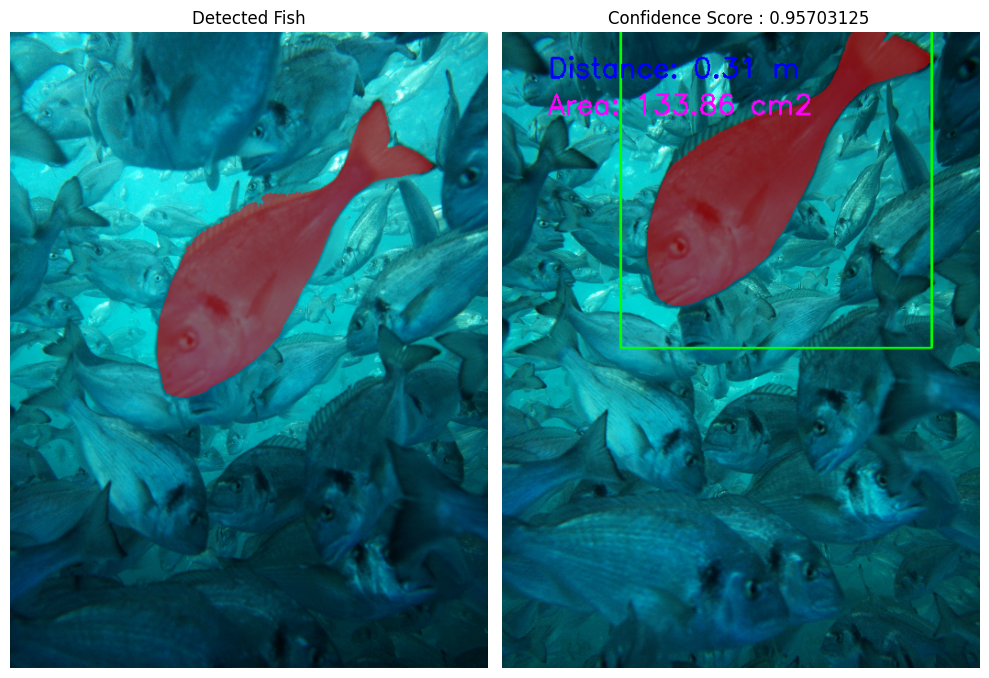

In [ ]:
for i , box in enumerate(boxes) :
    source_logits = np.load(f"/content/orate25/logits/{source_img_name}_{i}.npy")
    source_mask = np.load(f"/content/orate25/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

    best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)

    if best_mask is None :
        continue

    else :

        distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , 0.06 , FOCAL_LENGTH_12  , "12")

    # insert the function to caculate the distances of keypoints and filter !

        plot_masks(source_image     = source_img,
                target_image    = target_image,
                source_mask     = source_mask,
                source_box      = box,
                best_mask       = best_mask,
                best_box        = best_box,
                best_score      = best_score,
                distance        = distance,
                area            = area,
                index           = i)

In [ ]:
source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
label_file_path = f"/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/{source_img_name}" + ".txt"
target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
logit_to_image_coeff = target_image.shape[0]//250
predictor.set_image(target_image)

In [ ]:
cv2_imshow(255*temp_undistorted_source_mask)

### Esempio 2

In [ ]:
coupled_images[0]

('1753808185_photo_l1', '1753808185_photo_l2', True, 1)

In [ ]:
source_img_name , target_img_name , direction , baseline_code = coupled_images[0]

In [ ]:
source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
label_file_path = f"/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/{source_img_name}" + ".txt"
target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
logit_to_image_coeff = target_image.shape[0]//250
predictor.set_image(target_image)


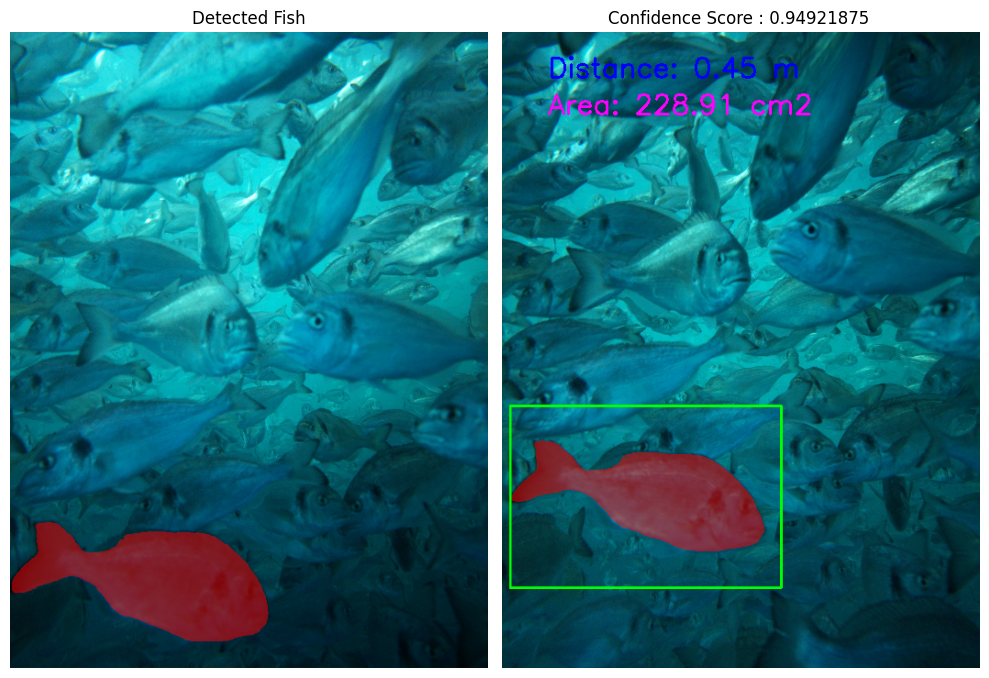

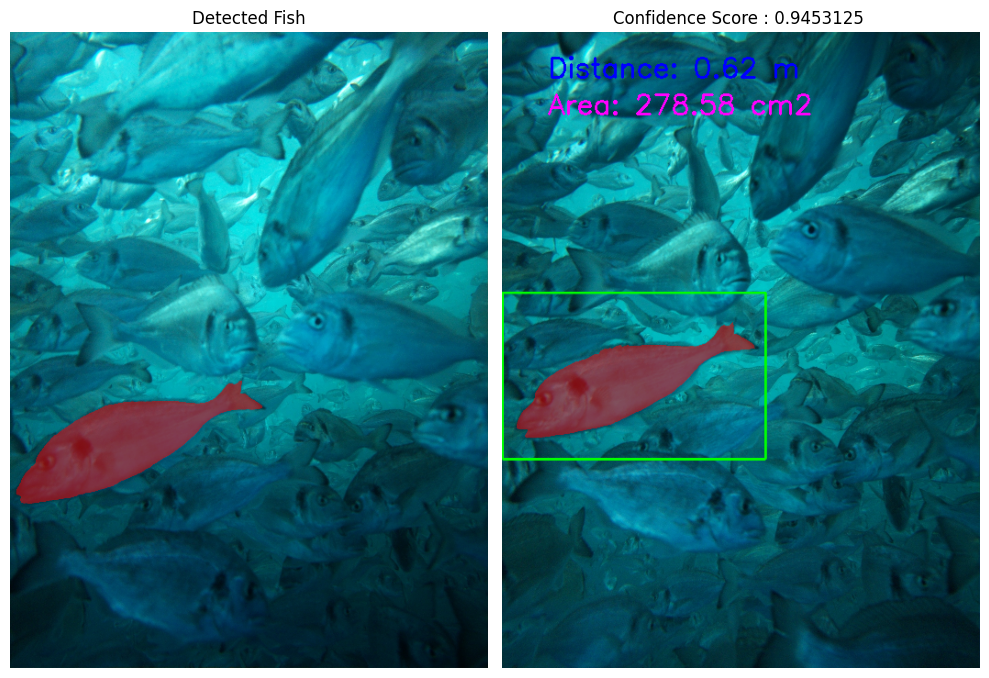

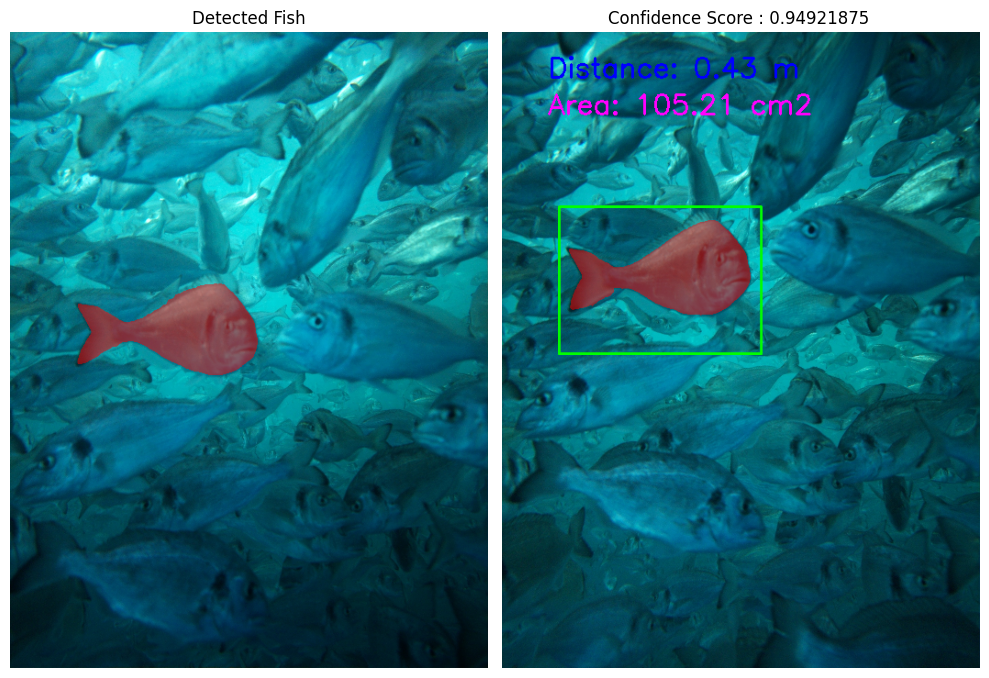

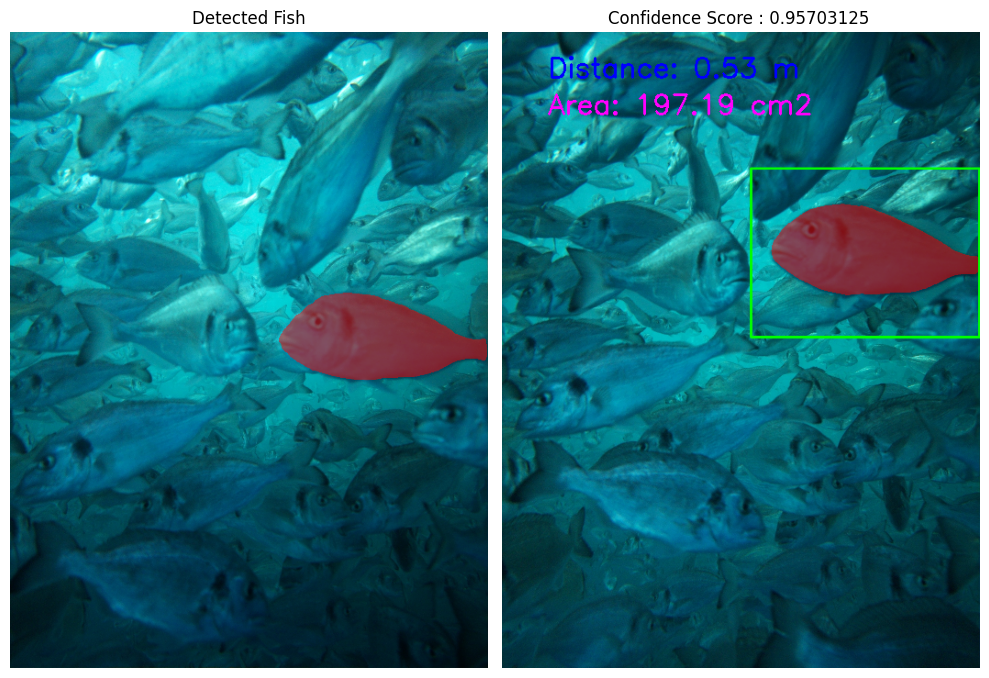

In [ ]:
boxes = load_bounding_boxes(label_file_path , source_img)
stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
stride_boxes = stride_logits* logit_to_image_coeff

source_logits = np.load(f"/content/orate25/logits/{source_img_name}_{i}.npy")
source_mask = np.load(f"/content/orate25/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

for i , box in enumerate(boxes) :
    source_logits = np.load(f"/content/orate25/logits/{source_img_name}_{i}.npy")
    source_mask = np.load(f"/content/orate25/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

    best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)
    if best_mask is None :
        continue

    else :

        distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , 0.06 , FOCAL_LENGTH_12  , "12")

    # insert the function to caculate the distances of keypoints and filter !

        plot_masks(source_image     = source_img,
                target_image    = target_image,
                source_mask     = source_mask,
                source_box      = box,
                best_mask       = best_mask,
                best_box        = best_box,
                best_score      = best_score,
                distance        = distance,
                area            = area,
                index           = i)

In [ ]:
source_img_name , target_img_name , direction , baseline_code = coupled_images[2]

In [ ]:
source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
label_file_path = f"/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/{source_img_name}" + ".txt"
target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
logit_to_image_coeff = target_image.shape[0]//250
predictor.set_image(target_image)

In [ ]:
baseline_code

3

In [ ]:
if baseline_code == 1 :
    lenses = '12'
    focal_length = FOCAL_LENGTH_12
    baseline = 0.06
elif baseline_code == 3 :
    focal_length = FOCAL_LENGTH_03
    lenses = '03'
    baseline = 0.18

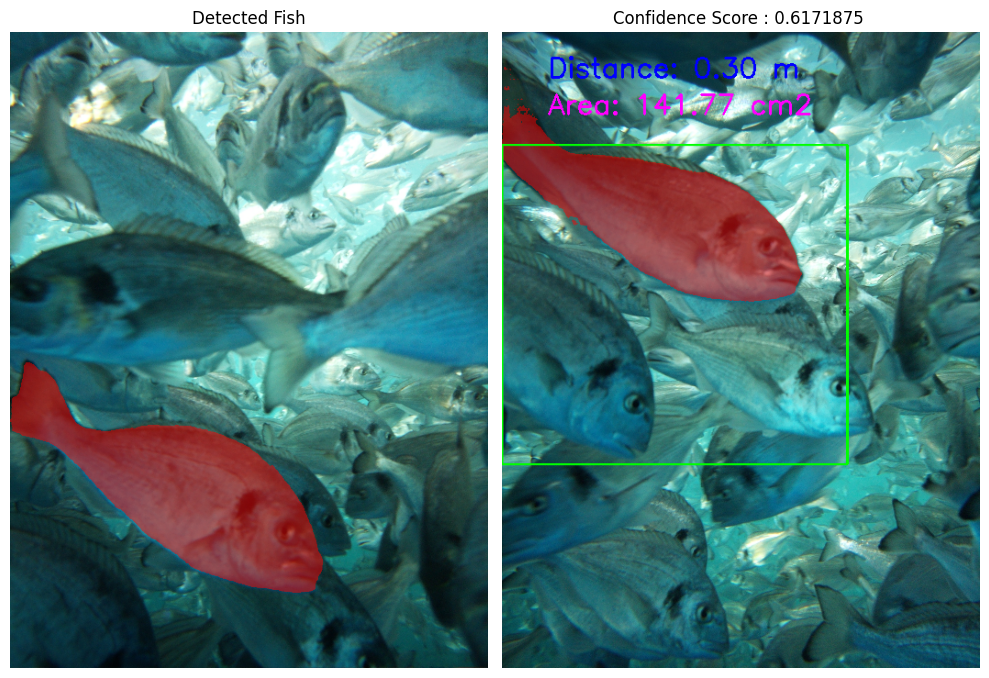

In [ ]:
source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
label_file_path = f"/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/orate25/{source_img_name}" + ".txt"
target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")
logit_to_image_coeff = target_image.shape[0]//250
predictor.set_image(target_image)

boxes = load_bounding_boxes(label_file_path , source_img)
stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
stride_boxes = stride_logits* logit_to_image_coeff

for i , box in enumerate(boxes) :
    source_logits = np.load(f"/content/orate25/logits/{source_img_name}_{i}.npy")
    source_mask = np.load(f"/content/orate25/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

    best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)
    if best_mask is None :
        continue

    else :

        distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

    # insert the function to caculate the distances of keypoints and filter !

        plot_masks(source_image     = source_img,
                target_image    = target_image,
                source_mask     = source_mask,
                source_box      = box,
                best_mask       = best_mask,
                best_box        = best_box,
                best_score      = best_score,
                distance        = distance,
                area            = area,
                index           = i,
                show = True)


### every image

In [ ]:
!mv ./fish_images ../

In [ ]:
cd ..

/content


In [ ]:
orate = "fish_images"

In [ ]:
file_list = [str(x.stem) for x in Path(orate).glob('*.jpg')]

In [ ]:
coupled_images = produce_coupled_images(file_list)

In [ ]:
coupled_images[0]

('1753805717_photo_l1', '1753805717_photo_l2', True, 1)

In [ ]:
FOCAL_LENGTH_12 , FOCAL_LENGTH_03

In [ ]:
import pandas as pd

In [ ]:
!rm -r test_distance/
!mkdir test_distance

In [ ]:
df, distances, areas, lens_counter, dx_pairs, area_pairs = stereo_measure_from_boxes(
    predictor=predictor,
    boxes_folder="/content/orate/boxes",
    images_folder="/content/fish_images",
    logits_folder="/content/orate/logits",
    masks_folder="/content/orate/masks",
    focal_length_12=FOCAL_LENGTH_12,
    focal_length_03=FOCAL_LENGTH_03,
    rectify=True,          # or False to skip rectification
    disparity="centroid",      # "centroid" | "shift" | "mean"
    dx_agree_px=50,
    mismatch_px_threshold=100,
    sim_tol=0.05,
    skip_on_mismatch=False,
    verbose=True
)

yes
Twin fish not detected in 1753807709_photo_l2 (box 0)
yes
disparity_mismatch for 1753807709_photo_l1_2: (162, 34.88848469917227)
yes
Twin fish not detected in 1753807401_photo_l3 (box 0)
Twin fish not detected in 1753783196_photo_l3 (box 0)
Twin fish not detected in 1753783196_photo_l3 (box 1)
Twin fish not detected in 1753783196_photo_l3 (box 2)
disparity_mismatch for 1753807778_photo_l1_0: (226, -33.968118860718675)
yes
Twin fish not detected in 1753808185_photo_l3 (box 0)
Twin fish not detected in 1753805757_photo_l3 (box 0)
Twin fish not detected in 1753805757_photo_l3 (box 1)
yes
Twin fish not detected in 1753805976_photo_l2 (box 1)
Twin fish not detected in 1753807620_photo_l3 (box 0)
Twin fish not detected in 1753807620_photo_l3 (box 1)
Twin fish not detected in 1753807917_photo_l3 (box 0)
yes
yes
yes
yes
disparity_mismatch for 1753807591_photo_l1_0: (262, -16.82028623250295)
yes
Twin fish not detected in 1753805907_photo_l3 (box 0)
disparity_mismatch for 1753805917_photo_l1

In [ ]:
df

source               target  box_index  direction_up  \
0    1753805717_photo_l1  1753805717_photo_l2          0          True   
1    1753807709_photo_l1  1753807709_photo_l2          1          True   
2    1753807709_photo_l1  1753807709_photo_l2          2          True   
3    1753807778_photo_l1  1753807778_photo_l2          0          True   
4    1753805976_photo_l1  1753805976_photo_l2          0          True   
..                   ...                  ...        ...           ...   
176  1753782860_photo_l0  1753782860_photo_l3          5          True   
177  1753783156_photo_l0  1753783156_photo_l3          0          True   
178  1753783156_photo_l0  1753783156_photo_l3          1          True   
179  1753783156_photo_l0  1753783156_photo_l3          2          True   
180  1753783156_photo_l0  1753783156_photo_l3          4          True   

     baseline_code lenses  baseline_m     focal_px  distance_m    area_cm2  \
0                1     12        0.06  1497.529642    0.316380  225.558148   
1                1     12        0.06  1497.529642    0.187191   90.387266   
2                1     12        0.06  1497.529642    0.554641   76.136488   
3                1     12        0.06  1497.529642    0.397574   44.584854   
4                1     12        0.06  1497.529642    0.619667   86.910250   
..             ...    ...         ...          ...         ...         ...   
176              3     03        0.18  1527.378951    0.470767   80.914026   
177              3     03        0.18  1527.378951    0.512926  119.303694   
178              3     03        0.18  1527.378951    0.545492  108.767857   
179              3     03        0.18  1527.378951    0.436394   76.366939   
180              3     03        0.18  1527.378951    0.637884   69.977240   

     dx_centroid      dx_est  area_px_left  area_px_right  best_score  \
0          284.0  299.678528      507767.0       502934.0    0.493937   
1          480.0  451.537384      665506.0       491451.0    0.496801   
2          162.0   34.888485       54302.0        56705.0    0.498509   
3          226.0  -33.968119       65650.0        60862.0    0.488168   
4          145.0   89.490686       54495.0        47021.0    0.481623   
..           ...         ...           ...            ...         ...   
176        584.0  555.207544       91780.0        78567.0    0.478533   
177        536.0 -282.135867      103316.0       108261.0    0.494338   
178        504.0 -320.210358       91056.0        79492.0    0.475410   
179        630.0 -215.916267      111083.0        76016.0    0.490300   
180        431.0 -174.453807       38436.0        41805.0    0.451161   

     disparity_mismatch  rectify disparity_mode  \
0                 False     True       centroid   
1                 False     True       centroid   
2                  True     True       centroid   
3                  True     True       centroid   
4                 False     True       centroid   
..                  ...      ...            ...   
176               False     True       centroid   
177                True     True       centroid   
178                True     True       centroid   
179                True     True       centroid   
180                True     True       centroid   

                                 mask_vis_file  
0    ./test_distance/1753805717_photo_l1_0.png  
1    ./test_distance/1753807709_photo_l1_1.png  
2    ./test_distance/1753807709_photo_l1_2.png  
3    ./test_distance/1753807778_photo_l1_0.png  
4    ./test_distance/1753805976_photo_l1_0.png  
..                                         ...  
176  ./test_distance/1753782860_photo_l0_5.png  
177  ./test_distance/1753783156_photo_l0_0.png  
178  ./test_distance/1753783156_photo_l0_1.png  
179  ./test_distance/1753783156_photo_l0_2.png  
180  ./test_distance/1753783156_photo_l0_4.png  

[181 rows x 19 columns]

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

In [ ]:
!zip  -r /content/mask_match_tol05_rect.zip /content/test_distance

In [ ]:
/content/orate/1753782516_photo_l1_0.jpg

In [ ]:
source_logits = np.load(f"/content/orate/logits/1753782516_photo_l1_0.npy")

In [ ]:
print("source_logits shape:", source_logits.shape)


source_logits shape: (1, 256, 256)


In [ ]:
!mkdir debug

In [ ]:
mask_left.shape

(1736, 2312, 3)

In [ ]:
mask_right.shape

(1736, 2312, 3)

In [ ]:
mask_left = cv2.imread("/content/debug/left_1753782526_photo_l0.png", cv2.IMREAD_GRAYSCALE)
mask_right = cv2.imread("/content/debug/right_1753782526_photo_l3.png", cv2.IMREAD_GRAYSCALE)
mask_left = (mask_left > 0).astype(np.uint8)
mask_right = (mask_right > 0).astype(np.uint8)
estimate_mask_shift(mask_left, mask_right)

(50.0, -294.69718818048887, 0.0, 'phasecorr_sdt')

# debugging

In [ ]:
boxes_folder = "/content/orate/boxes/"
boxes_files = Path(boxes_folder).glob("*.txt")
distances = []
areas = []
lens_counter = []
pixel_distances = []
pixel_areas = []
for bf in boxes_files:
    source_img_name = bf.stem
    # get the corrisponding target image from the coupled_images
    for coupled_image in coupled_images :
        if coupled_image[0] == source_img_name :
            target_img_name = coupled_image[1]
            direction = coupled_image[2]
            baseline_code = coupled_image[3]
    label_file_path = f"/content/orate/boxes/{source_img_name}" + ".txt"

    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
    label_file_path = f"./orate/boxes/{source_img_name}" + ".txt"
    target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image.shape[0] , image_width=target_image.shape[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in enumerate(boxes) :
        source_logits = np.load(f"/content/orate/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/orate/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes, source_mask)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:


                result = calculate_rectified_distance_and_area(best_mask ,source_mask, baseline, focal_length, lenses ,rectify=False ,disparity= 'centroid')

                if isinstance(result[2], str) and result[2] == "disparity_mismatch":
                    left_rect, right_rect, _, (dx1, dx2) = result
                    print(f"Disparity mismatch: centroid={dx1}, est={dx2}")
                    # optionally save masks for inspection
                    cv2.imwrite(f"./debug/left_{source_img_name}.png", left_rect*255)
                    cv2.imwrite(f"./debug/right_{target_img_name}.png", right_rect*255)
                else:
                    distance, area, pd, pa = result
                    distances.append(distance) # avg distance
                    areas.append(area) # avg areas
                    lens_counter.append(lenses) # which lenses
                    pixel_distances.append(pd) # both distances
                    pixel_areas.append(pa) # both areas
                # distance , area , pd , pa , mask = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

                # distances.append(distance)
                # areas.append(area)
                # lens_counter.append(lenses)
                # pixel_distances.append(pd)
                # pixel_areas.append(pa)
            except:
                print(f'Twin fish not detected in {target_img_name}')
            #plot_masks(source_image     = source_img,
            #         target_image    = target_image,
            #         source_mask     = source_mask,
            #         source_box      = box,
            #         best_mask       = best_mask,
            #         best_box        = best_box,
            #         best_score      = best_score,
            #         distance        = distance,
            #         area            = area,
            #         index           = i,
            #         show= False)




Twin fish not detected in 1753805707_photo_l3
Twin fish not detected in 1753782536_photo_l2
Twin fish not detected in 1753805936_photo_l2
Twin fish not detected in 1753807411_photo_l3
Twin fish not detected in 1753805818_photo_l3
Twin fish not detected in 1753808036_photo_l3
Twin fish not detected in 1753805798_photo_l3
Twin fish not detected in 1753806027_photo_l3
Twin fish not detected in 1753806027_photo_l3
Twin fish not detected in 1753806027_photo_l3
Twin fish not detected in 1753807460_photo_l3
Twin fish not detected in 1753807271_photo_l3
Twin fish not detected in 1753808145_photo_l3
Twin fish not detected in 1753808145_photo_l3
Twin fish not detected in 1753807659_photo_l3
Twin fish not detected in 1753807341_photo_l3
Twin fish not detected in 1753805957_photo_l2
Twin fish not detected in 1753807381_photo_l3
Twin fish not detected in 1753806077_photo_l3
Twin fish not detected in 1753783176_photo_l3
Twin fish not detected in 1753783176_photo_l3
Twin fish not detected in 17538056

In [ ]:
import pandas as pd

# Assuming you already have these lists filled:
# distances, areas, lens_counter, pixel_distances, pixel_areas

# Build a DataFrame
df = pd.DataFrame({
    "distance_m": distances,
    "area_cm2": areas,
    "lenses": lens_counter,
    "pixel_distances": pixel_distances,  # list of tuples or pairs
    "pixel_areas": pixel_areas           # list of tuples or pairs
})

# Save to Excel
output_path = "/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/stereo_measurements.xlsx"
df.to_excel(output_path, index=False)

print(f"✅ DataFrame saved to {output_path}")


✅ DataFrame saved to /content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/orate.xlsx


In [ ]:
pixel_distances

In [ ]:
pixel_areas

In [ ]:
lens_counter.count('12') , lens_counter.count('03')

(170, 140)

### spigole

In [ ]:
boxes_folder = "/content/spigole/boxes/"
boxes_files = Path(boxes_folder).glob("*.txt")
distances = []
areas = []
lens_counter = []
for bf in boxes_files:
    source_img_name = bf.stem
    # get the corrisponding target image from the coupled_images
    for coupled_image in coupled_images :
        if coupled_image[0] == source_img_name :
            target_img_name = coupled_image[1]
            direction = coupled_image[2]
            baseline_code = coupled_image[3]
    label_file_path = f"/content/spigole/boxes/{source_img_name}" + ".txt"

    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
    label_file_path = f"./spigole/boxes/{source_img_name}" + ".txt"
    target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image.shape[0] , image_width=target_image.shape[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in enumerate(boxes) :
        source_logits = np.load(f"/content/spigole/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/spigole/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:
                distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

                distances.append(distance)
                areas.append(area)
                lens_counter.append(lenses)

            except:
                print(f'Twin fish not detected in {target_img_name}')
            # plot_masks(source_image     = source_img,
                    # target_image    = target_image,
                    # source_mask     = source_mask,
                    # source_box      = box,
                    # best_mask       = best_mask,
                    # best_box        = best_box,
                    # best_score      = best_score,
                    # distance        = distance,
                    # area            = area,
                    # index           = i,
                    # show= False)




In [ ]:
len(distances)

In [ ]:
# plot histogram of distances and areas
plt.hist(distances)

In [ ]:
distances = []
areas = []

for source_img_name , target_img_name , direction , baseline_code in tqdm(coupled_images):
    # which couple of lenses ?
    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
    label_file_path = f"./orate/boxes/{source_img_name}" + ".txt"
    target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image[0] , image_width=target_image[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in enumerate(boxes) :
        source_logits = np.load(f"/content/orate/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/orate/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:
                distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

                distances.append(distance)
                areas.append(area)
            except:
                print(f'Twin fish not detected in {target_img_name}')
            #plot_masks(source_image     = source_img,
            #         target_image    = target_image,
            #         source_mask     = source_mask,
            #         source_box      = box,
            #         best_mask       = best_mask,
            #         best_box        = best_box,
            #         best_score      = best_score,
            #         distance        = distance,
            #         area            = area,
            #         index           = i,
            #         show= False)





In [ ]:
len(distances)

469

In [ ]:
import numpy as np
import pandas as pd

# distances and areas already defined (lists or arrays)
distances_np = np.asarray(distances, dtype=float)
areas_np     = np.asarray(areas, dtype=float)

# Combine into DataFrame (paired samples)
df = pd.DataFrame({"distance": distances_np, "area": areas_np})

def remove_outliers(df, cols, method="iqr", factor=1.5, z_thresh=3.0, pct=0.01):
    """
    method:
      - "iqr": Tukey fences (factor=1.5 or 3.0 for aggressive)
      - "zscore": mean/std
      - "mad": robust z using Median Absolute Deviation
      - "trim": percentile trimming (pct each side)
    Returns filtered_df, mask_kept, mask_removed
    """
    mask = np.ones(len(df), dtype=bool)

    for c in cols:
        x = df[c].values

        if method == "iqr":
            q1, q3 = np.percentile(x, [25, 75])
            iqr = q3 - q1
            lo = q1 - factor * iqr
            hi = q3 + factor * iqr
            mask &= (x >= lo) & (x <= hi)

        elif method == "zscore":
            m = np.nanmean(x)
            s = np.nanstd(x)
            if s == 0:
                continue
            z = (x - m)/s
            mask &= np.abs(z) <= z_thresh

        elif method == "mad":
            med = np.nanmedian(x)
            mad = np.nanmedian(np.abs(x - med))
            if mad == 0:
                continue
            robust_z = 0.6745 * (x - med) / mad
            mask &= np.abs(robust_z) <= z_thresh

        elif method == "trim":
            lo = np.percentile(x, 100*pct)
            hi = np.percentile(x, 100*(1-pct))
            mask &= (x >= lo) & (x <= hi)

        else:
            raise ValueError("Unknown method")

    filtered = df[mask].reset_index(drop=True)
    return filtered, mask, ~mask

# Choose method:
filtered_df, kept_mask, removed_mask = remove_outliers(df, ["distance","area"], method="iqr", factor=1.5)

print(f"Original n={len(df)}, kept={kept_mask.sum()}, removed={removed_mask.sum()}")

# Get cleaned arrays
distances_clean = filtered_df["distance"].to_numpy()
areas_clean     = filtered_df["area"].to_numpy()

# Optional: show removed rows
outliers_df = df[removed_mask]
print("Outliers (first 5):")
print(outliers_df.head())

Original n=310, kept=258, removed=52
Outliers (first 5):
    distance         area
2   1.300515  1445.472171
3   1.661707  1286.626964
5   3.374221  5624.513541
8   3.008719  3005.148703
14  2.162708   522.838953


Summary stats:
         distance        area
count  258.000000  258.000000
mean     0.584670  196.788851
std      0.236856  147.926954
min      0.160290   13.608056
25%      0.424203  108.310553
50%      0.538113  142.837741
75%      0.702186  220.608713
max      1.463526  846.122834


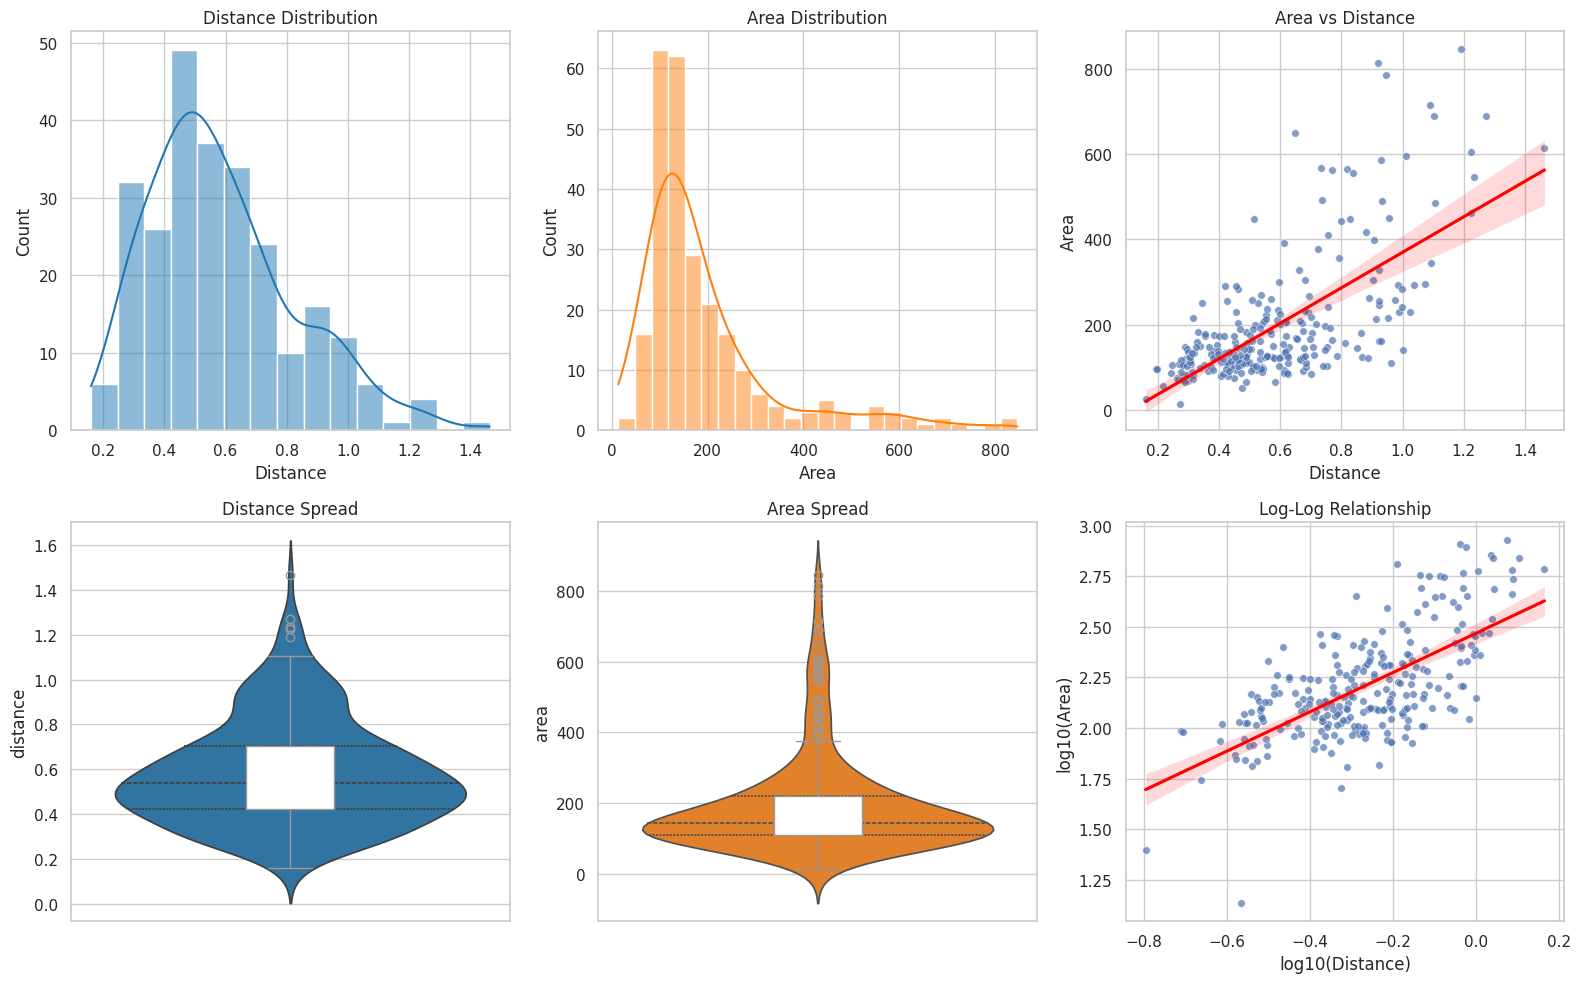

Pearson r: 0.6676 | Spearman rho: 0.6001


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume distances and areas already exist (lists, arrays, or Series)
# Clean data
distances_np = np.asarray(distances_clean, dtype=float)
areas_np     = np.asarray(areas_clean, dtype=float)

mask = np.isfinite(distances_np) & np.isfinite(areas_np)
distances_np = distances_np[mask]
areas_np     = areas_np[mask]

df = pd.DataFrame({
    "distance": distances_np,
    "area": areas_np,
    "log_distance": np.log10(np.clip(distances_np, 1e-12, None)),
    "log_area": np.log10(np.clip(areas_np, 1e-12, None))
})

print("Summary stats:")
print(df[["distance","area"]].describe())

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(16,10))

# 1. Distance distribution
ax1 = plt.subplot2grid((2,3), (0,0))
sns.histplot(df["distance"], kde=True, ax=ax1, color="#1f77b4")
ax1.set_title("Distance Distribution")
ax1.set_xlabel("Distance")
ax1.set_ylabel("Count")

# 2. Area distribution
ax2 = plt.subplot2grid((2,3), (0,1))
sns.histplot(df["area"], kde=True, ax=ax2, color="#ff7f0e")
ax2.set_title("Area Distribution")
ax2.set_xlabel("Area")
ax2.set_ylabel("Count")

# 3. Scatter + trend
ax3 = plt.subplot2grid((2,3), (0,2))
sns.scatterplot(x="distance", y="area", data=df, s=30, alpha=0.7, ax=ax3)
sns.regplot(x="distance", y="area", data=df, scatter=False, ax=ax3, color="red")
ax3.set_title("Area vs Distance")
ax3.set_xlabel("Distance")
ax3.set_ylabel("Area")

# 4. Box / Violin Distance
ax4 = plt.subplot2grid((2,3), (1,0))
sns.violinplot(y="distance", data=df, inner="quartile", ax=ax4, color="#1f77b4")
sns.boxplot(y="distance", data=df, width=0.2, boxprops={"zorder":3}, ax=ax4, color="white")
ax4.set_title("Distance Spread")

# 5. Box / Violin Area
ax5 = plt.subplot2grid((2,3), (1,1))
sns.violinplot(y="area", data=df, inner="quartile", ax=ax5, color="#ff7f0e")
sns.boxplot(y="area", data=df, width=0.2, boxprops={"zorder":3}, ax=ax5, color="white")
ax5.set_title("Area Spread")

# 6. Log-log scatter (if wide dynamic range)
ax6 = plt.subplot2grid((2,3), (1,2))
sns.scatterplot(x="log_distance", y="log_area", data=df, s=30, alpha=0.7, ax=ax6)
sns.regplot(x="log_distance", y="log_area", data=df, scatter=False, ax=ax6, color="red")
ax6.set_title("Log-Log Relationship")
ax6.set_xlabel("log10(Distance)")
ax6.set_ylabel("log10(Area)")

plt.tight_layout()
plt.show()

# Optional: correlation metrics
corr_pearson = df["distance"].corr(df["area"], method="pearson")
corr_spearman = df["distance"].corr(df["area"], method="spearman")
print(f"Pearson r: {corr_pearson:.4f} | Spearman rho: {corr_spearman:.4f}")

# Spigole divise per gabbie

In [ ]:
source_images_7 = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca/Gabbia7_shut8_foc16_iso300_600_nuvoloso_12.00/"
source_images_8 = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca/Gabbia8_shut8_foc16_iso300_600_nuvoloso_14.00/"

In [ ]:
spigole_gabbia_7 = list(Path(source_images_7 ).glob("*/*.png"))
spigole_gabbia_8 = list(Path(source_images_8 ).glob("*.png"))

In [ ]:
spigole_gabbia_7[0]

PosixPath('/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca/Gabbia7_shut8_foc16_iso300_600_nuvoloso_12.00/lato non cianciolato/1729607047_photo.png')

In [ ]:
len(spigole_gabbia_8)

205

In [ ]:
%cd /content/
folder_gabbia7 = "/content/spigole/gabbia7/"
folder_gabbia8 = "/content/spigole/gabbia8/"
folder_gabbia7_dentro = "/content/spigole/gabbia7/dentro/"
folder_gabbia7_fuori = "/content/spigole/gabbia7/fuori/"


!mkdir spigole
!mkdir {folder_gabbia7}
!mkdir {folder_gabbia8}

/content


In [ ]:
spigole_dentro = list(Path("/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca/Gabbia7_shut8_foc16_iso300_600_nuvoloso_12.00/dentro cianciola/").glob("*.png"))
spigole_fuori = list(Path("/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/SPIGOLE (Capraia)_Ottobre 24 con dati biometrici pesca/Gabbia7_shut8_foc16_iso300_600_nuvoloso_12.00/lato non cianciolato/").glob("*.png"))

In [ ]:
spigole_dentro

In [ ]:
for i , f in tqdm(enumerate(spigole_gabbia_7)):
    fname = str(f)
    img = cv2.imread(fname)
    height, width = img.shape[:2]
    l0 = img[:height // 2, :width // 2]
    l3 = img[:height // 2, width // 2:]
    l1 = img[height // 2:, :width // 2]
    l2 = img[height // 2:, width // 2:]
    correct_l0 = cv2.rotate(l0, cv2.ROTATE_90_CLOCKWISE)
    correct_l1 = cv2.rotate(l1, cv2.ROTATE_90_CLOCKWISE)
    correct_l2 = cv2.rotate(l2, cv2.ROTATE_90_CLOCKWISE)
    correct_l3 = cv2.rotate(l3, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f"{folder_gabbia7}{f.stem}_l0.jpg", correct_l0)
    cv2.imwrite(f"{folder_gabbia7}{f.stem}_l1.jpg", correct_l1)
    cv2.imwrite(f"{folder_gabbia7}{f.stem}_l2.jpg", correct_l2)
    cv2.imwrite(f"{folder_gabbia7}{f.stem}_l3.jpg", correct_l3)

293it [15:57,  3.27s/it]


In [ ]:
for i , f in tqdm(enumerate(spigole_gabbia_8)):
    fname = str(f)
    img = cv2.imread(fname)
    height, width = img.shape[:2]
    l0 = img[:height // 2, :width // 2]
    l3 = img[:height // 2, width // 2:]
    l1 = img[height // 2:, :width // 2]
    l2 = img[height // 2:, width // 2:]
    correct_l0 = cv2.rotate(l0, cv2.ROTATE_90_CLOCKWISE)
    correct_l1 = cv2.rotate(l1, cv2.ROTATE_90_CLOCKWISE)
    correct_l2 = cv2.rotate(l2, cv2.ROTATE_90_CLOCKWISE)
    correct_l3 = cv2.rotate(l3, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f"{folder_gabbia8}{f.stem}_l0.jpg", correct_l0)
    cv2.imwrite(f"{folder_gabbia8}{f.stem}_l1.jpg", correct_l1)
    cv2.imwrite(f"{folder_gabbia8}{f.stem}_l2.jpg", correct_l2)
    cv2.imwrite(f"{folder_gabbia8}{f.stem}_l3.jpg", correct_l3)

205it [11:01,  3.22s/it]


In [ ]:
# label_folder is the YOLO11 keypoints inference output labels folder
#labels_folder = "/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/Data_Inference/spigole24/"
#labels_list = list(Path(labels_folder).glob('*.txt'))
#image_lake = Path('./fish_images/').glob('*.*')
#imgs_list = [x for x in image_lake if x.stem in [x.stem for x in labels_list]]

### Gabbia 8

In [ ]:
# label_folder is the YOLO11 keypoints inference output labels folder
labels_folder = "/content/spigole/gabbia8/labels/"
labels_list = list(Path(labels_folder).glob('*.txt'))
image_lake = Path('/content/spigole/gabbia8/').glob('*.*')
imgs_list = [x for x in image_lake if x.stem in [x.stem for x in labels_list]]

In [ ]:
labels_list

In [ ]:
!mkdir spigole/

In [ ]:
save_dir = "/content/spigole/"
ratio_spigole = [3.0, 5.0]
ratios = generate_segmentation(predictor,
                               imgs_list,
                               labels_folder,
                               save_dir ,
                               calibration_results_03  ,
                               calibration_results_12 ,
                               ratio_spigole ,
                               save_origin=True)

  0%|          | 2/410 [00:00<00:21, 18.66it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688604_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729684985_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685103_photo_l1.txt


  2%|▏         | 10/410 [00:05<02:58,  2.24it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689615_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687286_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689777_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685213_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685164_photo_l1.txt


  3%|▎         | 13/410 [00:05<01:45,  3.77it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687525_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688782_photo_l0.txt


  5%|▍         | 20/410 [00:09<02:40,  2.43it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688673_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689827_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686330_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687286_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686220_photo_l0.txt


  6%|▌         | 23/410 [00:09<01:48,  3.58it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686160_photo_l1.txt


  7%|▋         | 28/410 [00:15<05:05,  1.25it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688624_photo_l0.txt


  8%|▊         | 33/410 [00:17<02:52,  2.18it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685064_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685093_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686511_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685331_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688574_photo_l0.txt


  9%|▉         | 36/410 [00:18<02:57,  2.11it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686320_photo_l1.txt


  9%|▉         | 38/410 [00:19<03:08,  1.97it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687535_photo_l0.txt


 10%|█         | 41/410 [00:22<03:53,  1.58it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689575_photo_l0.txt


 10%|█         | 43/410 [00:23<03:47,  1.61it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687385_photo_l0.txt


 11%|█▏        | 47/410 [00:27<04:58,  1.22it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688703_photo_l1.txt


 12%|█▏        | 49/410 [00:28<04:40,  1.29it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688752_photo_l0.txt


 12%|█▏        | 51/410 [00:29<04:16,  1.40it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686422_photo_l1.txt


 13%|█▎        | 55/410 [00:33<05:04,  1.16it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685263_photo_l0.txt


 14%|█▍        | 57/410 [00:34<04:24,  1.33it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686392_photo_l0.txt


 15%|█▌        | 62/410 [00:35<02:22,  2.45it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685143_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689565_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685263_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689787_photo_l0.txt


 16%|█▌        | 64/410 [00:36<02:38,  2.18it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688584_photo_l0.txt


 16%|█▋        | 67/410 [00:39<03:45,  1.52it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688703_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689467_photo_l0.txt


 18%|█▊        | 72/410 [00:43<04:17,  1.31it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687634_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689847_photo_l1.txt


 18%|█▊        | 75/410 [00:44<03:27,  1.62it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685123_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689605_photo_l1.txt


 20%|█▉        | 81/410 [00:45<01:56,  2.83it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687673_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687385_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686380_photo_l1.txt


 20%|██        | 82/410 [00:46<02:31,  2.16it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689575_photo_l1.txt


 20%|██        | 84/410 [00:48<02:41,  2.02it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685133_photo_l1.txt


 22%|██▏       | 89/410 [00:49<01:51,  2.88it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687296_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688594_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685074_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686140_photo_l0.txt


 22%|██▏       | 92/410 [00:51<02:43,  1.95it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689877_photo_l0.txt


 23%|██▎       | 96/410 [00:55<03:58,  1.32it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686240_photo_l1.txt


 25%|██▌       | 103/410 [00:58<02:18,  2.22it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685005_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685301_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688742_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689938_photo_l0.txt


 26%|██▌       | 106/410 [01:01<03:12,  1.58it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687405_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686320_photo_l0.txt


 27%|██▋       | 112/410 [01:03<02:11,  2.27it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689877_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685203_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685321_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686230_photo_l1.txt


 28%|██▊       | 116/410 [01:05<02:36,  1.88it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685282_photo_l1.txt


 30%|██▉       | 121/410 [01:07<01:38,  2.93it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686120_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688772_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688614_photo_l1.txt


 30%|███       | 123/410 [01:09<02:55,  1.64it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688712_photo_l0.txt


 30%|███       | 125/410 [01:10<02:51,  1.66it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685093_photo_l1.txt


 31%|███       | 128/410 [01:13<03:29,  1.35it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685311_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685154_photo_l0.txt


 33%|███▎      | 135/410 [01:15<01:52,  2.44it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687296_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685292_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685113_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687584_photo_l0.txt


 33%|███▎      | 137/410 [01:16<02:04,  2.19it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685233_photo_l0.txt


 34%|███▍      | 139/410 [01:17<02:12,  2.05it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687614_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686160_photo_l0.txt


 35%|███▍      | 143/410 [01:20<02:35,  1.72it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685243_photo_l1.txt


 35%|███▌      | 145/410 [01:21<02:32,  1.74it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687604_photo_l1.txt


 36%|███▋      | 149/410 [01:23<01:56,  2.24it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687565_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688683_photo_l0.txt


 38%|███▊      | 156/410 [01:24<00:56,  4.53it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685272_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685074_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685272_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685440_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685282_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685203_photo_l1.txt


 39%|███▊      | 158/410 [01:25<01:28,  2.86it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688673_photo_l1.txt


 40%|███▉      | 162/410 [01:30<03:19,  1.24it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685054_photo_l0.txt


 40%|████      | 164/410 [01:31<02:58,  1.38it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685015_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685034_photo_l1.txt


 42%|████▏     | 172/410 [01:38<03:54,  1.01it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687346_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686543_photo_l1.txt


 43%|████▎     | 175/410 [01:40<02:39,  1.48it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729684995_photo_l1.txt


 43%|████▎     | 177/410 [01:41<02:36,  1.49it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686140_photo_l1.txt


 44%|████▎     | 179/410 [01:42<02:28,  1.56it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685133_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689715_photo_l1.txt


 46%|████▌     | 188/410 [01:50<03:47,  1.03s/it]

No valid boxes found in /content/spigole/gabbia8/labels/1729687395_photo_l1.txt


 47%|████▋     | 194/410 [01:53<01:41,  2.12it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687366_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688507_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686220_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688565_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686431_photo_l0.txt


 48%|████▊     | 197/410 [01:55<01:46,  2.00it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686543_photo_l0.txt


 49%|████▉     | 200/410 [01:57<02:16,  1.54it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687415_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688644_photo_l0.txt


 50%|████▉     | 204/410 [01:59<02:10,  1.58it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686422_photo_l0.txt


 52%|█████▏    | 213/410 [02:09<03:31,  1.08s/it]

No valid boxes found in /content/spigole/gabbia8/labels/1729686090_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685351_photo_l1.txt


 53%|█████▎    | 216/410 [02:10<02:16,  1.42it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685301_photo_l0.txt


 54%|█████▎    | 220/410 [02:13<02:41,  1.18it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687415_photo_l1.txt


 54%|█████▍    | 222/410 [02:15<02:22,  1.32it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685253_photo_l0.txt


 56%|█████▌    | 229/410 [02:18<01:28,  2.04it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685113_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687594_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685460_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688614_photo_l0.txt


 56%|█████▋    | 231/410 [02:20<01:32,  1.94it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685351_photo_l0.txt


 57%|█████▋    | 233/410 [02:21<01:34,  1.88it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686180_photo_l0.txt


 59%|█████▊    | 240/410 [02:28<02:43,  1.04it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686120_photo_l1.txt


 61%|██████    | 251/410 [02:36<01:21,  1.94it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685311_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685194_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686310_photo_l0.txt


 61%|██████▏   | 252/410 [02:37<01:48,  1.45it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688792_photo_l0.txt


 62%|██████▏   | 254/410 [02:38<01:40,  1.56it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685005_photo_l1.txt


 62%|██████▏   | 256/410 [02:39<01:34,  1.62it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685164_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685025_photo_l1.txt


 63%|██████▎   | 259/410 [02:41<01:20,  1.88it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687525_photo_l0.txt


 64%|██████▍   | 262/410 [02:43<01:38,  1.50it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687663_photo_l0.txt


 65%|██████▌   | 267/410 [02:44<00:56,  2.54it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688624_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689867_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687565_photo_l1.txt


 67%|██████▋   | 276/410 [02:52<01:06,  2.03it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685015_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687614_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685054_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687535_photo_l1.txt


 68%|██████▊   | 278/410 [02:53<01:14,  1.78it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685292_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689847_photo_l0.txt


 69%|██████▉   | 282/410 [02:55<01:17,  1.65it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686090_photo_l0.txt


 69%|██████▉   | 284/410 [02:56<01:14,  1.69it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685253_photo_l1.txt


 70%|██████▉   | 286/410 [02:58<01:13,  1.68it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686130_photo_l1.txt


 70%|███████   | 288/410 [02:59<01:11,  1.70it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685064_photo_l0.txt


 71%|███████   | 290/410 [03:00<01:09,  1.72it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685044_photo_l0.txt


 71%|███████   | 292/410 [03:01<01:08,  1.73it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686230_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688683_photo_l1.txt


 72%|███████▏  | 295/410 [03:02<00:57,  1.99it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689918_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685025_photo_l0.txt


 73%|███████▎  | 299/410 [03:04<01:01,  1.80it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685034_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688497_photo_l1.txt


 74%|███████▍  | 305/410 [03:06<00:36,  2.88it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687336_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689715_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685143_photo_l1.txt


 75%|███████▍  | 307/410 [03:08<01:00,  1.71it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689867_photo_l1.txt


 76%|███████▌  | 312/410 [03:10<00:34,  2.81it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729686461_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729688507_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687724_photo_l1.txt


 77%|███████▋  | 314/410 [03:11<00:41,  2.34it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687584_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685174_photo_l0.txt


 79%|███████▊  | 322/410 [03:12<00:18,  4.66it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685184_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687256_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686461_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685174_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687634_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687356_photo_l0.txt


 80%|███████▉  | 326/410 [03:17<00:53,  1.57it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689467_photo_l1.txt


 82%|████████▏ | 335/410 [03:23<00:37,  1.99it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685044_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685184_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685430_photo_l1.txt


 82%|████████▏ | 336/410 [03:24<00:45,  1.62it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685233_photo_l1.txt


 83%|████████▎ | 339/410 [03:26<00:50,  1.41it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689726_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685103_photo_l0.txt


 85%|████████▍ | 347/410 [03:33<01:00,  1.04it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688693_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686240_photo_l0.txt


 85%|████████▌ | 350/410 [03:34<00:40,  1.48it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689746_photo_l1.txt


 86%|████████▌ | 352/410 [03:36<00:37,  1.56it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689665_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729685194_photo_l1.txt


 88%|████████▊ | 361/410 [03:45<00:53,  1.09s/it]

No valid boxes found in /content/spigole/gabbia8/labels/1729689938_photo_l1.txt


 89%|████████▉ | 365/410 [03:48<00:43,  1.02it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685223_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729684975_photo_l1.txt


 90%|████████▉ | 368/410 [03:49<00:28,  1.48it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685123_photo_l0.txt


 90%|█████████ | 371/410 [03:52<00:29,  1.32it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687326_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729686360_photo_l1.txt


 91%|█████████ | 374/410 [03:53<00:21,  1.69it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687405_photo_l0.txt


 92%|█████████▏| 376/410 [03:54<00:19,  1.70it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688497_photo_l0.txt


 92%|█████████▏| 379/410 [03:56<00:21,  1.43it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688742_photo_l0.txt


 93%|█████████▎| 381/410 [03:58<00:19,  1.46it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689928_photo_l1.txt


 95%|█████████▍| 388/410 [04:01<00:09,  2.25it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688644_photo_l1.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729687594_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729689605_photo_l0.txt


 95%|█████████▍| 389/410 [04:02<00:11,  1.78it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685154_photo_l1.txt


 95%|█████████▌| 391/410 [04:03<00:10,  1.74it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729689565_photo_l0.txt


 96%|█████████▌| 393/410 [04:04<00:09,  1.75it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687366_photo_l1.txt


 97%|█████████▋| 396/410 [04:07<00:09,  1.44it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729688772_photo_l0.txt


 98%|█████████▊| 400/410 [04:10<00:08,  1.21it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729687574_photo_l0.txt


 99%|█████████▊| 404/410 [04:14<00:05,  1.12it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685331_photo_l0.txt
No valid boxes found in /content/spigole/gabbia8/labels/1729684975_photo_l0.txt


100%|██████████| 410/410 [04:17<00:00,  1.59it/s]

No valid boxes found in /content/spigole/gabbia8/labels/1729685341_photo_l1.txt
Processed 844 fish


In [ ]:
print(f'from all  {len(ratios)} fish detected , {len([x for x in ratios if (x > ratio_spigole[0]) and (x < ratio_spigole[1])])} are in a good position')

from all  844 fish detected , 376 are in a good position


In [ ]:
coupled_image = produce_coupled_images()

In [ ]:
help(produce_coupled_images)

Help on function produce_coupled_images in module __main__:

produce_coupled_images(file_names)



#### calculate Area and Distance

In [ ]:
# ...existing code...
def calculate_rectified_distance_and_area(
    left_mask,
    right_mask,
    baseline,
    focal_length,
    lenses,
    rectify: bool = True,              # True: use stereo rectification maps; False: skip remap
    disparity: str = "mean",           # "centroid" | "shift" | "mean"
    dx_agree_px: float = 50.0          # mismatch threshold when using "mean"
):
    """
    Compute distance (m) and area (cm^2) from stereo masks with configurable options.

    Args:
      left_mask, right_mask: binary masks (any dtype/shape; will be resized/rotated)
      baseline: meters
      focal_length: pixels
      lenses: "12" or "03"
      rectify: if True, apply rectification maps; if False, only resize/rotate
      disparity:
        - "centroid": dx from centroid difference after (optional) rectification
        - "shift":    dx from estimate_mask_shift (ECC/phasecorr) after (optional) rectification
        - "mean":     mean of available dx estimates (flags mismatch if they differ > dx_agree_px)
      dx_agree_px: mismatch threshold for "mean"

    Returns:
      distance_m, area_cm2, (dx_centroid, dx_est), (area_px_left, area_px_right)
    """
    H, W = 2312, 1736

    # Ensure 2D binary masks
    left = np.asarray(left_mask)
    right = np.asarray(right_mask)
    if left.ndim > 2:
        left = left.squeeze()
    if right.ndim > 2:
        right = right.squeeze()
    left = (left > 0).astype(np.uint8)
    right = (right > 0).astype(np.uint8)

    # Resize to expected sensor shape
    if left.shape != (H, W):
        left = cv2.resize(left, (W, H), interpolation=cv2.INTER_NEAREST)
    if right.shape != (H, W):
        right = cv2.resize(right, (W, H), interpolation=cv2.INTER_NEAREST)

    # Rotate to match calibration orientation
    left = cv2.rotate(left, cv2.ROTATE_90_COUNTERCLOCKWISE)
    right = cv2.rotate(right, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Pick rectification maps
    if lenses == "12":
        lmxr, lmyr = left_map_x_rectify_12, left_map_y_rectify_12
        rmxr, rmyr = right_map_x_rectify_12, right_map_y_rectify_12
    elif lenses == "03":
        lmxr, lmyr = left_map_x_rectify_03, left_map_y_rectify_03
        rmxr, rmyr = right_map_x_rectify_03, right_map_y_rectify_03
    else:
        raise ValueError("Lenses must be '12' or '03'")

    # Rectify (optional)
    if rectify:
        left_rect = cv2.remap(left, lmxr, lmyr, interpolation=cv2.INTER_NEAREST,
                              borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        right_rect = cv2.remap(right, rmxr, rmyr, interpolation=cv2.INTER_NEAREST,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    else:
        left_rect, right_rect = left, right

    # Guard empty masks
    if left_rect.sum() == 0 or right_rect.sum() == 0:
        return None, None, (None, None), (None, None)

    # Disparity estimates
    dx_centroid, _ = get_mask_centroid_difference(left_rect, right_rect)  # returns (dx, dy)
    _, dx_est, _, _ = estimate_mask_shift(left_rect, right_rect)          # returns (dy, dx, score, method)

    # Select disparity
    dx = None
    disp = disparity.lower()
    if disp in ("centroid", "centroid_only"):
        dx = dx_centroid
    elif disp in ("shift", "est", "ecc", "phasecorr"):
        dx = dx_est
    elif disp in ("mean", "avg", "auto"):
        vals = [v for v in (dx_centroid, dx_est) if v is not None and np.isfinite(v)]
        if not vals:
            dx = None
        elif len(vals) == 1:
            dx = float(vals[0])
        else:
            # Optionally flag mismatch; we still return mean
            if abs(float(vals[0]) - float(vals[1])) > float(dx_agree_px):
                pass  # caller can check difference in the returned tuple
            dx = float(np.mean(vals))
    else:
        raise ValueError("disparity must be one of ['centroid','shift','mean']")

    if dx is None or abs(dx) < 1e-6:
        return None, None, (dx_centroid, dx_est), (int(left_rect.sum()), int(right_rect.sum()))

    # Distance (baseline in meters, focal length in pixels)
    distance_m = (baseline * float(focal_length)) / abs(dx)

    # Area: mean of foreground pixels (rectified or not), converted to cm^2
    area_px = float(left_rect.sum() + right_rect.sum()) / 2.0
    area_cm2 = pixel_area_to_cm2(area_px, distance_m, float(focal_length))

    return distance_m, area_cm2, (dx_centroid, dx_est), (int(left_rect.sum()), int(right_rect.sum()))
# ...existing code...

In [ ]:
def stereo_measure_from_boxes(
    predictor,
    boxes_folder: str,
    images_folder: str,
    logits_folder: str,
    masks_folder: str,
    focal_length_12: float,
    focal_length_03: float,
    baseline_12: float = 0.06,
    baseline_03: float = 0.18,
    stride_logit_min: int = 5,
    stride_logit_max: int = 80,
    stride_logit_n: int = 20,
    logit_grid_div: int = 250,
    # Flags passed to calculate_rectified_distance_and_area
    rectify: bool = True,
    disparity: str = "mean",         # "centroid" | "shift" | "mean"
    dx_agree_px: float = 50.0,
    # Post-checks
    mismatch_px_threshold: float | None = None,
    skip_on_mismatch: bool = False,
    verbose: bool = False
):
    """
    Run stereo matching for all boxes and return a DataFrame and raw lists.

    Returns:
      df, distances, areas, lens_counter, dx_pairs, area_pairs
    """
    boxes_folder = Path(boxes_folder)
    images_folder = Path(images_folder)
    logits_folder = Path(logits_folder)
    masks_folder = Path(masks_folder)

    box_files = list(boxes_folder.glob("*.txt"))
    stems = [x.stem for x in box_files]
    coupled_images = produce_coupled_images(stems)
    pair_map = {s: (t, direction, baseline_code) for (s, t, direction, baseline_code) in coupled_images}

    distances, areas, lens_counter = [], [], []
    dx_pairs, area_pairs, rows = [], [], []

    for bf in box_files:
        source_img_name = bf.stem
        if source_img_name not in pair_map:
            if verbose:
                print(f"[WARN] No pair for {source_img_name}")
            continue

        target_img_name, direction, baseline_code = pair_map[source_img_name]
        label_file_path = boxes_folder / f"{source_img_name}.txt"

        if baseline_code == 1:
            lenses = "12"; focal_length = float(focal_length_12); baseline = float(baseline_12)
        elif baseline_code == 3:
            lenses = "03"; focal_length = float(focal_length_03); baseline = float(baseline_03)
        else:
            if verbose:
                print(f"[WARN] Unknown baseline_code {baseline_code} for {source_img_name}")
            continue

        source_img = cv2.imread(str(images_folder / f"{source_img_name}.jpg"))
        target_image = cv2.imread(str(images_folder / f"{target_img_name}.jpg"))
        if target_image is None:
            if verbose:
                print(f"[WARN] Missing target image {target_img_name}.jpg")
            continue

        logit_to_image_coeff = int(target_image.shape[0] // logit_grid_div)
        predictor.set_image(target_image)

        boxes = load_bounding_boxes(
            str(label_file_path),
            image_height=target_image.shape[0],
            image_width=target_image.shape[1]
        )
        stride_logits = np.linspace(stride_logit_min, stride_logit_max, stride_logit_n, dtype=int)
        stride_boxes = stride_logits * logit_to_image_coeff

        for i, box in enumerate(boxes):
            logits_path = logits_folder / f"{source_img_name}_{i}.npy"
            mask_path = masks_folder / f"{source_img_name}_{i}.npy"
            if not logits_path.exists() or not mask_path.exists():
                if verbose:
                    print(f"[WARN] Missing npy for {source_img_name}_{i}")
                continue

            source_logits = np.load(str(logits_path))
            source_mask = np.load(str(mask_path)).astype(np.float32).squeeze()

            best_mask, best_box, best_score = detect_similar_mask(
                box, predictor, direction, source_mask, source_logits, stride_logits, stride_boxes
            )
            if best_mask is None:
                if verbose:
                    print(f"Twin fish not detected in {target_img_name} (box {i})")
                continue

            try:
                distance, area, dx_pair, area_pair = calculate_rectified_distance_and_area(
                    source_mask, best_mask, baseline, focal_length, lenses,
                    rectify=rectify, disparity=disparity, dx_agree_px=dx_agree_px
                )

                mismatch = False
                if mismatch_px_threshold is not None and dx_pair[0] is not None and dx_pair[1] is not None:
                    if abs(abs(float(dx_pair[0])) - abs(float(dx_pair[1]))) > float(mismatch_px_threshold):
                        mismatch = True
                        if verbose:
                            print(f"disparity_mismatch for {source_img_name}_{i}: {dx_pair}")
                if skip_on_mismatch and mismatch:
                    continue

                # --- NEW: Save visualization with plot_masks ---
                saved_file = plot_masks(
                    source_image=source_img,
                    target_image=target_image,
                    source_mask=source_mask,
                    source_box=box,
                    best_mask=best_mask,
                    best_box=best_box,
                    best_score=best_score,
                    distance=distance if distance is not None else 0.0,
                    area=area if area is not None else 0.0,
                    index=i,
                    show=False,
                    save_dir="./test_distance",
                    filename=f"{source_img_name}_{i}"
                )

                distances.append(distance)
                areas.append(area)
                lens_counter.append(lenses)
                dx_pairs.append(dx_pair)
                area_pairs.append(area_pair)

                rows.append({
                    "source": source_img_name,
                    "target": target_img_name,
                    "box_index": i,
                    "direction_up": bool(direction),
                    "baseline_code": int(baseline_code),
                    "lenses": lenses,
                    "baseline_m": baseline,
                    "focal_px": focal_length,
                    "distance_m": None if distance is None else float(distance),
                    "area_cm2": None if area is None else float(area),
                    "dx_centroid": None if dx_pair[0] is None else float(dx_pair[0]),
                    "dx_est": None if dx_pair[1] is None else float(dx_pair[1]),
                    "area_px_left": None if area_pair[0] is None else int(area_pair[0]),
                    "area_px_right": None if area_pair[1] is None else int(area_pair[1]),
                    "best_score": None if best_score is None else float(best_score),
                    "disparity_mismatch": mismatch,
                    "rectify": bool(rectify),
                    "disparity_mode": disparity,
                    # --- NEW COLUMN ---
                    "mask_vis_file": saved_file
                })
                if verbose:
                    print("yes")

            except Exception as e:
                if verbose:
                    print(f"Error on {source_img_name}_{i}: {e}")

    df = pd.DataFrame(rows)
    return df, distances, areas, lens_counter, dx_pairs, area_pairs



In [ ]:
### Without plotting

def stereo_measure_from_boxes(
    predictor,
    boxes_folder: str,
    images_folder: str,
    logits_folder: str,
    masks_folder: str,
    focal_length_12: float,
    focal_length_03: float,
    baseline_12: float = 0.06,
    baseline_03: float = 0.18,
    stride_logit_min: int = 5,
    stride_logit_max: int = 80,
    stride_logit_n: int = 20,
    logit_grid_div: int = 250,
    # Flags passed to calculate_rectified_distance_and_area
    rectify: bool = True,
    disparity: str = "mean",         # "centroid" | "shift" | "mean"
    dx_agree_px: float = 50.0,
    # Post-checks
    mismatch_px_threshold: float | None = None,
    skip_on_mismatch: bool = False,
    verbose: bool = False
):
    """
    Run stereo matching for all boxes and return a DataFrame and raw lists.

    Returns:
      df, distances, areas, lens_counter, dx_pairs, area_pairs
    """
    boxes_folder = Path(boxes_folder)
    images_folder = Path(images_folder)
    logits_folder = Path(logits_folder)
    masks_folder = Path(masks_folder)

    box_files = list(boxes_folder.glob("*.txt"))
    stems = [x.stem for x in box_files]
    coupled_images = produce_coupled_images(stems)
    pair_map = {s: (t, direction, baseline_code) for (s, t, direction, baseline_code) in coupled_images}

    distances, areas, lens_counter = [], [], []
    dx_pairs, area_pairs, rows = [], [], []

    for bf in box_files:
        source_img_name = bf.stem
        if source_img_name not in pair_map:
            if verbose:
                print(f"[WARN] No pair for {source_img_name}")
            continue

        target_img_name, direction, baseline_code = pair_map[source_img_name]
        label_file_path = boxes_folder / f"{source_img_name}.txt"

        if baseline_code == 1:
            lenses = "12"; focal_length = float(focal_length_12); baseline = float(baseline_12)
        elif baseline_code == 3:
            lenses = "03"; focal_length = float(focal_length_03); baseline = float(baseline_03)
        else:
            if verbose:
                print(f"[WARN] Unknown baseline_code {baseline_code} for {source_img_name}")
            continue

        source_img = cv2.imread(str(images_folder / f"{source_img_name}.jpg"))
        target_image = cv2.imread(str(images_folder / f"{target_img_name}.jpg"))
        if target_image is None:
            if verbose:
                print(f"[WARN] Missing target image {target_img_name}.jpg")
            continue

        logit_to_image_coeff = int(target_image.shape[0] // logit_grid_div)
        predictor.set_image(target_image)

        boxes = load_bounding_boxes(
            str(label_file_path),
            image_height=target_image.shape[0],
            image_width=target_image.shape[1]
        )
        stride_logits = np.linspace(stride_logit_min, stride_logit_max, stride_logit_n, dtype=int)
        stride_boxes = stride_logits * logit_to_image_coeff

        for i, box in enumerate(boxes):
            logits_path = logits_folder / f"{source_img_name}_{i}.npy"
            mask_path = masks_folder / f"{source_img_name}_{i}.npy"
            if not logits_path.exists() or not mask_path.exists():
                if verbose:
                    print(f"[WARN] Missing npy for {source_img_name}_{i}")
                continue

            source_logits = np.load(str(logits_path))
            source_mask = np.load(str(mask_path)).astype(np.float32).squeeze()

            best_mask, best_box, best_score = detect_similar_mask(
                box, predictor, direction, source_mask, source_logits, stride_logits, stride_boxes
            )
            if best_mask is None:
                if verbose:
                    print(f"Twin fish not detected in {target_img_name} (box {i})")
                continue

            try:
                distance, area, dx_pair, area_pair = calculate_rectified_distance_and_area(
                    source_mask, best_mask, baseline, focal_length, lenses,
                    rectify=rectify, disparity=disparity, dx_agree_px=dx_agree_px
                )

                mismatch = False
                if mismatch_px_threshold is not None and dx_pair[0] is not None and dx_pair[1] is not None:
                    if abs(abs(float(dx_pair[0])) - abs(float(dx_pair[1]))) > float(mismatch_px_threshold):
                        mismatch = True
                        if verbose:
                            print(f"disparity_mismatch for {source_img_name}_{i}: {dx_pair}")
                if skip_on_mismatch and mismatch:
                    continue

                distances.append(distance)
                areas.append(area)
                lens_counter.append(lenses)
                dx_pairs.append(dx_pair)
                area_pairs.append(area_pair)

                rows.append({
                    "source": source_img_name,
                    "target": target_img_name,
                    "box_index": i,
                    "direction_up": bool(direction),
                    "baseline_code": int(baseline_code),
                    "lenses": lenses,
                    "baseline_m": baseline,
                    "focal_px": focal_length,
                    "distance_m": None if distance is None else float(distance),
                    "area_cm2": None if area is None else float(area),
                    "dx_centroid": None if dx_pair[0] is None else float(dx_pair[0]),
                    "dx_est": None if dx_pair[1] is None else float(dx_pair[1]),
                    "area_px_left": None if area_pair[0] is None else int(area_pair[0]),
                    "area_px_right": None if area_pair[1] is None else int(area_pair[1]),
                    "best_score": None if best_score is None else float(best_score),
                    "disparity_mismatch": mismatch,
                    "rectify": bool(rectify),
                    "disparity_mode": disparity,
                })
                if verbose:
                    print("yes")

            except Exception as e:
                if verbose:
                    print(f"Error on {source_img_name}_{i}: {e}")

    df = pd.DataFrame(rows)
    return df, distances, areas, lens_counter, dx_pairs, area_pairs

In [ ]:
df, distances, areas, lens_counter, dx_pairs, area_pairs = stereo_measure_from_boxes(
    predictor=predictor,
    boxes_folder="/content/spigole/boxes8",
    images_folder="/content/spigole/gabbia8",
    logits_folder="/content/spigole/logits",
    masks_folder="/content/spigole/masks",
    focal_length_12=FOCAL_LENGTH_12,
    focal_length_03=FOCAL_LENGTH_03,
    rectify=False,          # or False to skip rectification
    disparity="centroid",      # "centroid" | "shift" | "mean"
    dx_agree_px=50,
    mismatch_px_threshold=100,
    skip_on_mismatch=False,
    verbose=True
)

In [ ]:
df.to_excel("/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/new_spigole_gabbia8.xlsx")

In [ ]:
areas

[]

In [ ]:
boxes_folder = "/content/spigole/boxes8/"
boxes_files = Path(boxes_folder).glob("*.txt")
coupled_images = produce_coupled_images([x.stem for x in boxes_files])

In [ ]:
best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction , source_mask ,source_logits, stride_logits , stride_boxes)

In [ ]:
cv2_imshow(source_mask*255)
cv2_imshow(best_mask*255)

In [ ]:
help(calculate_rectified_distance_and_area)

Help on function calculate_rectified_distance_and_area in module __main__:

calculate_rectified_distance_and_area(left_mask, right_mask, baseline: float, focal_length: float, lenses: str, rectify: bool = True, disparity: str = 'avg', area_tolerance: float = 0.1, return_details: bool = False)
    Returns:
      distance_m (float|None),
      area_cm2 (float|None)
      if return_details: (dx_centroid, dx_shift), (area_px_left, area_px_right)



In [ ]:
boxes_folder = "/content/spigole/boxes8/"
boxes_files = list(Path(boxes_folder).glob("*.txt"))
coupled_images = produce_coupled_images([x.stem for x in boxes_files])
distances = []
areas = []
lens_counter = []
diff_distances = []
diff_areas = []

for bf in boxes_files:
    source_img_name = bf.stem
    # get the corrisponding target image from the coupled_images
    for coupled_image in coupled_images :
        if coupled_image[0] == source_img_name :
            target_img_name = coupled_image[1]
            direction = coupled_image[2]
            baseline_code = coupled_image[3]
    label_file_path = f"/content/spigole/boxes8/{source_img_name}" + ".txt"

    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("/content/spigole/gabbia8/"+ source_img_name +".jpg")
    label_file_path = f"/content/spigole/boxes8/{source_img_name}" + ".txt"
    target_image = cv2.imread("/content/spigole/gabbia8/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image.shape[0] , image_width=target_image.shape[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in tqdm(enumerate(boxes)) :
        source_logits = np.load(f"/content/spigole/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/spigole/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()




        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes, source_mask)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:
                distance , area , diff_distance , diff_area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses , rectify=False , disparity="shift")

                distances.append(distance)
                areas.append(area)
                diff_distances.append(diff_distances)
                diff_areas.append(diff_area)
                lens_counter.append(lenses)
                #print("yes")

            except:
                print(f'Twin fish not detected in {target_img_name}')
            # plot_masks(source_image     = source_img,
                    # target_image    = target_image,
                    # source_mask     = source_mask,
                    # source_box      = box,
                    # best_mask       = best_mask,
                    # best_box        = best_box,
                    # best_score      = best_score,
                    # distance        = distance,
                    # area            = area,
                    # index           = i,
                    # show= False)




In [ ]:
import pandas as pd

In [ ]:
gabbia8 = pd.DataFrame({"Distances":distances , "Areas" : areas , "Lenses" :lens_counter , "Difference Areas": diff_areas , "Difference Distances":diff_distances})

In [ ]:
def rel_diff(tup):
    a, b = map(int, tup)   # convert np.uint64 to plain int
    return abs(a - b) / ((a + b) / 2)

# Keep only rows where relative difference <= 20%
filtered = gabbia8[gabbia8["Difference Areas"].apply(rel_diff) <= 0.2]

In [ ]:
gabbia8.to_excel("/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/spigole_gabbia8.xlsx")

In [ ]:
filtered.to_excel("/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/spigole_gabbia8.xlsx")

In [ ]:
filtered.shape

(275, 5)

# gabbia 7

In [ ]:
# label_folder is the YOLO11 keypoints inference output labels folder
labels_folder = "/content/spigole/gabbia7/labels/"
labels_list = list(Path(labels_folder).glob('*.txt'))
image_lake = Path('./spigole/gabbia7/').glob('*.*')
imgs_list = [x for x in image_lake if x.stem in [x.stem for x in labels_list]]

In [ ]:
save_dir = "/content/spigole/"
ratio_spigole = [3.0, 5.0]
ratios = generate_segmentation(predictor,
                               imgs_list,
                               labels_folder,
                               save_dir ,
                               calibration_results_03  ,
                               calibration_results_12 ,
                               ratio_spigole ,
                               save_origin=True)

In [ ]:
print(f'from all  {len(ratios)} fish detected , {len([x for x in ratios if (x > ratio_spigole[0]) and (x < ratio_spigole[1])])} are in a good position')

from all  1825 fish detected , 459 are in a good position


In [ ]:
# rename boxes to boxes7

In [ ]:
boxes_folder = "/content/spigole/boxes7/"
boxes_files = list(Path(boxes_folder).glob("*.txt"))
coupled_images = produce_coupled_images([x.stem for x in boxes_files])
distances = []
areas = []
lens_counter = []
diff_distances = []
diff_areas = []

for bf in boxes_files:
    source_img_name = bf.stem
    # get the corrisponding target image from the coupled_images
    for coupled_image in coupled_images :
        if coupled_image[0] == source_img_name :
            target_img_name = coupled_image[1]
            direction = coupled_image[2]
            baseline_code = coupled_image[3]
    label_file_path = f"{boxes_folder}{source_img_name}" + ".txt"

    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("/content/spigole/gabbia7/"+ source_img_name +".jpg")
    target_image = cv2.imread("/content/spigole/gabbia7/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image.shape[0] , image_width=target_image.shape[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in enumerate(boxes) :
        source_logits = np.load(f"/content/spigole/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/spigole/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction , source_mask ,source_logits, stride_logits , stride_boxes)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:
                distance , area , diff_distance , diff_area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

                distances.append(distance)
                areas.append(area)
                diff_distances.append(diff_distances)
                diff_areas.append(diff_area)
                lens_counter.append(lenses)
                print("yes")

            except:
                print(f'Twin fish not detected in {target_img_name}')
            # plot_masks(source_image     = source_img,
                    # target_image    = target_image,
                    # source_mask     = source_mask,
                    # source_box      = box,
                    # best_mask       = best_mask,
                    # best_box        = best_box,
                    # best_score      = best_score,
                    # distance        = distance,
                    # area            = area,
                    # index           = i,
                    # show= False)




In [ ]:
gabbia7 = pd.DataFrame({"Distances":distances , "Areas" : areas , "Lenses" :lens_counter , "Difference Areas": diff_areas , "Difference Distances":diff_distances})

In [ ]:
gabbia8.to_excel("/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/spigole_gabbia8.xlsx")
gabbia7.to_excel("/content/drive/MyDrive/2023_24 Prototype 2.0/Risultati/spigole_gabbia7.xlsx")

In [ ]:
distances

In [ ]:
len(lens_counter)

303

In [ ]:
lens_counter.count('12') , lens_counter.count('03')

(166, 137)

### generate graph

In [ ]:
import numpy as np
import pandas as pd

# distances and areas already defined (lists or arrays)
distances_np = np.asarray(distances, dtype=float)
areas_np     = np.asarray(areas, dtype=float)

# Combine into DataFrame (paired samples)
df = pd.DataFrame({"distance": distances_np, "area": areas_np})

def remove_outliers(df, cols, method="iqr", factor=1.5, z_thresh=3.0, pct=0.01):
    """
    method:
      - "iqr": Tukey fences (factor=1.5 or 3.0 for aggressive)
      - "zscore": mean/std
      - "mad": robust z using Median Absolute Deviation
      - "trim": percentile trimming (pct each side)
    Returns filtered_df, mask_kept, mask_removed
    """
    mask = np.ones(len(df), dtype=bool)

    for c in cols:
        x = df[c].values

        if method == "iqr":
            q1, q3 = np.percentile(x, [25, 75])
            iqr = q3 - q1
            lo = q1 - factor * iqr
            hi = q3 + factor * iqr
            mask &= (x >= lo) & (x <= hi)

        elif method == "zscore":
            m = np.nanmean(x)
            s = np.nanstd(x)
            if s == 0:
                continue
            z = (x - m)/s
            mask &= np.abs(z) <= z_thresh

        elif method == "mad":
            med = np.nanmedian(x)
            mad = np.nanmedian(np.abs(x - med))
            if mad == 0:
                continue
            robust_z = 0.6745 * (x - med) / mad
            mask &= np.abs(robust_z) <= z_thresh

        elif method == "trim":
            lo = np.percentile(x, 100*pct)
            hi = np.percentile(x, 100*(1-pct))
            mask &= (x >= lo) & (x <= hi)

        else:
            raise ValueError("Unknown method")

    filtered = df[mask].reset_index(drop=True)
    return filtered, mask, ~mask

# Choose method:
filtered_df, kept_mask, removed_mask = remove_outliers(df, ["distance","area"], method="iqr", factor=1.5)

print(f"Original n={len(df)}, kept={kept_mask.sum()}, removed={removed_mask.sum()}")

# Get cleaned arrays
distances_clean = filtered_df["distance"].to_numpy()
areas_clean     = filtered_df["area"].to_numpy()

# Optional: show removed rows
outliers_df = df[removed_mask]
print("Outliers (first 5):")
print(outliers_df.head())

Original n=298, kept=260, removed=38
Outliers (first 5):
     distance           area
1    4.161366   13544.749078
7    2.902749    1678.644119
18   4.781636    6625.112307
32   2.280106    1365.180379
51  64.525247  720966.130959


Summary stats:
         distance        area
count  260.000000  260.000000
mean     0.797756  205.618184
std      0.394659  133.095662
min      0.076454    0.722643
25%      0.519390   97.838978
50%      0.703537  174.055714
75%      0.995679  284.387578
max      2.146378  631.188680


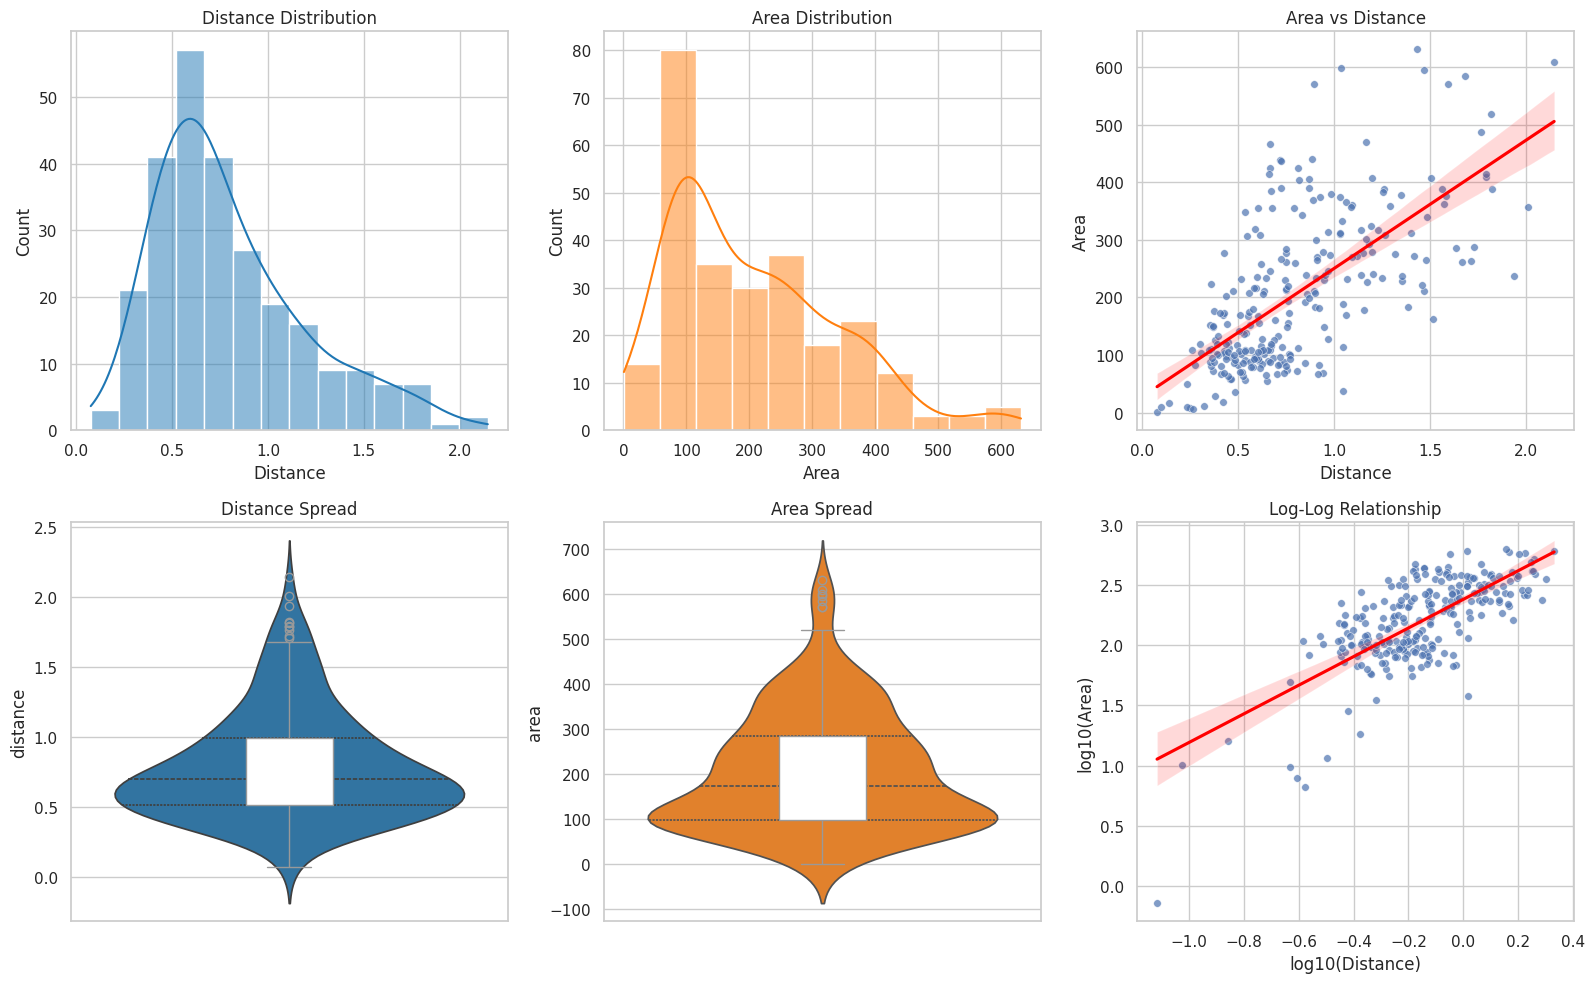

Pearson r: 0.6606 | Spearman rho: 0.6599


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume distances and areas already exist (lists, arrays, or Series)
# Clean data
distances_np = np.asarray(distances_clean, dtype=float)
areas_np     = np.asarray(areas_clean, dtype=float)

mask = np.isfinite(distances_np) & np.isfinite(areas_np)
distances_np = distances_np[mask]
areas_np     = areas_np[mask]

df = pd.DataFrame({
    "distance": distances_np,
    "area": areas_np,
    "log_distance": np.log10(np.clip(distances_np, 1e-12, None)),
    "log_area": np.log10(np.clip(areas_np, 1e-12, None))
})

print("Summary stats:")
print(df[["distance","area"]].describe())

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(16,10))

# 1. Distance distribution
ax1 = plt.subplot2grid((2,3), (0,0))
sns.histplot(df["distance"], kde=True, ax=ax1, color="#1f77b4")
ax1.set_title("Distance Distribution")
ax1.set_xlabel("Distance")
ax1.set_ylabel("Count")

# 2. Area distribution
ax2 = plt.subplot2grid((2,3), (0,1))
sns.histplot(df["area"], kde=True, ax=ax2, color="#ff7f0e")
ax2.set_title("Area Distribution")
ax2.set_xlabel("Area")
ax2.set_ylabel("Count")

# 3. Scatter + trend
ax3 = plt.subplot2grid((2,3), (0,2))
sns.scatterplot(x="distance", y="area", data=df, s=30, alpha=0.7, ax=ax3)
sns.regplot(x="distance", y="area", data=df, scatter=False, ax=ax3, color="red")
ax3.set_title("Area vs Distance")
ax3.set_xlabel("Distance")
ax3.set_ylabel("Area")

# 4. Box / Violin Distance
ax4 = plt.subplot2grid((2,3), (1,0))
sns.violinplot(y="distance", data=df, inner="quartile", ax=ax4, color="#1f77b4")
sns.boxplot(y="distance", data=df, width=0.2, boxprops={"zorder":3}, ax=ax4, color="white")
ax4.set_title("Distance Spread")

# 5. Box / Violin Area
ax5 = plt.subplot2grid((2,3), (1,1))
sns.violinplot(y="area", data=df, inner="quartile", ax=ax5, color="#ff7f0e")
sns.boxplot(y="area", data=df, width=0.2, boxprops={"zorder":3}, ax=ax5, color="white")
ax5.set_title("Area Spread")

# 6. Log-log scatter (if wide dynamic range)
ax6 = plt.subplot2grid((2,3), (1,2))
sns.scatterplot(x="log_distance", y="log_area", data=df, s=30, alpha=0.7, ax=ax6)
sns.regplot(x="log_distance", y="log_area", data=df, scatter=False, ax=ax6, color="red")
ax6.set_title("Log-Log Relationship")
ax6.set_xlabel("log10(Distance)")
ax6.set_ylabel("log10(Area)")

plt.tight_layout()
plt.show()

# Optional: correlation metrics
corr_pearson = df["distance"].corr(df["area"], method="pearson")
corr_spearman = df["distance"].corr(df["area"], method="spearman")
print(f"Pearson r: {corr_pearson:.4f} | Spearman rho: {corr_spearman:.4f}")

In [ ]:
!mkdir test_distance

In [ ]:
# sample 50 files from box_files
boxes_folder = "/content/spigole/boxes/"
boxes_files = list(Path(boxes_folder).glob("*.txt"))
sample_boxes_files = random.sample(boxes_files, 50)

In [ ]:
boxes_folder = "/content/spigole/boxes/"
boxes_files = Path(boxes_folder).glob("*.txt")
distances = []
areas = []

for bf in sample_boxes_files:
    source_img_name = bf.stem
    # get the corrisponding target image from the coupled_images
    for coupled_image in coupled_images :
        if coupled_image[0] == source_img_name :
            target_img_name = coupled_image[1]
            direction = coupled_image[2]
            baseline_code = coupled_image[3]
    label_file_path = f"/content/spigole/boxes/{source_img_name}" + ".txt"

    if baseline_code == 1 :
        lenses = '12'
        focal_length = FOCAL_LENGTH_12
        baseline = 0.06
    elif baseline_code == 3 :
        focal_length = FOCAL_LENGTH_03
        lenses = '03'
        baseline = 0.18

    source_img = cv2.imread("./fish_images/"+ source_img_name +".jpg")
    label_file_path = f"./spigole/boxes/{source_img_name}" + ".txt"
    target_image = cv2.imread("./fish_images/"+ target_img_name +".jpg")

    logit_to_image_coeff = target_image.shape[0]//250
    predictor.set_image(target_image)

    boxes = load_bounding_boxes(label_file_path , image_height= target_image.shape[0] , image_width=target_image.shape[1] )
    stride_logits = np.linspace(5, 80, 20, dtype = int ) # between 5 and 80px distances create 20 logit candidates
    stride_boxes = stride_logits* logit_to_image_coeff

    for i , box in enumerate(boxes) :
        source_logits = np.load(f"/content/spigole/logits/{source_img_name}_{i}.npy")
        source_mask = np.load(f"/content/spigole/masks/{source_img_name}_{i}.npy" ).astype(np.float32).squeeze()

        best_mask , best_box ,  best_score = detect_similar_mask(box , predictor , direction ,source_logits, stride_logits , stride_boxes)
        if best_mask is None :
            print(f'Twin fish not detected in {target_img_name}')

        else :
            try:
                distance , area = calculate_rectified_distance_and_area(source_mask, best_mask , baseline , focal_length , lenses)

                distances.append(distance)
                areas.append(area)
            except:
                print(f'Twin fish not detected in {target_img_name}')
            plot_masks(source_image     = source_img,
                    target_image    = target_image,
                    source_mask     = source_mask,
                    source_box      = box,
                    best_mask       = best_mask,
                    best_box        = best_box,
                    best_score      = best_score,
                    distance        = distance,
                    area            = area,
                    index           = i,
                    show= True)


# Inference su Sagome a terra

In [ ]:
sagome_terra = Path("/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome a terra distanza nota").glob('*.*')

In [ ]:
next(sagome_terra)

PosixPath('/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome a terra distanza nota/0,8metri.jpg')

In [ ]:
source_img_name = next(sagome_terra).stem

In [ ]:
source_img = cv2.imread(next(sagome_terra))


In [ ]:
cd /content/

/content


In [ ]:
!mkdir sagome_singole
sagome_terra = Path("/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome a terra distanza nota").glob('*.*')
for i , f in tqdm(enumerate(sagome_terra)):
    fname = str(f)
    img = cv2.imread(fname)
    print(img.shape)
    height, width = img.shape[:2]
    l1 = img[:height // 2, :width // 2]
    l0 = img[:height // 2, width // 2:]
    l2 = img[height // 2:, :width // 2]
    l3 = img[height // 2:, width // 2:]
    cv2.imwrite(f"./sagome_singole/{f.stem}_l0.jpg", l0)
    cv2.imwrite(f"./sagome_singole/{f.stem}_l1.jpg", l1)
    cv2.imwrite(f"./sagome_singole/{f.stem}_l2.jpg", l2)
    cv2.imwrite(f"./sagome_singole/{f.stem}_l3.jpg", l3)

0it [00:00, ?it/s]

(9152, 6944, 3)


1it [00:02,  2.95s/it]

(9152, 6944, 3)


2it [00:06,  3.20s/it]

(9152, 6944, 3)


3it [00:10,  3.43s/it]

(8000, 6000, 3)


5it [00:15,  3.08s/it]

(8000, 6000, 3)


5it [00:15,  3.15s/it]


# 80 cm

lente 0

In [ ]:
target_image = cv2.imread("/content/sagome_singole/0,8metri_l0.jpg")
predictor.set_image(target_image)

In [ ]:
x_min = 1450
y_min = 1450
x_max = 2500
y_max = 1900
box1 = [x_min , y_min , x_max , y_max]
masks00 , score00, logits00 = predictor.predict(box=[box1])
masks00 = masks00[np.argmax(score00)]

In [ ]:
score00

array([0.96875  , 0.9609375, 0.9765625], dtype=float32)

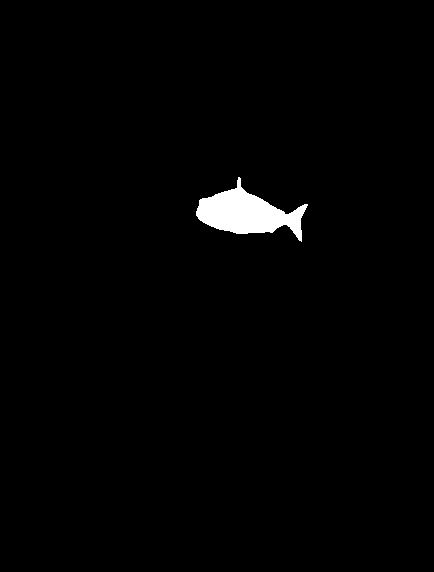

In [ ]:
cv2_imshow(masks00[::8,::8]*255)

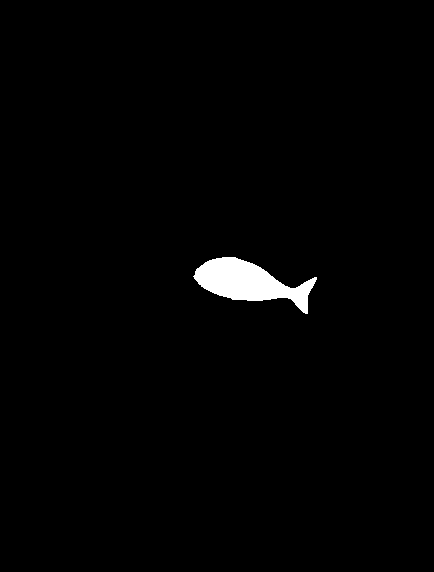

In [ ]:
x_min = 1450
y_min = 2000
x_max = 2500
y_max = 2500
box1 = [x_min , y_min , x_max , y_max]
masks01 , score01, logits01 = predictor.predict(box=[box1])
masks01 = masks01[1]
cv2_imshow(masks01[::8,::8]*255)

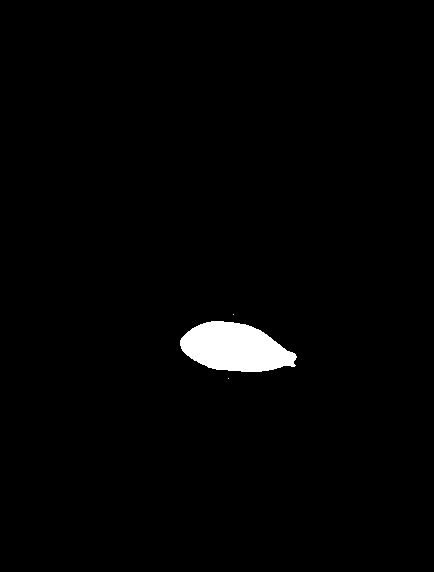

In [ ]:
x_min = 1450
y_min = 2500
x_max = 2500
y_max = 3000
box1 = [x_min , y_min , x_max , y_max]
masks02 , score02, logits02 = predictor.predict(box=[box1])
masks02 = masks02[np.argmax(score02)]
cv2_imshow(masks02[::8,::8]*255)

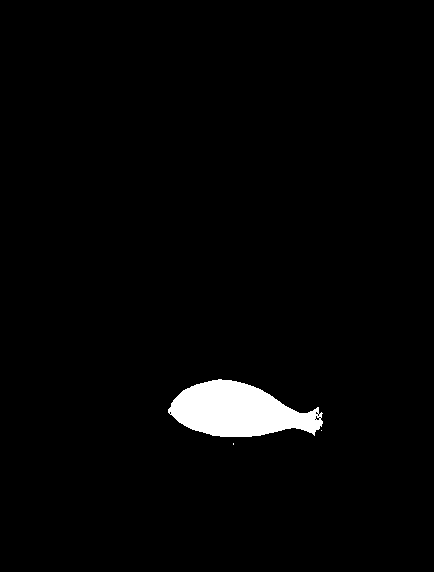

In [ ]:
x_min = 1450
y_min = 3000
x_max = 2500
y_max = 3500
box1 = [x_min , y_min , x_max , y_max]
masks03 , score03, logits03 = predictor.predict(box=[box1])
masks03 = masks03[np.argmax(score03)]
cv2_imshow(masks03[::8,::8]*255)

lente 1

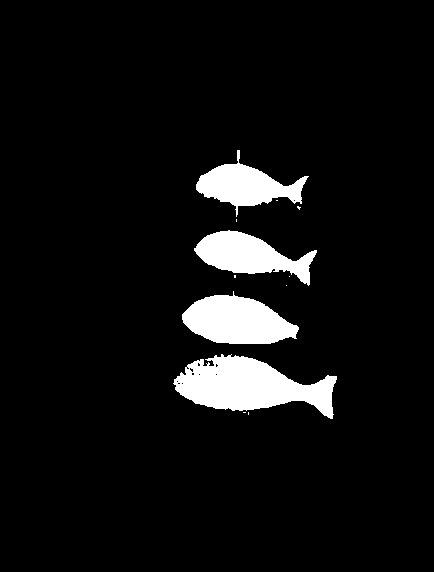

In [ ]:
target_image = cv2.imread("/content/sagome_singole/0,8metri_l1.jpg")
predictor.set_image(target_image)
masks , score, logits = predictor.predict()
cv2_imshow(masks[2][::8,::8]*255)

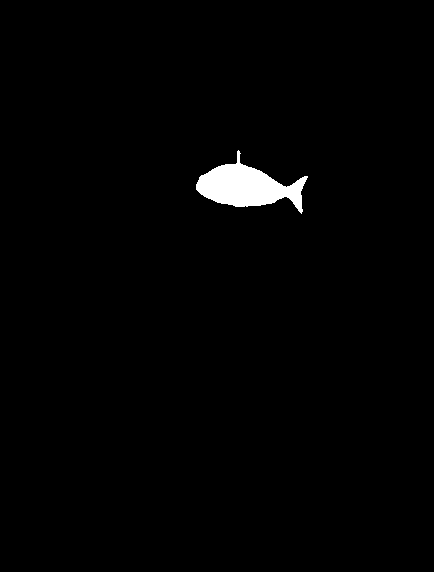

In [ ]:
x_min = 1530
y_min = 1244
x_max = 2500
y_max = 1700
box1 = [x_min , y_min , x_max , y_max]
masks10, score10, logits10 = predictor.predict(box=[box1])
masks10 = masks10[np.argmax(score10)]
cv2_imshow(masks10[::8,::8]*255)

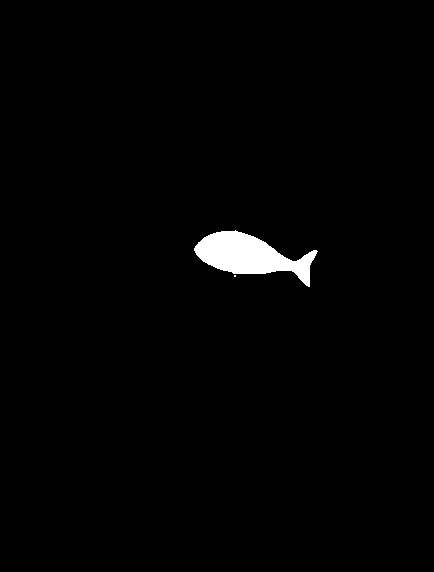

In [ ]:
x_min = 1530
y_min = 1800
x_max = 2500
y_max = 2290
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks11, score11, logits11 = predictor.predict(box=[box1])
masks11 = masks11[np.argmax(score11)]
cv2_imshow(masks11[::8,::8]*255)

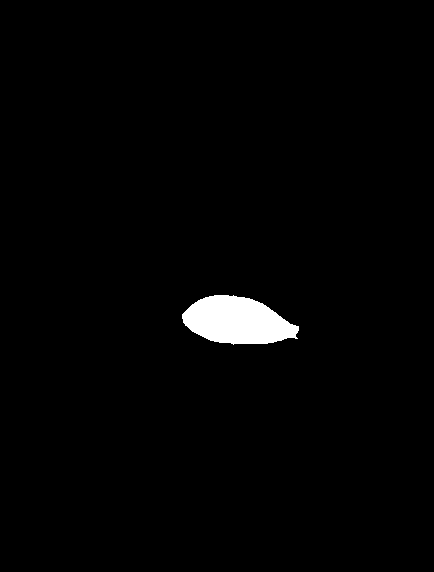

In [ ]:
x_min = 1530
y_min = 2340
x_max = 2500
y_max = 2770
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks12, score12, logits12 = predictor.predict(box=[box1])
masks12 = masks12[np.argmax(score12)]
cv2_imshow(masks12[::8,::8]*255)

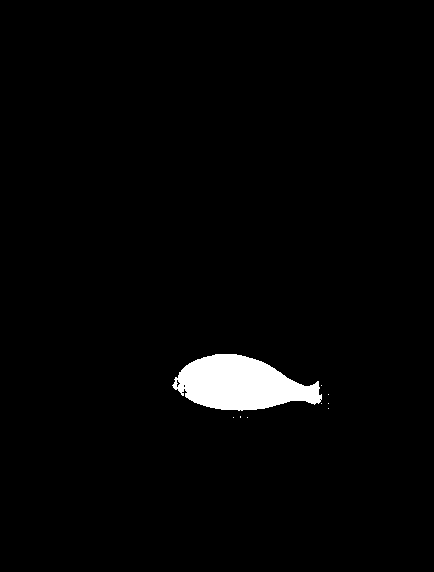

In [ ]:
x_min = 1530
y_min = 2840
x_max = 2500
y_max = 3300
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks13, score13, logits13 = predictor.predict(box=[box1])
masks13 = masks13[np.argmax(score13)]
cv2_imshow(masks13[::8,::8]*255)

lens2

In [ ]:
target_image = cv2.imread("/content/sagome_singole/0,8metri_l2.jpg")
predictor.set_image(target_image)
masks , score, logits = predictor.predict()

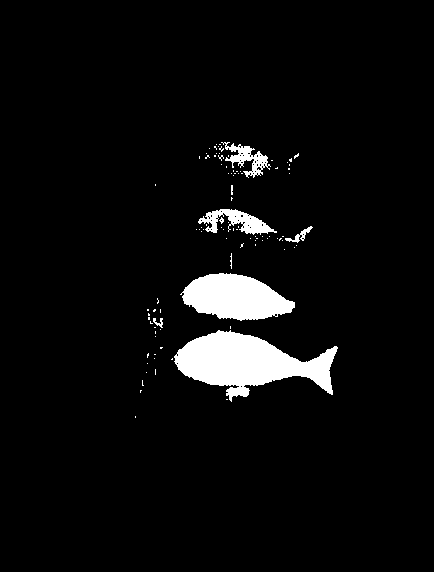

In [ ]:
cv2_imshow(masks[0][::8,::8]*255)

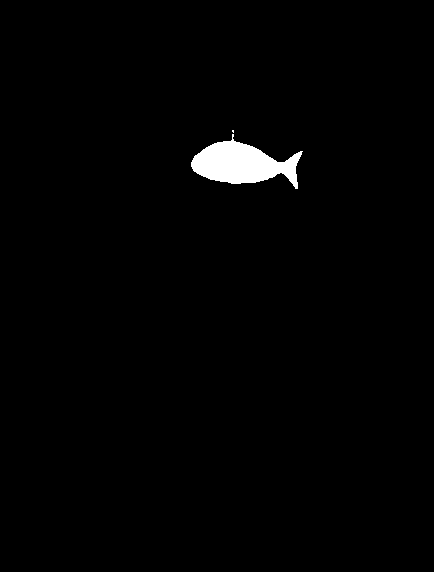

In [ ]:
x_min = 1530
y_min = 1130
x_max = 2500
y_max = 1460
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks20, score20, logits20 = predictor.predict(box=[box1])
masks20 = masks20[np.argmax(score20)]
cv2_imshow(masks20[::8,::8]*255)


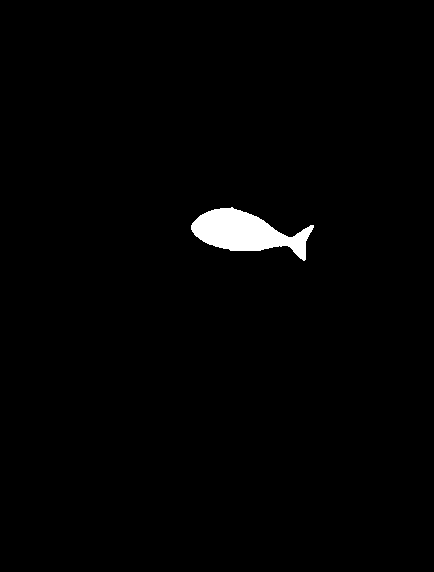

In [ ]:
x_min = 1530
y_min = 1631
x_max = 2500
y_max = 2000
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks21, score21, logits21 = predictor.predict(box=[box1])
masks21 = masks21[np.argmax(score21)]
cv2_imshow(masks21[::8,::8]*255)


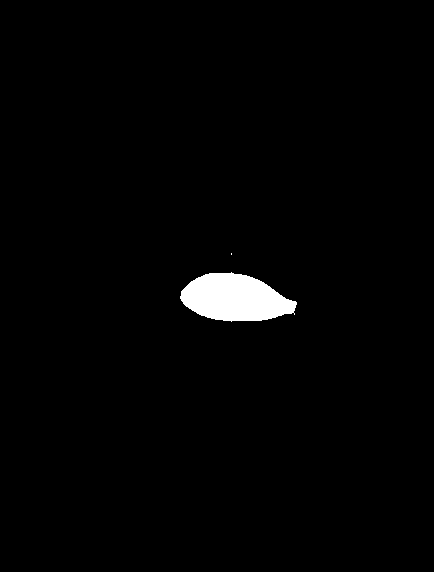

In [ ]:
x_min = 1530
y_min = 2100
x_max = 2500
y_max = 2650
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks22, score22, logits22 = predictor.predict(box=[box1])
masks22 = masks22[np.argmax(score22)]
cv2_imshow(masks22[::8,::8]*255)

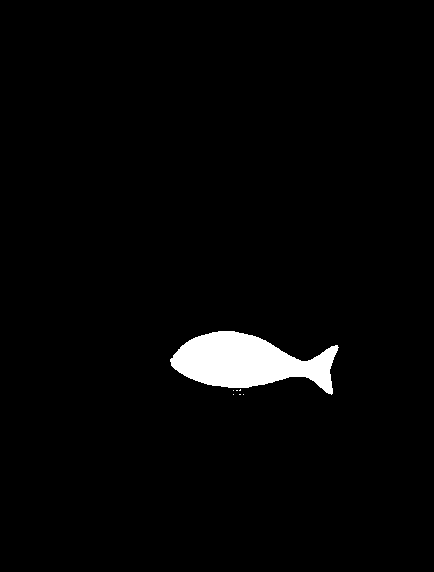

In [ ]:
x_min = 1330
y_min = 2650
x_max = 2700
y_max = 3091
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks23, score23, logits23 = predictor.predict(box=[box1])
masks23 = masks23[np.argmax(score23)]
cv2_imshow(masks23[::8,::8]*255)

lens 3

In [ ]:
target_image = cv2.imread("/content/sagome_singole/0,8metri_l3.jpg")
predictor.set_image(target_image)
masks , score, logits = predictor.predict()

In [ ]:
cv2_imshow(masks[0]*255)

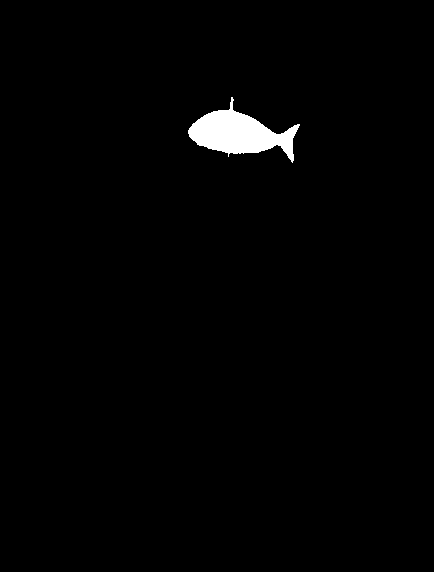

In [ ]:
x_min = 1330
y_min = 870
x_max = 2700
y_max = 1244
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks30, score30, logits30 = predictor.predict(box=[box1])
masks30 = masks30[np.argmax(score30)]
cv2_imshow(masks30[::8,::8]*255)

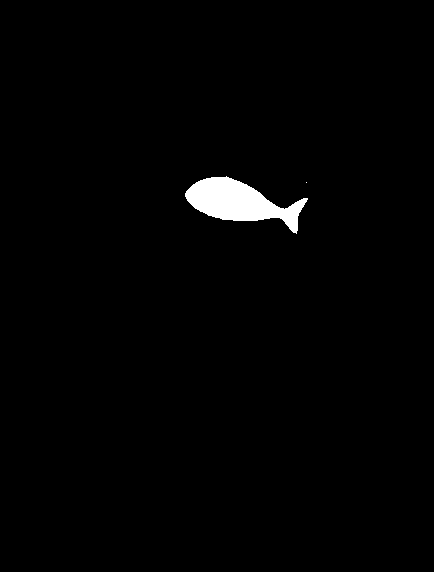

In [ ]:
x_min = 1330
y_min = 1379
x_max = 2700
y_max = 1784
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks31, score31, logits31 = predictor.predict(box=[box1])
masks31 = masks31[np.argmax(score31)]
cv2_imshow(masks31[::8,::8]*255)

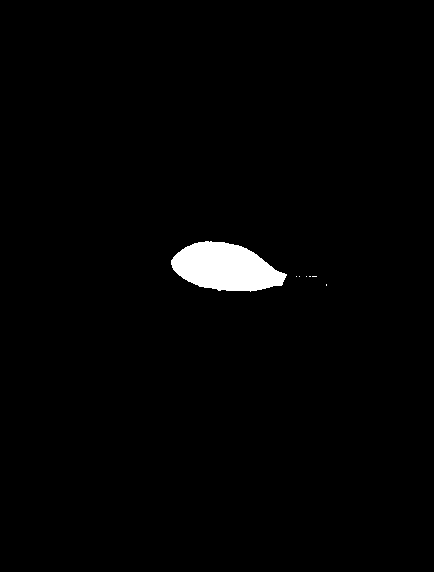

In [ ]:
x_min = 1330
y_min = 1900
x_max = 2700
y_max = 2315
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks32, score32, logits32 = predictor.predict(box=[box1])
masks32 = masks32[np.argmax(score32)]
cv2_imshow(masks32[::8,::8]*255)

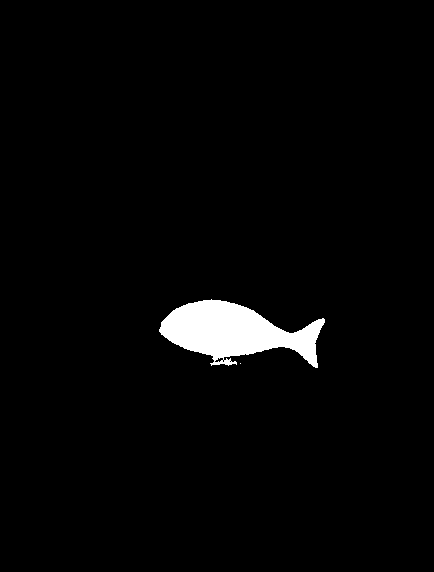

In [ ]:
x_min = 1330
y_min = 2400
x_max = 2700
y_max = 2900
box1 = [x_min , y_min , x_max , y_max]
# mask {lens} {sagoma n}
masks33, score33, logits33 = predictor.predict(box=[box1])
masks33 = masks33[np.argmax(score33)]
cv2_imshow(masks33[::8,::8]*255)

# calcolo distanza delle sagome sulle coppie di lenti 1-2 e 0-3

### load the coefficients for lenti 1-2

In [ ]:
!unzip "/content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_12.zip" -d ./

calibration_dir = "/content/calibration_results_12"

left_lens = 'left'
right_lens = 'right'
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
def calculate_rectified_distance(left_mask, right_mask, baseline , focal_length ):

    height , width = 2312 , 1736

    left_mask = cv2.resize(left_mask , dsize = (width , height))
    left_mask = cv2.rotate(left_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
    temp_undistorted_left_mask = cv2.remap(
        left_mask,
        left_map_x_rectify,
        left_map_y_rectify,
        interpolation=cv2.INTER_NEAREST,  # nearest is best for binary masks
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )

    right_mask = cv2.resize(right_mask , dsize = (width , height))
    right_mask = cv2.rotate(right_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
    temp_undistorted_right_mask = cv2.remap(
        right_mask,
        right_map_x_rectify,
        right_map_y_rectify,
        interpolation=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )
    horizontal_shift = np.mean((abs(get_mask_centroid_difference(temp_undistorted_left_mask, temp_undistorted_right_mask )[0]), abs(estimate_mask_shift(temp_undistorted_left_mask , temp_undistorted_right_mask)[1])))


    distance = baseline * focal_length / abs(horizontal_shift)
    return distance


In [ ]:
def calculate_rectified_area(left_mask, right_mask, distance ,focal_length  ):

    height , width = 2312 , 1736


    left_mask = cv2.resize(left_mask , dsize = (width , height))
    left_mask = cv2.rotate(left_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
    temp_undistorted_left_mask = cv2.remap(
        left_mask,
        left_map_x_rectify,
        left_map_y_rectify,
        interpolation=cv2.INTER_NEAREST,  # nearest is best for binary masks
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )

    right_mask = cv2.resize(right_mask , dsize = (width , height))
    right_mask = cv2.rotate(right_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
    temp_undistorted_right_mask = cv2.remap(
        right_mask,
        right_map_x_rectify,
        right_map_y_rectify,
        interpolation=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )

    area = pixel_area_to_cm2(np.mean((int(temp_undistorted_left_mask.sum()) , int(temp_undistorted_right_mask.sum()))) , distance , focal_length )


    return area

In [ ]:
# read calibration_results.json
import json
with open("/content/calibration_results_12/calibration_results.json", "r") as f:
    calibration_results = json.load(f)
FOCAL_LENGTH = calibration_results['left_P'][0][0]
BASELINE = -calibration_results['right_P'][0][3]/FOCAL_LENGTH

In [ ]:
FOCAL_LENGTH = calibration_results['left_P'][0][0]
BASELINE = -calibration_results['right_P'][0][3]/FOCAL_LENGTH

In [ ]:
BASELINE

3.5872527255488618

In [ ]:
distance = calculate_rectified_distance(masks10 , masks20 , 0.06 , FOCAL_LENGTH )

In [ ]:
calculate_rectified_area(masks10 , masks20 ,distance,FOCAL_LENGTH )

np.float64(185.51566895318234)

In [ ]:
np.sum(masks10) , np.sum(masks20)

(np.float32(208405.0), np.float32(205467.0))

In [ ]:
distance =calculate_rectified_distance(masks11 , masks21 , 0.06 , FOCAL_LENGTH )

In [ ]:
calculate_rectified_area(masks11 , masks21  ,distance,FOCAL_LENGTH )

np.float64(195.43007391276717)

In [ ]:
distance =calculate_rectified_distance(masks12 , masks22  , 0.06 , FOCAL_LENGTH )

In [ ]:
calculate_rectified_area(masks12 , masks22  ,distance,FOCAL_LENGTH )

np.float64(251.96082994351536)

In [ ]:
distance = calculate_rectified_distance(masks13 , masks23, 0.06 , FOCAL_LENGTH )

In [ ]:
calculate_rectified_area(masks13 , masks23  ,distance,FOCAL_LENGTH )

np.float64(423.03820972724145)

### lenti 0-3

In [ ]:
!unzip "/content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_03.zip" -d ./calibration_results_03/

Archive:  /content/drive/MyDrive/2023_24 Prototype 2.0/CALIBRAZIONE SCACCHIERA/Coefficienti Camera/V2_calibration_results_03.zip
   creating: ./calibration_results_03/content/calibration_results_03/
  inflating: ./calibration_results_03/content/calibration_results_03/calibration_results.json  
  inflating: ./calibration_results_03/content/calibration_results_03/calibration_right.npz  
  inflating: ./calibration_results_03/content/calibration_results_03/calibration_left.npz  
  inflating: ./calibration_results_03/content/calibration_results_03/stereo_calibration.npz  


In [ ]:
calibration_dir = "/content/calibration_results_03/"

In [ ]:
left_lens = 'left'
right_lens = 'right'
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
# read calibration_results.json
import json
with open("/content/calibration_results_03/calibration_results.json", "r") as f:
    calibration_results = json.load(f)

In [ ]:
FOCAL_LENGTH = calibration_results['left_P'][0][0]
BASELINE = -calibration_results['right_P'][0][3]/FOCAL_LENGTH

In [ ]:
FOCAL_LENGTH

1527.3789505020002

In [ ]:
BASELINE

8.187075085012406

In [ ]:
distance = calculate_rectified_distance(masks01 , masks31 , .18 , FOCAL_LENGTH)
print(distance)

0.9151037609746592


In [ ]:
calculate_rectified_area(masks01 , masks31 , distance,FOCAL_LENGTH )

np.float64(191.08203676864463)

In [ ]:
distance =  calculate_rectified_distance(masks02 , masks32 , .18 , FOCAL_LENGTH)
print(distance)

1.2624656512779644


In [ ]:
calculate_rectified_area(masks02 , masks32  , distance , FOCAL_LENGTH )

np.float64(463.3710945429531)

In [ ]:
distance =calculate_rectified_distance(masks03 , masks33 , .18  , FOCAL_LENGTH)
print(distance)

1.4019735649781921


In [ ]:
calculate_rectified_area(masks03 , masks33 , _)

np.float64(828.9605661058619)

In [ ]:
distance = calculate_rectified_distance(masks00 , masks30 , .18 , FOCAL_LENGTH)
print(distance)

1.4838021829591737


In [ ]:
calculate_rectified_area(masks00 , masks30 , distance , FOCAL_LENGTH )

np.float64(468.356370307332)

In [ ]:
masks00.shape

(4576, 3472)

In [ ]:
width , height = 1736 , 2312

In [ ]:
masks00
left_mask = cv2.resize(masks00 , dsize = (width , height))

In [ ]:
left_mask.shape

(2312, 1736)

In [ ]:
left_mask = cv2.rotate(left_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [ ]:
cv2_imshow(left_mask*255)

In [ ]:
temp_undistorted_left_mask = cv2.remap(
    left_mask,
    left_map_x_rectify,
    left_map_y_rectify,
    interpolation=cv2.INTER_NEAREST,  # nearest is best for binary masks
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)

In [ ]:
cv2_imshow(temp_undistorted_left_mask*255)

In [ ]:
right_mask = cv2.resize(masks10 , dsize = (width , height))
right_mask = cv2.rotate(right_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
temp_undistorted_right_mask = cv2.remap(
    right_mask,
    right_map_x_rectify,
    right_map_y_rectify,
    interpolation=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)

In [ ]:
cv2_imshow(temp_undistorted_right_mask*255)

In [ ]:
height , width = 2312 , 1736


left_mask = cv2.resize(left_mask , dsize = (width , height))
left_mask = cv2.rotate(left_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
temp_undistorted_left_mask = cv2.remap(
    left_mask,
    left_map_x_rectify,
    left_map_y_rectify,
    interpolation=cv2.INTER_NEAREST,  # nearest is best for binary masks
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)

right_mask = cv2.resize(right_mask , dsize = (width , height))
right_mask = cv2.rotate(right_mask , cv2.ROTATE_90_COUNTERCLOCKWISE)
temp_undistorted_right_mask = cv2.remap(
    right_mask,
    right_map_x_rectify,
    right_map_y_rectify,
    interpolation=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)

# 1 m

lente 0

In [ ]:
target_image = cv2.imread("/content/sagome_singole/1metro_l0.jpg")
predictor.set_image(target_image)


In [ ]:
x_min = 1580
y_min = 1340
x_max = 2830
y_max = 1680
box1 = [x_min , y_min , x_max , y_max]
masks00 , score00, logits00 = predictor.predict(box=[box1])

x_min = 1580
y_min = 1680
x_max = 2830
y_max = 2000
box1 = [x_min , y_min , x_max , y_max]
masks01 , score01, logits01 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2000
x_max = 2830
y_max = 2500
box1 = [x_min , y_min , x_max , y_max]
masks02 , score02, logits02 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2500
x_max = 2830
y_max = 3000
box1 = [x_min , y_min , x_max , y_max]
masks03 , score03, logits03 = predictor.predict(box=[box1])

### lens 1

In [ ]:
target_image = cv2.imread("/content/sagome_singole/1metro_l1.jpg")
predictor.set_image(target_image)
delta = 1340 -1150 # difference between len0 and lens1

In [ ]:
x_min = 1580
y_min = 1340 - delta
x_max = 2830
y_max = 1680 - delta
box1 = [x_min , y_min , x_max , y_max]
masks10 , score10, logits10 = predictor.predict(box=[box1])

x_min = 1580
y_min = 1680 - delta
x_max = 2830
y_max = 2000 - delta
box1 = [x_min , y_min , x_max , y_max]
masks11 , score11, logits11 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2000 - delta
x_max = 2830
y_max = 2500 - delta
box1 = [x_min , y_min , x_max , y_max]
masks12 , score12, logits12 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2500 - delta
x_max = 2830
y_max = 3000 - delta
box1 = [x_min , y_min , x_max , y_max]
masks13 , score13, logits13 = predictor.predict(box=[box1])

### lens 2

In [ ]:
target_image = cv2.imread("/content/sagome_singole/1metro_l2.jpg")
predictor.set_image(target_image)

In [ ]:
x_min = 1580
y_min = 1340 - 2*delta
x_max = 2830
y_max = 1680 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks20 , score20, logits20 = predictor.predict(box=[box1])

x_min = 1580
y_min = 1680 - 2*delta
x_max = 2830
y_max = 2000 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks21 , score21, logits21 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2000 - 2*delta
x_max = 2830
y_max = 2500 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks22 , score22, logits22 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2500 -2*delta
x_max = 2830
y_max = 3000 -2*delta
box1 = [x_min , y_min , x_max , y_max]
masks23 , score23, logits23 = predictor.predict(box=[box1])

### lens 3

In [ ]:
target_image = cv2.imread("/content/sagome_singole/1metro_l3.jpg")
predictor.set_image(target_image)

In [ ]:
x_min = 1580
y_min = 1340 - 3*delta
x_max = 2830
y_max = 1680 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks30 , score30, logits30 = predictor.predict(box=[box1])

x_min = 1580
y_min = 1680 - 3*delta
x_max = 2830
y_max = 2000 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks31 , score31, logits31 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2000 - 3*delta
x_max = 2830
y_max = 2500 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks32, score32, logits32 = predictor.predict(box=[box1])

x_min = 1580
y_min = 2500 - 3*delta
x_max = 2830
y_max = 3000 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks33 , score33, logits33 = predictor.predict(box=[box1])

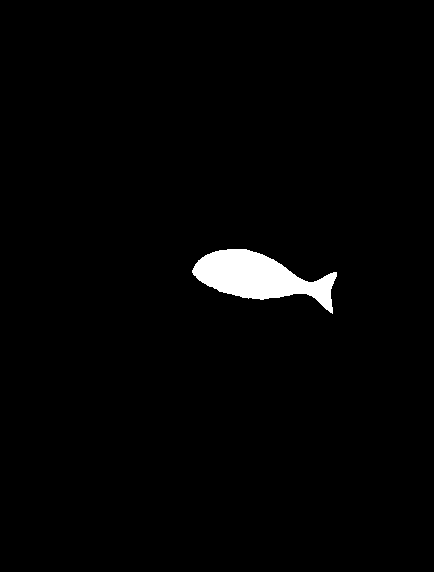

In [ ]:
cv2_imshow(masks33[np.argmax(score33)][::8,::8]*255)

### calcolo distanza a 1 metro

In [ ]:
left_lens = 1
right_lens = 2
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration_{}_{}.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
masks10 = masks10[np.argmax(score10)]
masks11 = masks11[np.argmax(score11)]
masks12 = masks12[np.argmax(score12)]
masks13 = masks13[np.argmax(score13)]

masks20 = masks20[np.argmax(score20)]
masks21 = masks21[np.argmax(score21)]
masks22 = masks22[np.argmax(score22)]
masks23 = masks23[np.argmax(score23)]

In [ ]:
calculate_rectified_distance(masks10 , masks20 , .06 )

np.float64(0.9764017441195391)

In [ ]:
calculate_rectified_area(masks10 , masks20 , _)

np.float64(253.0935401178087)

In [ ]:
calculate_rectified_distance(masks11 , masks21 , .06 )

np.float64(0.917995238724868)

In [ ]:
calculate_rectified_area(masks11 , masks21 , _)

np.float64(256.92716724884554)

In [ ]:
calculate_rectified_distance(masks12 , masks22 , .06 )

np.float64(0.9333235513704099)

In [ ]:
calculate_rectified_area(masks12 , masks22 , _)

np.float64(364.8547211785826)

In [ ]:
calculate_rectified_distance(masks13 , masks23 , .06 )

np.float64(0.9160008149051402)

In [ ]:
calculate_rectified_area(masks13 , masks23 , _)

np.float64(543.7404600211637)

In [ ]:
left_lens = 0
right_lens = 3
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration_{}_{}.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
masks00 = masks00[np.argmax(score00)]
masks01 = masks01[np.argmax(score01)]
masks02 = masks02[np.argmax(score02)]
masks03 = masks03[np.argmax(score03)]

masks30 = masks30[np.argmax(score30)]
masks31 = masks31[np.argmax(score31)]
masks32 = masks32[np.argmax(score32)]
masks33 = masks33[np.argmax(score33)]

In [ ]:
calculate_rectified_distance(masks00 , masks30 , .18 )

np.float64(0.6861172598652502)

In [ ]:
calculate_rectified_distance(masks01 , masks31 , .18 )

np.float64(0.6979153867922134)

In [ ]:
calculate_rectified_distance(masks02 , masks32 , .18 )

np.float64(0.6325566913100308)

In [ ]:
cv2_imshow(masks02[::8,::8]*255)

In [ ]:
cv2_imshow(masks32[::8,::8]*255)

In [ ]:
calculate_rectified_distance(masks03 , masks33 , .18 )

np.float64(0.9585528605516082)

In [ ]:
cv2_imshow(masks03[::8,::8]*255)

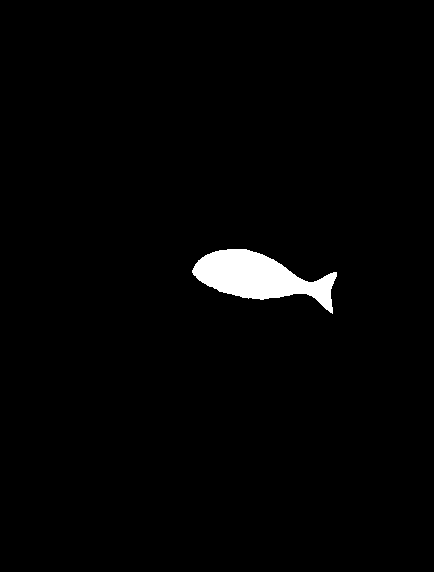

In [ ]:
cv2_imshow(masks33[::8,::8]*255)

In [ ]:
calculate_rectified_distance(masks01[0] , masks31[0] , .18 )*3

np.float64(0.7860295693550761)

In [ ]:
calculate_rectified_distance(masks02[0] , masks32[0] , .18 )*3

np.float64(1.1771659403705361)

In [ ]:
calculate_rectified_distance(masks03[0] , masks33[0] , .18 )*3

np.float64(1.0655057779868693)

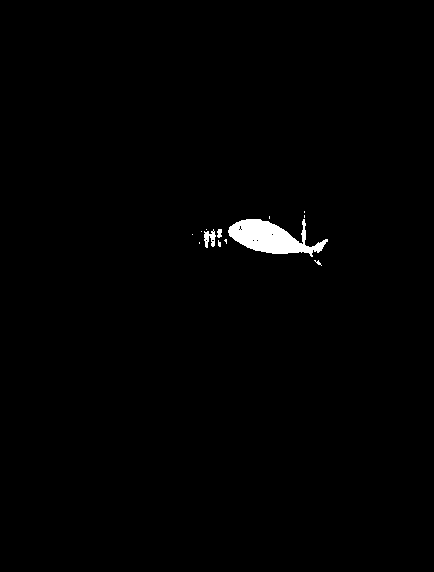

In [ ]:
cv2_imshow(masks01[0][::8,::8]*255)


# metri 2,5

In [ ]:
target_image = cv2.imread("/content/sagome_singole/metri25_l0.jpg")
predictor.set_image(target_image)

In [ ]:
delta = 0
x_min = 1504
y_min = 1811 - delta
x_max = 2126
y_max = 1965 - delta
box1 = [x_min , y_min , x_max , y_max]
masks00 , score00, logits00 = predictor.predict(box=[box1])

x_min = 1504
y_min = 1981 - delta
x_max = 2126
y_max = 2175 - delta
box1 = [x_min , y_min , x_max , y_max]
masks01 , score01, logits01 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2175 - delta
x_max = 2387
y_max = 2400 - delta
box1 = [x_min , y_min , x_max , y_max]
box1 = [x_min , y_min , x_max , y_max]
masks02, score02, logits02 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2400 - delta
x_max = 2387
y_max = 2600 - delta
box1 = [x_min , y_min , x_max , y_max]
masks03 , score03, logits03 = predictor.predict(box=[box1])

In [ ]:
target_image = cv2.imread("/content/sagome_singole/metri25_l1.jpg")
predictor.set_image(target_image)
delta = 1811 - 1730

In [ ]:
x_min = 1504
y_min = 1811 - delta
x_max = 2126
y_max = 1965 - delta
box1 = [x_min , y_min , x_max , y_max]
masks10 , score10, logits10 = predictor.predict(box=[box1])

x_min = 1504
y_min = 1981 - delta
x_max = 2126
y_max = 2175 - delta
box1 = [x_min , y_min , x_max , y_max]
masks11 , score11, logits11 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2175 - delta
x_max = 2387
y_max = 2400 - delta
box1 = [x_min , y_min , x_max , y_max]
box1 = [x_min , y_min , x_max , y_max]
masks12, score12, logits12 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2400 - delta
x_max = 2387
y_max = 2600 - delta
box1 = [x_min , y_min , x_max , y_max]
masks13 , score13, logits13 = predictor.predict(box=[box1])

In [ ]:
target_image = cv2.imread("/content/sagome_singole/metri25_l2.jpg")
predictor.set_image(target_image)

In [ ]:
x_min = 1504
y_min = 1811 - 2*delta
x_max = 2126
y_max = 1965 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks20 , score20, logits20 = predictor.predict(box=[box1])

x_min = 1504
y_min = 1981 - 2*delta
x_max = 2126
y_max = 2175 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks21 , score21, logits21 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2175 - 2*delta
x_min = 2387
y_max = 2400 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks22, score22, logits22 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2400 - 2*delta
x_max = 2387
y_max = 2600 - 2*delta
box1 = [x_min , y_min , x_max , y_max]
masks23 , score23, logits23 = predictor.predict(box=[box1])

In [ ]:
target_image = cv2.imread("/content/sagome_singole/metri25_l3.jpg")
predictor.set_image(target_image)

In [ ]:
x_min = 1504
y_min = 1811 - 3*delta
x_max = 2126
y_max = 1965 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks30 , score30, logits30 = predictor.predict(box=[box1])

x_min = 1504
y_min = 1981 - 3*delta
x_max = 2126
y_max = 2175 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks31 , score31, logits31 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2175 - 3*delta
x_min = 2387
y_max = 2400 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks32, score32, logits32 = predictor.predict(box=[box1])

x_min = 1504
y_min = 2400 - 3*delta
x_max = 2387
y_max = 2600 - 3*delta
box1 = [x_min , y_min , x_max , y_max]
masks33 , score33, logits33 = predictor.predict(box=[box1])

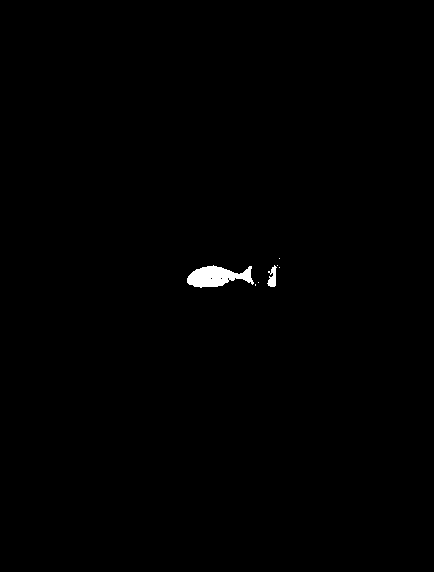

In [ ]:
cv2_imshow(masks33[2][::8,::8]*255)

# calcolo distanza a 2,5 metro

In [ ]:
left_lens = 1
right_lens = 2
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration_{}_{}.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
masks10 = masks10[np.argmax(score10)]
masks11 = masks11[np.argmax(score11)]
masks12 = masks12[np.argmax(score12)]
masks13 = masks13[np.argmax(score13)]

masks20 = masks20[np.argmax(score20)]
masks21 = masks21[np.argmax(score21)]
masks22 = masks22[np.argmax(score22)]
masks23 = masks23[np.argmax(score23)]

In [ ]:
calculate_rectified_distance(masks10 , masks20 , .06 )

np.float64(6.239351459568032)

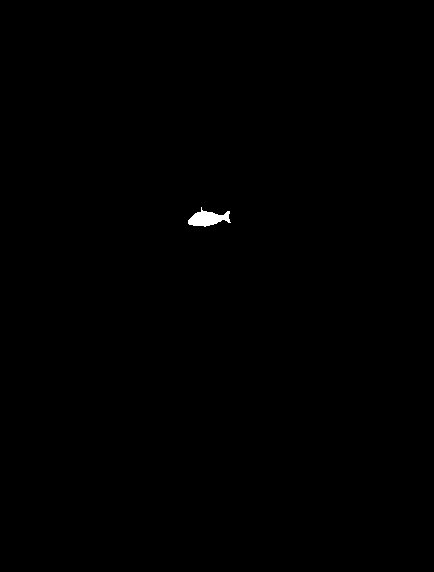

In [ ]:
cv2_imshow(masks20[::8,::8]*255)

In [ ]:
calculate_rectified_distance(masks11 , masks21 , .06 )

np.float64(5.161902459637823)

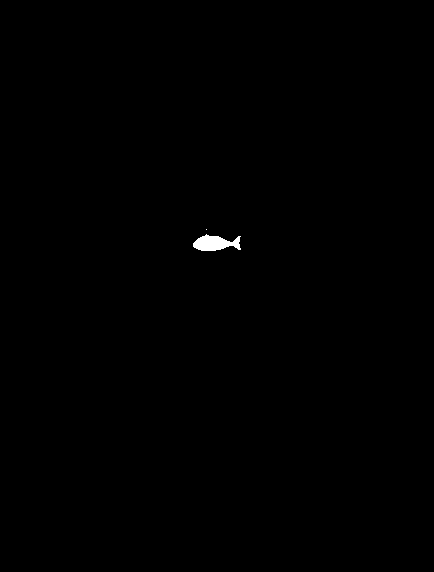

In [ ]:
cv2_imshow(masks21[::8,::8]*255)

In [ ]:
calculate_rectified_distance(masks12 , masks22 , .06 )

np.float64(2.7304567200379424)

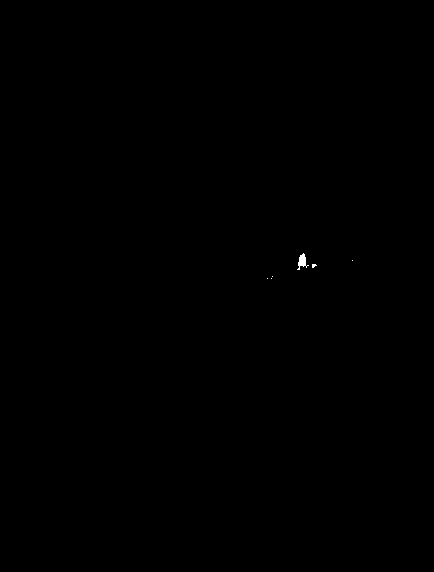

In [ ]:
cv2_imshow(masks22[::8,::8]*255)


In [ ]:
calculate_rectified_distance(masks13 , masks23 , .06 )

np.float64(4.056179532937534)

In [ ]:
left_lens = 0
right_lens = 3
left_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,left_lens ))
right_npzfile = np.load("{}/calibration_{}.npz".format(calibration_dir ,right_lens))
stereo_npzfile = np.load("{}/stereo_calibration_{}_{}.npz".format(calibration_dir , left_lens , right_lens))

# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

In [ ]:
masks00 = masks00[np.argmax(score00)]
masks01 = masks01[np.argmax(score01)]
masks02 = masks02[np.argmax(score02)]
masks03 = masks03[np.argmax(score03)]

masks30 = masks30[np.argmax(score30)]
masks31 = masks31[np.argmax(score31)]
masks32 = masks32[np.argmax(score32)]
masks33 = masks33[np.argmax(score33)]

In [ ]:
calculate_rectified_distance(masks00 , masks30 , .18 )

np.float64(2.2208168635967347)

In [ ]:
calculate_rectified_distance(masks01 , masks31 , .18 )

np.float64(1.4527104315012769)

In [ ]:
calculate_rectified_distance(masks02 , masks32 , .18 )

np.float64(2.973771528738412)

In [ ]:
calculate_rectified_distance(masks03 , masks33 , .18 )

np.float64(1.7281324272798062)

In [ ]:
def visualize_mask_shift(original_mask, shifted_mask):
    """
    Visualize the original mask and a shifted version with estimated shift values.

    Args:
        original_mask: The original binary mask
        shifted_mask: The shifted version of the mask
    """
    # Ensure masks are binary
    original_bin = _binarize(original_mask)
    shifted_bin = _binarize(shifted_mask)

    # Calculate shift
    dy, dx, score, method = estimate_mask_shift(original_bin, shifted_bin)

    # Create visualization image
    original_color = np.zeros((original_bin.shape[0], original_bin.shape[1], 3), dtype=np.uint8)
    shifted_color = np.zeros_like(original_color)

    # Original mask in red
    original_color[original_bin > 0] = [0, 0, 255]  # Red in BGR

    # Shifted mask in green
    shifted_color[shifted_bin > 0] = [0, 255, 0]    # Green in BGR

    # Combine with overlay
    combined = cv2.addWeighted(original_color, 0.7, shifted_color, 0.7, 0)

    # Add text for shift values
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"dy={dy:.1f}, dx={dx:.1f}, method={method}"
    cv2.putText(combined, text, (10, 50), font, .7, (255, 255, 255), 20)

    # Display with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Mask Shift Visualization - Score={score:.3f}")
    plt.show()

    return dy, dx, score, method



In [ ]:
result = visualize_mask_shift(source_mask, best_mask)

In [ ]:
print(f"Estimated shift: dy={result[0]}, dx={result[1]}")

Estimated shift: dy=-332.0, dx=-60.139061102059145


In [ ]:
result = visualize_mask_shift(temp_undistorted_source_mask, temp_undistorted_target_mask)

In [ ]:
print(f"Estimated shift: dy={result[0]}, dx={result[1]}")

Estimated shift: dy=54.0, dx=71.42251970862488


# Sagome in acqua

In [ ]:
!ls

calibration_results_03	drive	fish_images  sample_data  test_distance
calibration_results_12	fishai	sam2	     spigole


In [ ]:
sagome_acqua = Path("/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome singole acqua").glob('*.jpg')

In [ ]:
points = Path("/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome singole acqua").glob('*.csv')
# read with pandas and assign colmuns = ['type' , x , y , fname , dimx , dimy ]
points_df = pd.read_csv(next(points) , names = ['type' , 'x' , 'y' , 'fname' , 'dimx' , 'dimy'] )

In [ ]:
points_df.tail()

type     x     y                   fname  dimx  dimy
699  POINT  1311  3881  1696500421photo_l2.jpg  3472  4576
700  POINT  1562  3504  1696500421photo_l3.jpg  3472  4576
701  POINT  1574  2797  1696500421photo_l3.jpg  3472  4576
702  POINT  1688  2072  1696500421photo_l3.jpg  3472  4576
703  POINT  1838  1372  1696500421photo_l3.jpg  3472  4576

In [ ]:
points_df.head()

In [ ]:
img_folder = "/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/Sagome singole acqua/"

In [ ]:
_ , x , y, fname , dimx , dimy = points_df.iloc[0,:]
#open image with cv2
# Example row (e.g., index 700)


# Load image
target_image = cv2.imread(img_folder+fname)  # Convert BGR -> RGB if needed

# Set image for predictor
predictor.set_image(target_image)

# Extract the point
input_point = [[x, y]]   # SAM expects [[x, y]]
input_label = [1]  # 1 = foreground (positive point)

# Run prediction
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True  # or False if you only want one mask
)

In [ ]:
# show the best mask according to scores
best_mask = masks[np.argmax(scores)]
cv2_imshow(best_mask[::8,::8]*255)

In [ ]:
!rm -rf sagome_acqua

In [ ]:
!mkdir sagome_acqua

In [ ]:
for i in range(len(points_df)):
    _ , x , y, fname , dimx , dimy = points_df.iloc[i,:]
    target_image = cv2.imread(img_folder+fname)
    predictor.set_image(target_image)
    input_point = [[x, y]]
    input_label = [1]
    masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True  # or False if you only want one mask
    )
    best_mask = masks[np.argmax(scores)]
    fname = Path(fname).stem

    #cv2_imshow(best_mask[::8,::8]*255)
    # save the best mask as npy array
    np.save(f"./sagome_acqua/{fname}_mask_{i%4}.npy", best_mask)


In [ ]:
mask_lists = list(Path("./sagome_acqua/").glob("*.npy"))

In [ ]:
"/content/sagome_acqua/1696496795photo_l0_mask_0.npy"

In [ ]:
shutil.copytree("./sagome_acqua/", "/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/masks_sagome_acqua/")

'/content/drive/MyDrive/2023_24 Prototype 2.0/sagome PESCI/masks_sagome_acqua/'

# LENTI 0-3

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496795photo_l0_mask_0.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)

In [ ]:
FOCAL_LENGTH_12 = calibration_results_12['left_P'][0][0]
BASELINE_12 = -calibration_results_12['right_P'][0][3]/FOCAL_LENGTH_12

with open("/content/calibration_results_03/calibration_results.json", "r") as f:
    calibration_results_03 = json.load(f)
FOCAL_LENGTH_03 = calibration_results_03['left_P'][0][0]
BASELINE_03 = -calibration_results_03['right_P'][0][3]/FOCAL_LENGTH_03

In [ ]:
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.18 , FOCAL_LENGTH_03 , '03')

(np.float64(1.5182534446361866), np.float64(247.80714371969228))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496795photo_l0_mask_1.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.18 , FOCAL_LENGTH_03 , '03')

(np.float64(1.6040407413815223), np.float64(280.95342574033657))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496795photo_l0_mask_2.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.18 , FOCAL_LENGTH_03 , '03')

(np.float64(1.781268648024776), np.float64(409.6840441720251))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496795photo_l0_mask_3.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.18 , FOCAL_LENGTH_03 , '03')

(np.float64(1.8099013589664075), np.float64(630.6287562011913))

# LENTI 1-2

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496815photo_l1_mask_0.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')


(np.float64(1.3214633286962167), np.float64(121.97642862272666))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496815photo_l1_mask_1.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.3429518279425732), np.float64(143.98593914601472))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496815photo_l1_mask_2.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.3609790216759243), np.float64(187.1884236710933))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696496815photo_l1_mask_3.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.3423438373722671), np.float64(303.3509885796113))

foto 2

In [ ]:

mask_left_name = "/content/sagome_acqua/1696497416photo_l1_mask_0.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.918422888903943), np.float64(173.50641380991163))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497416photo_l1_mask_1.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.992039120863227), np.float64(211.4967136445685))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497416photo_l1_mask_2.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.9951560994493311), np.float64(276.9827755279187))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497416photo_l1_mask_3.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(1.9469861219937945), np.float64(433.2180246422863))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497539photo_l1_mask_0.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(0.9149230823488682), np.float64(127.64760536080179))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497539photo_l1_mask_1.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(0.9552457019278203), np.float64(154.47661120656076))

In [ ]:
mask_left_name = "/content/sagome_acqua/1696497539photo_l1_mask_2.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12')

(np.float64(0.9343373903622577), np.float64(185.7406579907036))

# loop over every image/sagoma

In [ ]:
true_sagome_surface =  {'mask_0' : 178.4,
                        'mask_1' : 199.2,
                        'mask_2' : 238.7,
                        'mask_3' : 359.6}

In [ ]:
help(calculate_rectified_distance_and_area)

Help on function calculate_rectified_distance_and_area in module fishai.fishai_utils:

calculate_rectified_distance_and_area(left_mask, right_mask, baseline, focal_length, lenses)



In [ ]:
mask_left_name = "/content/sagome_acqua/1696497539photo_l1_mask_3.npy"
mask_left = np.load(mask_left_name)
if 'l0' in mask_left_name:
    mask_right_name = mask_left_name.replace("l0" , "l3")
else :
    mask_right_name = mask_left_name.replace("l1" , "l2")
mask_right = np.load(mask_right_name)
d , a , diff_a, diff_d = calculate_rectified_distance_and_area(mask_left , mask_right  , 0.06 , FOCAL_LENGTH_12 , '12', rectify= False)

real_a = true_sagome_surface[mask_left_name[-10:-4]]
error = abs(real_a - a )/real_a
print(error , a )

TypeError: calculate_rectified_distance_and_area() got an unexpected keyword argument 'rectify'

In [ ]:
mask_lists = list(str(x) for x in Path("./sagome_acqua/").glob("*.npy"))

In [ ]:
errors_12 = []
errors_03 = []

for mask_left_name in tqdm(mask_lists):
    if 'l0' in str(mask_left_name):
        mask_right_name = str(mask_left_name).replace("l0" , "l3")
        fl = FOCAL_LENGTH_03
        bs = 0.18
        lenses = '03'
    elif 'l1' in str(mask_left_name):
        mask_right_name = str(mask_left_name).replace("l1" , "l2")
        fl = FOCAL_LENGTH_12
        bs = 0.06
        lenses = '12'
    else :
        continue
    mask_left = np.load(mask_left_name)
    mask_right = np.load(mask_right_name)
    d , a = calculate_rectified_distance_and_area(mask_left , mask_right  , bs , fl , lenses)
    real_a = true_sagome_surface[mask_left_name[-10:-4]]
    error = abs(real_a - a )/real_a

    if lenses == '12':
        errors_12.append(error)
    else :
        errors_03.append(error)


100%|██████████| 704/704 [02:49<00:00,  4.16it/s]


In [ ]:
errors_12_clean = [x for x in errors_12 if x < 1]
errors_03_clean = [x for x in errors_03 if x < 1]

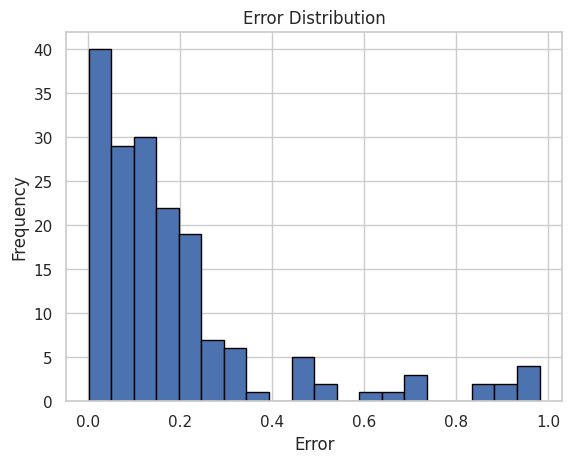

In [ ]:
# plot distribution of error_12
import matplotlib.pyplot as plt



# Plot histogram
plt.hist(errors_12_clean, bins=20, edgecolor="black")  # bins=20 for smoother distribution
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()


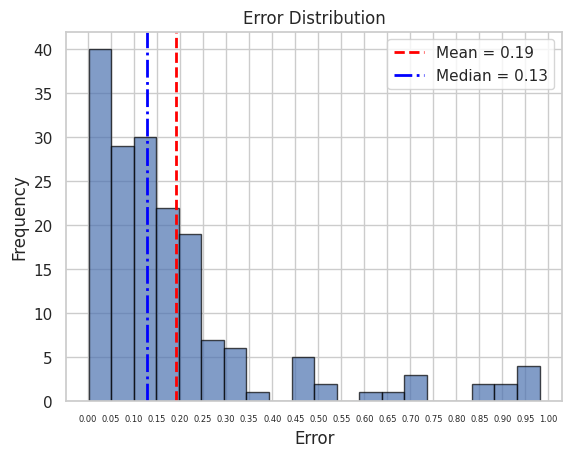

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Compute mean & median
mean_err = np.mean(errors_12_clean)
median_err = np.median(errors_12_clean)

# Plot histogram
plt.hist(errors_12_clean, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")

# Add mean & median lines
plt.axvline(mean_err, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_err:.2f}")
plt.axvline(median_err, color="blue", linestyle="-.", linewidth=2, label=f"Median = {median_err:.2f}")

# Set x ticks every 0.05 with smaller font
plt.xticks(np.arange(0, 1.05, 0.05), fontsize=6)  # fontsize controls size

# Add legend
plt.legend()

plt.show()


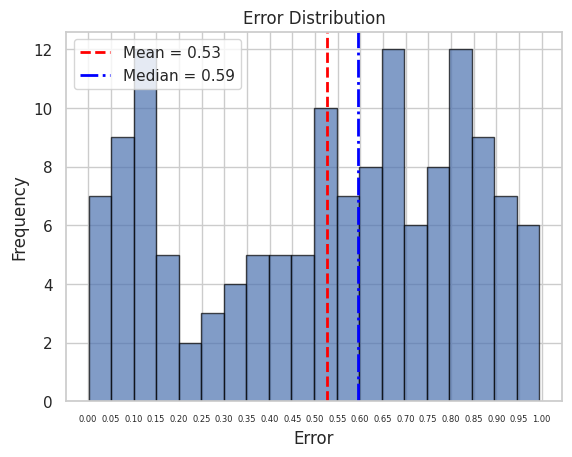

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Compute mean & median
mean_err = np.mean(errors_03_clean)
median_err = np.median(errors_03_clean)

# Plot histogram
plt.hist(errors_03_clean, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")

# Add mean & median lines
plt.axvline(mean_err, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_err:.2f}")
plt.axvline(median_err, color="blue", linestyle="-.", linewidth=2, label=f"Median = {median_err:.2f}")

# Set x ticks every 0.05 with smaller font
plt.xticks(np.arange(0, 1.05, 0.05), fontsize=6)  # fontsize controls size

# Add legend
plt.legend()

plt.show()

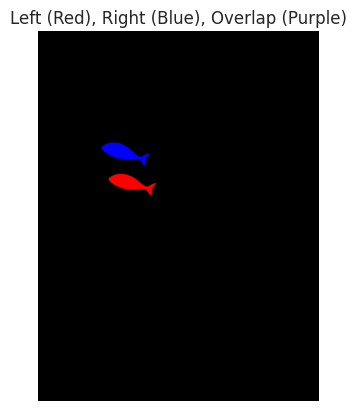

In [ ]:
# Load masks (boolean or 0/1 arrays)

left_mask = mask_left
right_mask = mask_right
# Ensure they are the same shape
assert left_mask.shape == right_mask.shape, "Masks must have the same dimensions"

# Create RGB overlay image
overlay = np.zeros((*left_mask.shape, 3), dtype=np.uint8)

# Assign colors
overlay[left_mask > 0] = [255, 0, 0]   # Red for left mask
overlay[right_mask > 0] = [0, 0, 255]  # Blue for right mask
overlay[(left_mask > 0) & (right_mask > 0)] = [255, 0, 255]  # Purple for overlap

# Show
plt.imshow(overlay)
plt.axis("off")
plt.title("Left (Red), Right (Blue), Overlap (Purple)")
plt.show()

# Keypoints detection

In [ ]:
# keypoints detection
!pip install -q ultralytics
from random import sample

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("/content/drive/MyDrive/2023_24 Prototype 2.0/PESCI/Keypoints/YOLO/runs/pose/train17/weights/best.pt")

In [ ]:
def generate_labels(results, target_folder, labels_folder, confidence: float = 0.2, line_width: int = 8, kpt_radius: int = 10) -> None:
    """
    Generate YOLO-style label files with bounding boxes and keypoints from detection results.

    Each detection result is saved as:
      - An annotated image in `target_folder`.
      - A `.txt` file in `labels_folder` containing YOLO-format annotations:
        class_id center_x center_y width height kpt1_x kpt1_y ... kptN_x kptN_y

    Bounding boxes and keypoints are normalized to [0, 1] relative to image size.

    Args:
        results (list): List of detection results, each containing `.path`, `.boxes.xyxy`, `.boxes.conf`, and `.keypoints.xy`.
        target_folder (str or Path): Directory where annotated images will be saved.
        labels_folder (str or Path): Directory where YOLO-format label files will be saved.
        confidence (float, optional): Minimum confidence threshold for saving a detection. Defaults to 0.2.
        line_width (int, optional): Line thickness for saved bounding box annotations. Defaults to 8.
        kpt_radius (int, optional): Radius for keypoint drawing. Defaults to 10.

    Returns:
        None
    """
    target_folder = Path(target_folder)
    labels_folder = Path(labels_folder)
    target_folder.mkdir(parents=True, exist_ok=True)
    labels_folder.mkdir(parents=True, exist_ok=True)

    for result in results:
        image_file = target_folder / f"{Path(result.path).stem}.jpg"
        labels_file = labels_folder / f"{Path(result.path).stem}.txt"

        # Save annotated image
        result.save(str(image_file), line_width=line_width, kpt_radius=kpt_radius)

        # Load image size
        img = cv2.imread(str(image_file))
        if img is None:
            print(f"[WARN] Could not read {image_file}, skipping.")
            continue
        height, width, _ = img.shape

        with open(labels_file, "w") as f:
            for box, keypoint, conf in zip(result.boxes.xyxy, result.keypoints.xy, result.boxes.conf):
                if conf < confidence:
                    continue

                # Bounding box in YOLO format (normalized)
                box_width = (box[2] - box[0]) / width
                box_height = (box[3] - box[1]) / height
                box_center_x = (box[0] + (box[2] - box[0]) / 2) / width
                box_center_y = (box[1] + (box[3] - box[1]) / 2) / height

                # Format bounding box
                box_str = f"0 {box_center_x:.6f} {box_center_y:.6f} {box_width:.6f} {box_height:.6f}"

                # Format keypoints (normalized)
                keypoints_str = " ".join([f"{x / width:.6f} {y / height:.6f}" for x, y in keypoint])

                f.write(f"{box_str} {keypoints_str}\n")


In [ ]:
fish = Path('spigole/gabbia8/').glob('*.*')
# only select the 0 and 1 lenses
fish = [x for x in fish if "l0" in str(x) or "l1" in str(x)]

In [ ]:
# clear gpu ram
#import torch
#torch.cuda.empty_cache()

# Define a batch size that fits into your GPU memory
batch_size = 32 # You might need to adjust this value based on your GPU

# Process images in batches
results = []
for i in tqdm(range(0, len(fish), batch_size)):
    batch = fish[i:i + batch_size]
    batch_results = model.predict(batch)
    results.extend(batch_results)

  0%|          | 0/13 [00:00<?, ?it/s]


0: 1024x800 1 fish, 120.7ms
1: 1024x800 1 fish, 120.7ms
2: 1024x800 (no detections), 120.7ms
3: 1024x800 2 fishs, 120.7ms
4: 1024x800 2 fishs, 120.7ms
5: 1024x800 4 fishs, 120.7ms
6: 1024x800 2 fishs, 120.7ms
7: 1024x800 1 fish, 120.7ms
8: 1024x800 2 fishs, 120.7ms
9: 1024x800 1 fish, 120.7ms
10: 1024x800 (no detections), 120.7ms
11: 1024x800 (no detections), 120.7ms
12: 1024x800 1 fish, 120.7ms
13: 1024x800 1 fish, 120.7ms
14: 1024x800 3 fishs, 120.7ms
15: 1024x800 3 fishs, 120.7ms
16: 1024x800 5 fishs, 120.7ms
17: 1024x800 (no detections), 120.7ms
18: 1024x800 (no detections), 120.7ms
19: 1024x800 1 fish, 120.7ms
20: 1024x800 2 fishs, 120.7ms
21: 1024x800 1 fish, 120.7ms
22: 1024x800 2 fishs, 120.7ms
23: 1024x800 2 fishs, 120.7ms
24: 1024x800 4 fishs, 120.7ms
25: 1024x800 5 fishs, 120.7ms
26: 1024x800 4 fishs, 120.7ms
27: 1024x800 3 fishs, 120.7ms
28: 1024x800 3 fishs, 120.7ms
29: 1024x800 2 fishs, 120.7ms
30: 1024x800 (no detections), 120.7ms
31: 1024x800 (no detections), 120.7ms
S

  8%|▊         | 1/13 [00:09<01:49,  9.15s/it]


0: 1024x800 (no detections), 124.5ms
1: 1024x800 1 fish, 124.5ms
2: 1024x800 2 fishs, 124.5ms
3: 1024x800 6 fishs, 124.5ms
4: 1024x800 (no detections), 124.5ms
5: 1024x800 3 fishs, 124.5ms
6: 1024x800 (no detections), 124.5ms
7: 1024x800 2 fishs, 124.5ms
8: 1024x800 3 fishs, 124.5ms
9: 1024x800 1 fish, 124.5ms
10: 1024x800 3 fishs, 124.5ms
11: 1024x800 (no detections), 124.5ms
12: 1024x800 5 fishs, 124.5ms
13: 1024x800 2 fishs, 124.5ms
14: 1024x800 3 fishs, 124.5ms
15: 1024x800 1 fish, 124.5ms
16: 1024x800 7 fishs, 124.5ms
17: 1024x800 1 fish, 124.5ms
18: 1024x800 1 fish, 124.5ms
19: 1024x800 2 fishs, 124.5ms
20: 1024x800 1 fish, 124.5ms
21: 1024x800 2 fishs, 124.5ms
22: 1024x800 4 fishs, 124.5ms
23: 1024x800 (no detections), 124.5ms
24: 1024x800 1 fish, 124.5ms
25: 1024x800 2 fishs, 124.5ms
26: 1024x800 5 fishs, 124.5ms
27: 1024x800 (no detections), 124.5ms
28: 1024x800 2 fishs, 124.5ms
29: 1024x800 (no detections), 124.5ms
30: 1024x800 (no detections), 124.5ms
31: 1024x800 3 fishs, 

 15%|█▌        | 2/13 [00:15<01:23,  7.55s/it]


0: 1024x800 (no detections), 125.5ms
1: 1024x800 7 fishs, 125.5ms
2: 1024x800 5 fishs, 125.5ms
3: 1024x800 5 fishs, 125.5ms
4: 1024x800 1 fish, 125.5ms
5: 1024x800 2 fishs, 125.5ms
6: 1024x800 3 fishs, 125.5ms
7: 1024x800 3 fishs, 125.5ms
8: 1024x800 (no detections), 125.5ms
9: 1024x800 1 fish, 125.5ms
10: 1024x800 6 fishs, 125.5ms
11: 1024x800 (no detections), 125.5ms
12: 1024x800 1 fish, 125.5ms
13: 1024x800 3 fishs, 125.5ms
14: 1024x800 (no detections), 125.5ms
15: 1024x800 1 fish, 125.5ms
16: 1024x800 (no detections), 125.5ms
17: 1024x800 5 fishs, 125.5ms
18: 1024x800 2 fishs, 125.5ms
19: 1024x800 2 fishs, 125.5ms
20: 1024x800 (no detections), 125.5ms
21: 1024x800 3 fishs, 125.5ms
22: 1024x800 3 fishs, 125.5ms
23: 1024x800 (no detections), 125.5ms
24: 1024x800 (no detections), 125.5ms
25: 1024x800 1 fish, 125.5ms
26: 1024x800 2 fishs, 125.5ms
27: 1024x800 5 fishs, 125.5ms
28: 1024x800 1 fish, 125.5ms
29: 1024x800 4 fishs, 125.5ms
30: 1024x800 3 fishs, 125.5ms
31: 1024x800 1 fish, 

 23%|██▎       | 3/13 [00:21<01:09,  6.98s/it]


0: 1024x800 2 fishs, 127.1ms
1: 1024x800 3 fishs, 127.1ms
2: 1024x800 1 fish, 127.1ms
3: 1024x800 2 fishs, 127.1ms
4: 1024x800 (no detections), 127.1ms
5: 1024x800 (no detections), 127.1ms
6: 1024x800 (no detections), 127.1ms
7: 1024x800 (no detections), 127.1ms
8: 1024x800 3 fishs, 127.1ms
9: 1024x800 5 fishs, 127.1ms
10: 1024x800 (no detections), 127.1ms
11: 1024x800 1 fish, 127.1ms
12: 1024x800 2 fishs, 127.1ms
13: 1024x800 3 fishs, 127.1ms
14: 1024x800 3 fishs, 127.1ms
15: 1024x800 (no detections), 127.1ms
16: 1024x800 2 fishs, 127.1ms
17: 1024x800 (no detections), 127.1ms
18: 1024x800 1 fish, 127.1ms
19: 1024x800 1 fish, 127.1ms
20: 1024x800 (no detections), 127.1ms
21: 1024x800 1 fish, 127.1ms
22: 1024x800 3 fishs, 127.1ms
23: 1024x800 (no detections), 127.1ms
24: 1024x800 1 fish, 127.1ms
25: 1024x800 5 fishs, 127.1ms
26: 1024x800 1 fish, 127.1ms
27: 1024x800 (no detections), 127.1ms
28: 1024x800 1 fish, 127.1ms
29: 1024x800 (no detections), 127.1ms
30: 1024x800 2 fishs, 127.1ms

 31%|███       | 4/13 [00:28<01:00,  6.71s/it]


0: 1024x800 (no detections), 125.7ms
1: 1024x800 (no detections), 125.7ms
2: 1024x800 2 fishs, 125.7ms
3: 1024x800 5 fishs, 125.7ms
4: 1024x800 3 fishs, 125.7ms
5: 1024x800 (no detections), 125.7ms
6: 1024x800 (no detections), 125.7ms
7: 1024x800 2 fishs, 125.7ms
8: 1024x800 3 fishs, 125.7ms
9: 1024x800 1 fish, 125.7ms
10: 1024x800 2 fishs, 125.7ms
11: 1024x800 1 fish, 125.7ms
12: 1024x800 1 fish, 125.7ms
13: 1024x800 2 fishs, 125.7ms
14: 1024x800 2 fishs, 125.7ms
15: 1024x800 1 fish, 125.7ms
16: 1024x800 4 fishs, 125.7ms
17: 1024x800 5 fishs, 125.7ms
18: 1024x800 4 fishs, 125.7ms
19: 1024x800 (no detections), 125.7ms
20: 1024x800 1 fish, 125.7ms
21: 1024x800 3 fishs, 125.7ms
22: 1024x800 (no detections), 125.7ms
23: 1024x800 (no detections), 125.7ms
24: 1024x800 (no detections), 125.7ms
25: 1024x800 2 fishs, 125.7ms
26: 1024x800 (no detections), 125.7ms
27: 1024x800 (no detections), 125.7ms
28: 1024x800 4 fishs, 125.7ms
29: 1024x800 (no detections), 125.7ms
30: 1024x800 2 fishs, 125.

 38%|███▊      | 5/13 [00:34<00:53,  6.65s/it]


0: 1024x800 3 fishs, 127.8ms
1: 1024x800 5 fishs, 127.8ms
2: 1024x800 (no detections), 127.8ms
3: 1024x800 6 fishs, 127.8ms
4: 1024x800 2 fishs, 127.8ms
5: 1024x800 (no detections), 127.8ms
6: 1024x800 4 fishs, 127.8ms
7: 1024x800 2 fishs, 127.8ms
8: 1024x800 4 fishs, 127.8ms
9: 1024x800 2 fishs, 127.8ms
10: 1024x800 9 fishs, 127.8ms
11: 1024x800 2 fishs, 127.8ms
12: 1024x800 3 fishs, 127.8ms
13: 1024x800 3 fishs, 127.8ms
14: 1024x800 5 fishs, 127.8ms
15: 1024x800 1 fish, 127.8ms
16: 1024x800 4 fishs, 127.8ms
17: 1024x800 1 fish, 127.8ms
18: 1024x800 2 fishs, 127.8ms
19: 1024x800 (no detections), 127.8ms
20: 1024x800 1 fish, 127.8ms
21: 1024x800 6 fishs, 127.8ms
22: 1024x800 4 fishs, 127.8ms
23: 1024x800 2 fishs, 127.8ms
24: 1024x800 5 fishs, 127.8ms
25: 1024x800 4 fishs, 127.8ms
26: 1024x800 9 fishs, 127.8ms
27: 1024x800 2 fishs, 127.8ms
28: 1024x800 1 fish, 127.8ms
29: 1024x800 4 fishs, 127.8ms
30: 1024x800 1 fish, 127.8ms
31: 1024x800 (no detections), 127.8ms
Speed: 6.4ms preproces

 46%|████▌     | 6/13 [00:40<00:45,  6.52s/it]


0: 1024x800 (no detections), 130.1ms
1: 1024x800 1 fish, 130.1ms
2: 1024x800 2 fishs, 130.1ms
3: 1024x800 (no detections), 130.1ms
4: 1024x800 7 fishs, 130.1ms
5: 1024x800 2 fishs, 130.1ms
6: 1024x800 1 fish, 130.1ms
7: 1024x800 4 fishs, 130.1ms
8: 1024x800 (no detections), 130.1ms
9: 1024x800 (no detections), 130.1ms
10: 1024x800 4 fishs, 130.1ms
11: 1024x800 2 fishs, 130.1ms
12: 1024x800 2 fishs, 130.1ms
13: 1024x800 5 fishs, 130.1ms
14: 1024x800 2 fishs, 130.1ms
15: 1024x800 2 fishs, 130.1ms
16: 1024x800 4 fishs, 130.1ms
17: 1024x800 5 fishs, 130.1ms
18: 1024x800 3 fishs, 130.1ms
19: 1024x800 2 fishs, 130.1ms
20: 1024x800 2 fishs, 130.1ms
21: 1024x800 (no detections), 130.1ms
22: 1024x800 2 fishs, 130.1ms
23: 1024x800 3 fishs, 130.1ms
24: 1024x800 (no detections), 130.1ms
25: 1024x800 4 fishs, 130.1ms
26: 1024x800 3 fishs, 130.1ms
27: 1024x800 5 fishs, 130.1ms
28: 1024x800 (no detections), 130.1ms
29: 1024x800 3 fishs, 130.1ms
30: 1024x800 1 fish, 130.1ms
31: 1024x800 4 fishs, 130.

 54%|█████▍    | 7/13 [00:47<00:38,  6.49s/it]


0: 1024x800 1 fish, 131.1ms
1: 1024x800 4 fishs, 131.1ms
2: 1024x800 (no detections), 131.1ms
3: 1024x800 2 fishs, 131.1ms
4: 1024x800 2 fishs, 131.1ms
5: 1024x800 (no detections), 131.1ms
6: 1024x800 3 fishs, 131.1ms
7: 1024x800 2 fishs, 131.1ms
8: 1024x800 1 fish, 131.1ms
9: 1024x800 2 fishs, 131.1ms
10: 1024x800 2 fishs, 131.1ms
11: 1024x800 5 fishs, 131.1ms
12: 1024x800 4 fishs, 131.1ms
13: 1024x800 3 fishs, 131.1ms
14: 1024x800 2 fishs, 131.1ms
15: 1024x800 3 fishs, 131.1ms
16: 1024x800 4 fishs, 131.1ms
17: 1024x800 2 fishs, 131.1ms
18: 1024x800 2 fishs, 131.1ms
19: 1024x800 1 fish, 131.1ms
20: 1024x800 5 fishs, 131.1ms
21: 1024x800 2 fishs, 131.1ms
22: 1024x800 4 fishs, 131.1ms
23: 1024x800 3 fishs, 131.1ms
24: 1024x800 1 fish, 131.1ms
25: 1024x800 (no detections), 131.1ms
26: 1024x800 2 fishs, 131.1ms
27: 1024x800 7 fishs, 131.1ms
28: 1024x800 2 fishs, 131.1ms
29: 1024x800 1 fish, 131.1ms
30: 1024x800 (no detections), 131.1ms
31: 1024x800 3 fishs, 131.1ms
Speed: 6.5ms preproces

 62%|██████▏   | 8/13 [00:53<00:32,  6.47s/it]


0: 1024x800 (no detections), 133.6ms
1: 1024x800 (no detections), 133.6ms
2: 1024x800 3 fishs, 133.6ms
3: 1024x800 (no detections), 133.6ms
4: 1024x800 4 fishs, 133.6ms
5: 1024x800 2 fishs, 133.6ms
6: 1024x800 2 fishs, 133.6ms
7: 1024x800 3 fishs, 133.6ms
8: 1024x800 1 fish, 133.6ms
9: 1024x800 2 fishs, 133.6ms
10: 1024x800 (no detections), 133.6ms
11: 1024x800 2 fishs, 133.6ms
12: 1024x800 1 fish, 133.6ms
13: 1024x800 1 fish, 133.6ms
14: 1024x800 1 fish, 133.6ms
15: 1024x800 5 fishs, 133.6ms
16: 1024x800 2 fishs, 133.6ms
17: 1024x800 (no detections), 133.6ms
18: 1024x800 1 fish, 133.6ms
19: 1024x800 (no detections), 133.6ms
20: 1024x800 (no detections), 133.6ms
21: 1024x800 10 fishs, 133.6ms
22: 1024x800 (no detections), 133.6ms
23: 1024x800 1 fish, 133.6ms
24: 1024x800 3 fishs, 133.6ms
25: 1024x800 1 fish, 133.6ms
26: 1024x800 (no detections), 133.6ms
27: 1024x800 1 fish, 133.6ms
28: 1024x800 (no detections), 133.6ms
29: 1024x800 2 fishs, 133.6ms
30: 1024x800 1 fish, 133.6ms
31: 102

 69%|██████▉   | 9/13 [01:00<00:25,  6.47s/it]


0: 1024x800 1 fish, 134.6ms
1: 1024x800 1 fish, 134.6ms
2: 1024x800 (no detections), 134.6ms
3: 1024x800 3 fishs, 134.6ms
4: 1024x800 (no detections), 134.6ms
5: 1024x800 2 fishs, 134.6ms
6: 1024x800 1 fish, 134.6ms
7: 1024x800 1 fish, 134.6ms
8: 1024x800 (no detections), 134.6ms
9: 1024x800 2 fishs, 134.6ms
10: 1024x800 1 fish, 134.6ms
11: 1024x800 (no detections), 134.6ms
12: 1024x800 2 fishs, 134.6ms
13: 1024x800 5 fishs, 134.6ms
14: 1024x800 3 fishs, 134.6ms
15: 1024x800 1 fish, 134.6ms
16: 1024x800 (no detections), 134.6ms
17: 1024x800 1 fish, 134.6ms
18: 1024x800 3 fishs, 134.6ms
19: 1024x800 2 fishs, 134.6ms
20: 1024x800 2 fishs, 134.6ms
21: 1024x800 1 fish, 134.6ms
22: 1024x800 (no detections), 134.6ms
23: 1024x800 5 fishs, 134.6ms
24: 1024x800 3 fishs, 134.6ms
25: 1024x800 1 fish, 134.6ms
26: 1024x800 1 fish, 134.6ms
27: 1024x800 5 fishs, 134.6ms
28: 1024x800 (no detections), 134.6ms
29: 1024x800 (no detections), 134.6ms
30: 1024x800 1 fish, 134.6ms
31: 1024x800 1 fish, 134.6

 77%|███████▋  | 10/13 [01:06<00:19,  6.50s/it]


0: 1024x800 (no detections), 135.1ms
1: 1024x800 1 fish, 135.1ms
2: 1024x800 6 fishs, 135.1ms
3: 1024x800 3 fishs, 135.1ms
4: 1024x800 6 fishs, 135.1ms
5: 1024x800 1 fish, 135.1ms
6: 1024x800 2 fishs, 135.1ms
7: 1024x800 2 fishs, 135.1ms
8: 1024x800 4 fishs, 135.1ms
9: 1024x800 1 fish, 135.1ms
10: 1024x800 7 fishs, 135.1ms
11: 1024x800 3 fishs, 135.1ms
12: 1024x800 (no detections), 135.1ms
13: 1024x800 (no detections), 135.1ms
14: 1024x800 3 fishs, 135.1ms
15: 1024x800 4 fishs, 135.1ms
16: 1024x800 (no detections), 135.1ms
17: 1024x800 4 fishs, 135.1ms
18: 1024x800 1 fish, 135.1ms
19: 1024x800 1 fish, 135.1ms
20: 1024x800 (no detections), 135.1ms
21: 1024x800 4 fishs, 135.1ms
22: 1024x800 3 fishs, 135.1ms
23: 1024x800 1 fish, 135.1ms
24: 1024x800 2 fishs, 135.1ms
25: 1024x800 1 fish, 135.1ms
26: 1024x800 1 fish, 135.1ms
27: 1024x800 (no detections), 135.1ms
28: 1024x800 2 fishs, 135.1ms
29: 1024x800 3 fishs, 135.1ms
30: 1024x800 1 fish, 135.1ms
31: 1024x800 1 fish, 135.1ms
Speed: 6.6m

 85%|████████▍ | 11/13 [01:13<00:13,  6.50s/it]


0: 1024x800 (no detections), 136.8ms
1: 1024x800 (no detections), 136.8ms
2: 1024x800 5 fishs, 136.8ms
3: 1024x800 3 fishs, 136.8ms
4: 1024x800 9 fishs, 136.8ms
5: 1024x800 3 fishs, 136.8ms
6: 1024x800 6 fishs, 136.8ms
7: 1024x800 2 fishs, 136.8ms
8: 1024x800 4 fishs, 136.8ms
9: 1024x800 2 fishs, 136.8ms
10: 1024x800 4 fishs, 136.8ms
11: 1024x800 8 fishs, 136.8ms
12: 1024x800 2 fishs, 136.8ms
13: 1024x800 1 fish, 136.8ms
14: 1024x800 (no detections), 136.8ms
15: 1024x800 2 fishs, 136.8ms
16: 1024x800 (no detections), 136.8ms
17: 1024x800 3 fishs, 136.8ms
18: 1024x800 3 fishs, 136.8ms
19: 1024x800 3 fishs, 136.8ms
20: 1024x800 2 fishs, 136.8ms
21: 1024x800 2 fishs, 136.8ms
22: 1024x800 (no detections), 136.8ms
23: 1024x800 1 fish, 136.8ms
24: 1024x800 3 fishs, 136.8ms
25: 1024x800 3 fishs, 136.8ms
26: 1024x800 2 fishs, 136.8ms
27: 1024x800 (no detections), 136.8ms
28: 1024x800 6 fishs, 136.8ms
29: 1024x800 1 fish, 136.8ms
30: 1024x800 4 fishs, 136.8ms
31: 1024x800 2 fishs, 136.8ms
Spee

 92%|█████████▏| 12/13 [01:19<00:06,  6.53s/it]


0: 1024x800 2 fishs, 141.1ms
1: 1024x800 (no detections), 141.1ms
2: 1024x800 1 fish, 141.1ms
3: 1024x800 (no detections), 141.1ms
4: 1024x800 1 fish, 141.1ms
5: 1024x800 (no detections), 141.1ms
6: 1024x800 4 fishs, 141.1ms
7: 1024x800 (no detections), 141.1ms
8: 1024x800 2 fishs, 141.1ms
9: 1024x800 (no detections), 141.1ms
10: 1024x800 5 fishs, 141.1ms
11: 1024x800 4 fishs, 141.1ms
12: 1024x800 1 fish, 141.1ms
13: 1024x800 5 fishs, 141.1ms
14: 1024x800 3 fishs, 141.1ms
15: 1024x800 2 fishs, 141.1ms
16: 1024x800 (no detections), 141.1ms
17: 1024x800 2 fishs, 141.1ms
18: 1024x800 1 fish, 141.1ms
19: 1024x800 3 fishs, 141.1ms
20: 1024x800 (no detections), 141.1ms
21: 1024x800 (no detections), 141.1ms
22: 1024x800 3 fishs, 141.1ms
23: 1024x800 2 fishs, 141.1ms
24: 1024x800 2 fishs, 141.1ms
25: 1024x800 (no detections), 141.1ms
Speed: 6.4ms preprocess, 141.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 800)


100%|██████████| 13/13 [01:25<00:00,  6.57s/it]


In [ ]:
!mkdir "/content/spigole/gabbia8/keypoints/"
!mkdir "/content/spigole/gabbia8/labels/"

In [ ]:
generate_labels(results, target_folder = "/content/spigole/gabbia8/keypoints/", labels_folder="/content/spigole/gabbia8/labels/")

In [ ]:
fish = Path('spigole/gabbia7/').glob('*.*')
# only select the 0 and 1 lenses
fish = [x for x in fish if "l0" in str(x) or "l1" in str(x)]

In [ ]:
!mkdir "/content/spigole/gabbia7/keypoints/"
!mkdir "/content/spigole/gabbia7/labels/"

mkdir: cannot create directory ‘/content/spigole/gabbia7/keypoints/’: File exists
mkdir: cannot create directory ‘/content/spigole/gabbia7/labels/’: File exists


In [ ]:

# Define a batch size that fits into your GPU memory
batch_size = 32 # You might need to adjust this value based on your GPU

# Process images in batches
results = []
for i in tqdm(range(0, len(fish), batch_size)):
    batch = fish[i:i + batch_size]
    batch_results = model.predict(batch)
    results.extend(batch_results)

  0%|          | 0/19 [00:00<?, ?it/s]


0: 1024x800 6 fishs, 159.1ms
1: 1024x800 3 fishs, 159.1ms
2: 1024x800 3 fishs, 159.1ms
3: 1024x800 4 fishs, 159.1ms
4: 1024x800 4 fishs, 159.1ms
5: 1024x800 1 fish, 159.1ms
6: 1024x800 2 fishs, 159.1ms
7: 1024x800 6 fishs, 159.1ms
8: 1024x800 2 fishs, 159.1ms
9: 1024x800 4 fishs, 159.1ms
10: 1024x800 1 fish, 159.1ms
11: 1024x800 2 fishs, 159.1ms
12: 1024x800 4 fishs, 159.1ms
13: 1024x800 6 fishs, 159.1ms
14: 1024x800 2 fishs, 159.1ms
15: 1024x800 5 fishs, 159.1ms
16: 1024x800 4 fishs, 159.1ms
17: 1024x800 5 fishs, 159.1ms
18: 1024x800 2 fishs, 159.1ms
19: 1024x800 (no detections), 159.1ms
20: 1024x800 1 fish, 159.1ms
21: 1024x800 4 fishs, 159.1ms
22: 1024x800 3 fishs, 159.1ms
23: 1024x800 6 fishs, 159.1ms
24: 1024x800 2 fishs, 159.1ms
25: 1024x800 9 fishs, 159.1ms
26: 1024x800 1 fish, 159.1ms
27: 1024x800 2 fishs, 159.1ms
28: 1024x800 2 fishs, 159.1ms
29: 1024x800 5 fishs, 159.1ms
30: 1024x800 1 fish, 159.1ms
31: 1024x800 2 fishs, 159.1ms
Speed: 5.9ms preprocess, 159.1ms inference, 0.

  5%|▌         | 1/19 [00:07<02:08,  7.14s/it]


0: 1024x800 2 fishs, 163.6ms
1: 1024x800 2 fishs, 163.6ms
2: 1024x800 (no detections), 163.6ms
3: 1024x800 3 fishs, 163.6ms
4: 1024x800 2 fishs, 163.6ms
5: 1024x800 3 fishs, 163.6ms
6: 1024x800 4 fishs, 163.6ms
7: 1024x800 5 fishs, 163.6ms
8: 1024x800 2 fishs, 163.6ms
9: 1024x800 3 fishs, 163.6ms
10: 1024x800 4 fishs, 163.6ms
11: 1024x800 3 fishs, 163.6ms
12: 1024x800 5 fishs, 163.6ms
13: 1024x800 4 fishs, 163.6ms
14: 1024x800 6 fishs, 163.6ms
15: 1024x800 2 fishs, 163.6ms
16: 1024x800 5 fishs, 163.6ms
17: 1024x800 4 fishs, 163.6ms
18: 1024x800 1 fish, 163.6ms
19: 1024x800 2 fishs, 163.6ms
20: 1024x800 3 fishs, 163.6ms
21: 1024x800 3 fishs, 163.6ms
22: 1024x800 3 fishs, 163.6ms
23: 1024x800 (no detections), 163.6ms
24: 1024x800 1 fish, 163.6ms
25: 1024x800 2 fishs, 163.6ms
26: 1024x800 1 fish, 163.6ms
27: 1024x800 6 fishs, 163.6ms
28: 1024x800 6 fishs, 163.6ms
29: 1024x800 1 fish, 163.6ms
30: 1024x800 5 fishs, 163.6ms
31: 1024x800 3 fishs, 163.6ms
Speed: 5.8ms preprocess, 163.6ms infe

 11%|█         | 2/19 [00:14<02:03,  7.24s/it]


0: 1024x800 4 fishs, 164.0ms
1: 1024x800 1 fish, 164.0ms
2: 1024x800 4 fishs, 164.0ms
3: 1024x800 4 fishs, 164.0ms
4: 1024x800 4 fishs, 164.0ms
5: 1024x800 5 fishs, 164.0ms
6: 1024x800 (no detections), 164.0ms
7: 1024x800 2 fishs, 164.0ms
8: 1024x800 4 fishs, 164.0ms
9: 1024x800 4 fishs, 164.0ms
10: 1024x800 3 fishs, 164.0ms
11: 1024x800 1 fish, 164.0ms
12: 1024x800 5 fishs, 164.0ms
13: 1024x800 2 fishs, 164.0ms
14: 1024x800 3 fishs, 164.0ms
15: 1024x800 3 fishs, 164.0ms
16: 1024x800 4 fishs, 164.0ms
17: 1024x800 2 fishs, 164.0ms
18: 1024x800 2 fishs, 164.0ms
19: 1024x800 1 fish, 164.0ms
20: 1024x800 1 fish, 164.0ms
21: 1024x800 4 fishs, 164.0ms
22: 1024x800 (no detections), 164.0ms
23: 1024x800 6 fishs, 164.0ms
24: 1024x800 2 fishs, 164.0ms
25: 1024x800 3 fishs, 164.0ms
26: 1024x800 2 fishs, 164.0ms
27: 1024x800 1 fish, 164.0ms
28: 1024x800 4 fishs, 164.0ms
29: 1024x800 (no detections), 164.0ms
30: 1024x800 4 fishs, 164.0ms
31: 1024x800 5 fishs, 164.0ms
Speed: 6.0ms preprocess, 164.0

 16%|█▌        | 3/19 [00:21<01:56,  7.28s/it]


0: 1024x800 2 fishs, 158.9ms
1: 1024x800 2 fishs, 158.9ms
2: 1024x800 3 fishs, 158.9ms
3: 1024x800 7 fishs, 158.9ms
4: 1024x800 2 fishs, 158.9ms
5: 1024x800 1 fish, 158.9ms
6: 1024x800 3 fishs, 158.9ms
7: 1024x800 3 fishs, 158.9ms
8: 1024x800 2 fishs, 158.9ms
9: 1024x800 4 fishs, 158.9ms
10: 1024x800 4 fishs, 158.9ms
11: 1024x800 4 fishs, 158.9ms
12: 1024x800 1 fish, 158.9ms
13: 1024x800 7 fishs, 158.9ms
14: 1024x800 3 fishs, 158.9ms
15: 1024x800 3 fishs, 158.9ms
16: 1024x800 9 fishs, 158.9ms
17: 1024x800 1 fish, 158.9ms
18: 1024x800 3 fishs, 158.9ms
19: 1024x800 2 fishs, 158.9ms
20: 1024x800 2 fishs, 158.9ms
21: 1024x800 9 fishs, 158.9ms
22: 1024x800 2 fishs, 158.9ms
23: 1024x800 2 fishs, 158.9ms
24: 1024x800 3 fishs, 158.9ms
25: 1024x800 6 fishs, 158.9ms
26: 1024x800 4 fishs, 158.9ms
27: 1024x800 3 fishs, 158.9ms
28: 1024x800 1 fish, 158.9ms
29: 1024x800 1 fish, 158.9ms
30: 1024x800 6 fishs, 158.9ms
31: 1024x800 6 fishs, 158.9ms
Speed: 5.7ms preprocess, 158.9ms inference, 0.8ms post

 21%|██        | 4/19 [00:28<01:48,  7.23s/it]


0: 1024x800 3 fishs, 154.9ms
1: 1024x800 1 fish, 154.9ms
2: 1024x800 5 fishs, 154.9ms
3: 1024x800 2 fishs, 154.9ms
4: 1024x800 4 fishs, 154.9ms
5: 1024x800 2 fishs, 154.9ms
6: 1024x800 2 fishs, 154.9ms
7: 1024x800 5 fishs, 154.9ms
8: 1024x800 1 fish, 154.9ms
9: 1024x800 2 fishs, 154.9ms
10: 1024x800 1 fish, 154.9ms
11: 1024x800 4 fishs, 154.9ms
12: 1024x800 3 fishs, 154.9ms
13: 1024x800 2 fishs, 154.9ms
14: 1024x800 5 fishs, 154.9ms
15: 1024x800 (no detections), 154.9ms
16: 1024x800 6 fishs, 154.9ms
17: 1024x800 1 fish, 154.9ms
18: 1024x800 2 fishs, 154.9ms
19: 1024x800 5 fishs, 154.9ms
20: 1024x800 2 fishs, 154.9ms
21: 1024x800 2 fishs, 154.9ms
22: 1024x800 2 fishs, 154.9ms
23: 1024x800 6 fishs, 154.9ms
24: 1024x800 3 fishs, 154.9ms
25: 1024x800 1 fish, 154.9ms
26: 1024x800 1 fish, 154.9ms
27: 1024x800 3 fishs, 154.9ms
28: 1024x800 4 fishs, 154.9ms
29: 1024x800 2 fishs, 154.9ms
30: 1024x800 5 fishs, 154.9ms
31: 1024x800 1 fish, 154.9ms
Speed: 5.8ms preprocess, 154.9ms inference, 0.8m

 26%|██▋       | 5/19 [00:36<01:40,  7.18s/it]


0: 1024x800 2 fishs, 152.0ms
1: 1024x800 5 fishs, 152.0ms
2: 1024x800 9 fishs, 152.0ms
3: 1024x800 4 fishs, 152.0ms
4: 1024x800 2 fishs, 152.0ms
5: 1024x800 5 fishs, 152.0ms
6: 1024x800 2 fishs, 152.0ms
7: 1024x800 2 fishs, 152.0ms
8: 1024x800 1 fish, 152.0ms
9: 1024x800 3 fishs, 152.0ms
10: 1024x800 4 fishs, 152.0ms
11: 1024x800 4 fishs, 152.0ms
12: 1024x800 5 fishs, 152.0ms
13: 1024x800 4 fishs, 152.0ms
14: 1024x800 2 fishs, 152.0ms
15: 1024x800 7 fishs, 152.0ms
16: 1024x800 2 fishs, 152.0ms
17: 1024x800 2 fishs, 152.0ms
18: 1024x800 2 fishs, 152.0ms
19: 1024x800 3 fishs, 152.0ms
20: 1024x800 2 fishs, 152.0ms
21: 1024x800 (no detections), 152.0ms
22: 1024x800 7 fishs, 152.0ms
23: 1024x800 6 fishs, 152.0ms
24: 1024x800 4 fishs, 152.0ms
25: 1024x800 1 fish, 152.0ms
26: 1024x800 3 fishs, 152.0ms
27: 1024x800 4 fishs, 152.0ms
28: 1024x800 1 fish, 152.0ms
29: 1024x800 1 fish, 152.0ms
30: 1024x800 3 fishs, 152.0ms
31: 1024x800 1 fish, 152.0ms
Speed: 5.9ms preprocess, 152.0ms inference, 0.

 32%|███▏      | 6/19 [00:42<01:32,  7.10s/it]


0: 1024x800 2 fishs, 150.5ms
1: 1024x800 6 fishs, 150.5ms
2: 1024x800 1 fish, 150.5ms
3: 1024x800 3 fishs, 150.5ms
4: 1024x800 8 fishs, 150.5ms
5: 1024x800 4 fishs, 150.5ms
6: 1024x800 2 fishs, 150.5ms
7: 1024x800 2 fishs, 150.5ms
8: 1024x800 4 fishs, 150.5ms
9: 1024x800 7 fishs, 150.5ms
10: 1024x800 3 fishs, 150.5ms
11: 1024x800 1 fish, 150.5ms
12: 1024x800 2 fishs, 150.5ms
13: 1024x800 4 fishs, 150.5ms
14: 1024x800 3 fishs, 150.5ms
15: 1024x800 5 fishs, 150.5ms
16: 1024x800 2 fishs, 150.5ms
17: 1024x800 2 fishs, 150.5ms
18: 1024x800 2 fishs, 150.5ms
19: 1024x800 (no detections), 150.5ms
20: 1024x800 1 fish, 150.5ms
21: 1024x800 3 fishs, 150.5ms
22: 1024x800 2 fishs, 150.5ms
23: 1024x800 3 fishs, 150.5ms
24: 1024x800 1 fish, 150.5ms
25: 1024x800 8 fishs, 150.5ms
26: 1024x800 5 fishs, 150.5ms
27: 1024x800 1 fish, 150.5ms
28: 1024x800 4 fishs, 150.5ms
29: 1024x800 4 fishs, 150.5ms
30: 1024x800 7 fishs, 150.5ms
31: 1024x800 5 fishs, 150.5ms
Speed: 5.7ms preprocess, 150.5ms inference, 0.

 37%|███▋      | 7/19 [00:49<01:24,  7.02s/it]


0: 1024x800 6 fishs, 149.0ms
1: 1024x800 2 fishs, 149.0ms
2: 1024x800 6 fishs, 149.0ms
3: 1024x800 2 fishs, 149.0ms
4: 1024x800 4 fishs, 149.0ms
5: 1024x800 9 fishs, 149.0ms
6: 1024x800 1 fish, 149.0ms
7: 1024x800 3 fishs, 149.0ms
8: 1024x800 3 fishs, 149.0ms
9: 1024x800 1 fish, 149.0ms
10: 1024x800 3 fishs, 149.0ms
11: 1024x800 5 fishs, 149.0ms
12: 1024x800 3 fishs, 149.0ms
13: 1024x800 2 fishs, 149.0ms
14: 1024x800 1 fish, 149.0ms
15: 1024x800 5 fishs, 149.0ms
16: 1024x800 6 fishs, 149.0ms
17: 1024x800 2 fishs, 149.0ms
18: 1024x800 1 fish, 149.0ms
19: 1024x800 7 fishs, 149.0ms
20: 1024x800 3 fishs, 149.0ms
21: 1024x800 3 fishs, 149.0ms
22: 1024x800 1 fish, 149.0ms
23: 1024x800 8 fishs, 149.0ms
24: 1024x800 2 fishs, 149.0ms
25: 1024x800 2 fishs, 149.0ms
26: 1024x800 1 fish, 149.0ms
27: 1024x800 5 fishs, 149.0ms
28: 1024x800 3 fishs, 149.0ms
29: 1024x800 4 fishs, 149.0ms
30: 1024x800 3 fishs, 149.0ms
31: 1024x800 (no detections), 149.0ms
Speed: 5.8ms preprocess, 149.0ms inference, 0.8

 42%|████▏     | 8/19 [00:56<01:16,  6.96s/it]


0: 1024x800 3 fishs, 149.7ms
1: 1024x800 7 fishs, 149.7ms
2: 1024x800 1 fish, 149.7ms
3: 1024x800 4 fishs, 149.7ms
4: 1024x800 1 fish, 149.7ms
5: 1024x800 5 fishs, 149.7ms
6: 1024x800 (no detections), 149.7ms
7: 1024x800 2 fishs, 149.7ms
8: 1024x800 4 fishs, 149.7ms
9: 1024x800 1 fish, 149.7ms
10: 1024x800 3 fishs, 149.7ms
11: 1024x800 2 fishs, 149.7ms
12: 1024x800 3 fishs, 149.7ms
13: 1024x800 1 fish, 149.7ms
14: 1024x800 4 fishs, 149.7ms
15: 1024x800 1 fish, 149.7ms
16: 1024x800 2 fishs, 149.7ms
17: 1024x800 5 fishs, 149.7ms
18: 1024x800 3 fishs, 149.7ms
19: 1024x800 1 fish, 149.7ms
20: 1024x800 2 fishs, 149.7ms
21: 1024x800 3 fishs, 149.7ms
22: 1024x800 1 fish, 149.7ms
23: 1024x800 2 fishs, 149.7ms
24: 1024x800 3 fishs, 149.7ms
25: 1024x800 2 fishs, 149.7ms
26: 1024x800 (no detections), 149.7ms
27: 1024x800 2 fishs, 149.7ms
28: 1024x800 2 fishs, 149.7ms
29: 1024x800 3 fishs, 149.7ms
30: 1024x800 4 fishs, 149.7ms
31: 1024x800 4 fishs, 149.7ms
Speed: 5.8ms preprocess, 149.7ms inferen

 47%|████▋     | 9/19 [01:03<01:09,  6.93s/it]


0: 1024x800 6 fishs, 150.4ms
1: 1024x800 3 fishs, 150.4ms
2: 1024x800 2 fishs, 150.4ms
3: 1024x800 3 fishs, 150.4ms
4: 1024x800 6 fishs, 150.4ms
5: 1024x800 2 fishs, 150.4ms
6: 1024x800 3 fishs, 150.4ms
7: 1024x800 2 fishs, 150.4ms
8: 1024x800 6 fishs, 150.4ms
9: 1024x800 2 fishs, 150.4ms
10: 1024x800 3 fishs, 150.4ms
11: 1024x800 5 fishs, 150.4ms
12: 1024x800 1 fish, 150.4ms
13: 1024x800 7 fishs, 150.4ms
14: 1024x800 6 fishs, 150.4ms
15: 1024x800 2 fishs, 150.4ms
16: 1024x800 2 fishs, 150.4ms
17: 1024x800 1 fish, 150.4ms
18: 1024x800 2 fishs, 150.4ms
19: 1024x800 3 fishs, 150.4ms
20: 1024x800 1 fish, 150.4ms
21: 1024x800 1 fish, 150.4ms
22: 1024x800 6 fishs, 150.4ms
23: 1024x800 7 fishs, 150.4ms
24: 1024x800 6 fishs, 150.4ms
25: 1024x800 1 fish, 150.4ms
26: 1024x800 4 fishs, 150.4ms
27: 1024x800 2 fishs, 150.4ms
28: 1024x800 4 fishs, 150.4ms
29: 1024x800 2 fishs, 150.4ms
30: 1024x800 3 fishs, 150.4ms
31: 1024x800 2 fishs, 150.4ms
Speed: 5.9ms preprocess, 150.4ms inference, 0.8ms post

 53%|█████▎    | 10/19 [01:10<01:02,  6.93s/it]


0: 1024x800 3 fishs, 153.2ms
1: 1024x800 4 fishs, 153.2ms
2: 1024x800 2 fishs, 153.2ms
3: 1024x800 (no detections), 153.2ms
4: 1024x800 2 fishs, 153.2ms
5: 1024x800 5 fishs, 153.2ms
6: 1024x800 2 fishs, 153.2ms
7: 1024x800 5 fishs, 153.2ms
8: 1024x800 2 fishs, 153.2ms
9: 1024x800 4 fishs, 153.2ms
10: 1024x800 1 fish, 153.2ms
11: 1024x800 3 fishs, 153.2ms
12: 1024x800 3 fishs, 153.2ms
13: 1024x800 2 fishs, 153.2ms
14: 1024x800 2 fishs, 153.2ms
15: 1024x800 3 fishs, 153.2ms
16: 1024x800 2 fishs, 153.2ms
17: 1024x800 3 fishs, 153.2ms
18: 1024x800 5 fishs, 153.2ms
19: 1024x800 2 fishs, 153.2ms
20: 1024x800 7 fishs, 153.2ms
21: 1024x800 3 fishs, 153.2ms
22: 1024x800 1 fish, 153.2ms
23: 1024x800 7 fishs, 153.2ms
24: 1024x800 4 fishs, 153.2ms
25: 1024x800 2 fishs, 153.2ms
26: 1024x800 4 fishs, 153.2ms
27: 1024x800 5 fishs, 153.2ms
28: 1024x800 2 fishs, 153.2ms
29: 1024x800 4 fishs, 153.2ms
30: 1024x800 1 fish, 153.2ms
31: 1024x800 2 fishs, 153.2ms
Speed: 5.8ms preprocess, 153.2ms inference, 

 58%|█████▊    | 11/19 [01:17<00:55,  6.95s/it]


0: 1024x800 5 fishs, 154.7ms
1: 1024x800 8 fishs, 154.7ms
2: 1024x800 2 fishs, 154.7ms
3: 1024x800 (no detections), 154.7ms
4: 1024x800 3 fishs, 154.7ms
5: 1024x800 5 fishs, 154.7ms
6: 1024x800 4 fishs, 154.7ms
7: 1024x800 5 fishs, 154.7ms
8: 1024x800 5 fishs, 154.7ms
9: 1024x800 2 fishs, 154.7ms
10: 1024x800 4 fishs, 154.7ms
11: 1024x800 2 fishs, 154.7ms
12: 1024x800 5 fishs, 154.7ms
13: 1024x800 4 fishs, 154.7ms
14: 1024x800 2 fishs, 154.7ms
15: 1024x800 6 fishs, 154.7ms
16: 1024x800 3 fishs, 154.7ms
17: 1024x800 2 fishs, 154.7ms
18: 1024x800 4 fishs, 154.7ms
19: 1024x800 5 fishs, 154.7ms
20: 1024x800 2 fishs, 154.7ms
21: 1024x800 2 fishs, 154.7ms
22: 1024x800 1 fish, 154.7ms
23: 1024x800 3 fishs, 154.7ms
24: 1024x800 7 fishs, 154.7ms
25: 1024x800 5 fishs, 154.7ms
26: 1024x800 2 fishs, 154.7ms
27: 1024x800 1 fish, 154.7ms
28: 1024x800 5 fishs, 154.7ms
29: 1024x800 3 fishs, 154.7ms
30: 1024x800 7 fishs, 154.7ms
31: 1024x800 1 fish, 154.7ms
Speed: 6.5ms preprocess, 154.7ms inference, 

 63%|██████▎   | 12/19 [01:24<00:49,  7.01s/it]


0: 1024x800 3 fishs, 156.3ms
1: 1024x800 1 fish, 156.3ms
2: 1024x800 2 fishs, 156.3ms
3: 1024x800 1 fish, 156.3ms
4: 1024x800 3 fishs, 156.3ms
5: 1024x800 12 fishs, 156.3ms
6: 1024x800 4 fishs, 156.3ms
7: 1024x800 2 fishs, 156.3ms
8: 1024x800 2 fishs, 156.3ms
9: 1024x800 7 fishs, 156.3ms
10: 1024x800 3 fishs, 156.3ms
11: 1024x800 3 fishs, 156.3ms
12: 1024x800 3 fishs, 156.3ms
13: 1024x800 3 fishs, 156.3ms
14: 1024x800 7 fishs, 156.3ms
15: 1024x800 3 fishs, 156.3ms
16: 1024x800 6 fishs, 156.3ms
17: 1024x800 4 fishs, 156.3ms
18: 1024x800 3 fishs, 156.3ms
19: 1024x800 2 fishs, 156.3ms
20: 1024x800 4 fishs, 156.3ms
21: 1024x800 7 fishs, 156.3ms
22: 1024x800 1 fish, 156.3ms
23: 1024x800 2 fishs, 156.3ms
24: 1024x800 2 fishs, 156.3ms
25: 1024x800 7 fishs, 156.3ms
26: 1024x800 4 fishs, 156.3ms
27: 1024x800 4 fishs, 156.3ms
28: 1024x800 1 fish, 156.3ms
29: 1024x800 3 fishs, 156.3ms
30: 1024x800 5 fishs, 156.3ms
31: 1024x800 (no detections), 156.3ms
Speed: 6.5ms preprocess, 156.3ms inference, 

 68%|██████▊   | 13/19 [01:31<00:42,  7.08s/it]


0: 1024x800 4 fishs, 157.3ms
1: 1024x800 2 fishs, 157.3ms
2: 1024x800 2 fishs, 157.3ms
3: 1024x800 4 fishs, 157.3ms
4: 1024x800 4 fishs, 157.3ms
5: 1024x800 (no detections), 157.3ms
6: 1024x800 2 fishs, 157.3ms
7: 1024x800 5 fishs, 157.3ms
8: 1024x800 (no detections), 157.3ms
9: 1024x800 2 fishs, 157.3ms
10: 1024x800 2 fishs, 157.3ms
11: 1024x800 1 fish, 157.3ms
12: 1024x800 2 fishs, 157.3ms
13: 1024x800 4 fishs, 157.3ms
14: 1024x800 1 fish, 157.3ms
15: 1024x800 2 fishs, 157.3ms
16: 1024x800 2 fishs, 157.3ms
17: 1024x800 3 fishs, 157.3ms
18: 1024x800 3 fishs, 157.3ms
19: 1024x800 1 fish, 157.3ms
20: 1024x800 2 fishs, 157.3ms
21: 1024x800 7 fishs, 157.3ms
22: 1024x800 3 fishs, 157.3ms
23: 1024x800 (no detections), 157.3ms
24: 1024x800 4 fishs, 157.3ms
25: 1024x800 2 fishs, 157.3ms
26: 1024x800 4 fishs, 157.3ms
27: 1024x800 7 fishs, 157.3ms
28: 1024x800 2 fishs, 157.3ms
29: 1024x800 2 fishs, 157.3ms
30: 1024x800 2 fishs, 157.3ms
31: 1024x800 (no detections), 157.3ms
Speed: 6.4ms preproc

 74%|███████▎  | 14/19 [01:39<00:35,  7.13s/it]


0: 1024x800 3 fishs, 155.8ms
1: 1024x800 2 fishs, 155.8ms
2: 1024x800 1 fish, 155.8ms
3: 1024x800 4 fishs, 155.8ms
4: 1024x800 2 fishs, 155.8ms
5: 1024x800 4 fishs, 155.8ms
6: 1024x800 3 fishs, 155.8ms
7: 1024x800 5 fishs, 155.8ms
8: 1024x800 6 fishs, 155.8ms
9: 1024x800 1 fish, 155.8ms
10: 1024x800 2 fishs, 155.8ms
11: 1024x800 (no detections), 155.8ms
12: 1024x800 2 fishs, 155.8ms
13: 1024x800 2 fishs, 155.8ms
14: 1024x800 5 fishs, 155.8ms
15: 1024x800 3 fishs, 155.8ms
16: 1024x800 1 fish, 155.8ms
17: 1024x800 2 fishs, 155.8ms
18: 1024x800 1 fish, 155.8ms
19: 1024x800 1 fish, 155.8ms
20: 1024x800 2 fishs, 155.8ms
21: 1024x800 6 fishs, 155.8ms
22: 1024x800 4 fishs, 155.8ms
23: 1024x800 5 fishs, 155.8ms
24: 1024x800 1 fish, 155.8ms
25: 1024x800 (no detections), 155.8ms
26: 1024x800 2 fishs, 155.8ms
27: 1024x800 5 fishs, 155.8ms
28: 1024x800 3 fishs, 155.8ms
29: 1024x800 3 fishs, 155.8ms
30: 1024x800 4 fishs, 155.8ms
31: 1024x800 (no detections), 155.8ms
Speed: 6.9ms preprocess, 155.8m

 79%|███████▉  | 15/19 [01:46<00:28,  7.17s/it]


0: 1024x800 4 fishs, 153.9ms
1: 1024x800 2 fishs, 153.9ms
2: 1024x800 2 fishs, 153.9ms
3: 1024x800 5 fishs, 153.9ms
4: 1024x800 2 fishs, 153.9ms
5: 1024x800 3 fishs, 153.9ms
6: 1024x800 6 fishs, 153.9ms
7: 1024x800 5 fishs, 153.9ms
8: 1024x800 2 fishs, 153.9ms
9: 1024x800 6 fishs, 153.9ms
10: 1024x800 2 fishs, 153.9ms
11: 1024x800 3 fishs, 153.9ms
12: 1024x800 2 fishs, 153.9ms
13: 1024x800 1 fish, 153.9ms
14: 1024x800 4 fishs, 153.9ms
15: 1024x800 5 fishs, 153.9ms
16: 1024x800 2 fishs, 153.9ms
17: 1024x800 2 fishs, 153.9ms
18: 1024x800 1 fish, 153.9ms
19: 1024x800 3 fishs, 153.9ms
20: 1024x800 1 fish, 153.9ms
21: 1024x800 2 fishs, 153.9ms
22: 1024x800 (no detections), 153.9ms
23: 1024x800 5 fishs, 153.9ms
24: 1024x800 3 fishs, 153.9ms
25: 1024x800 2 fishs, 153.9ms
26: 1024x800 (no detections), 153.9ms
27: 1024x800 7 fishs, 153.9ms
28: 1024x800 4 fishs, 153.9ms
29: 1024x800 3 fishs, 153.9ms
30: 1024x800 3 fishs, 153.9ms
31: 1024x800 2 fishs, 153.9ms
Speed: 6.5ms preprocess, 153.9ms inf

 84%|████████▍ | 16/19 [01:53<00:21,  7.27s/it]


0: 1024x800 4 fishs, 152.9ms
1: 1024x800 5 fishs, 152.9ms
2: 1024x800 3 fishs, 152.9ms
3: 1024x800 3 fishs, 152.9ms
4: 1024x800 5 fishs, 152.9ms
5: 1024x800 4 fishs, 152.9ms
6: 1024x800 7 fishs, 152.9ms
7: 1024x800 6 fishs, 152.9ms
8: 1024x800 1 fish, 152.9ms
9: 1024x800 5 fishs, 152.9ms
10: 1024x800 1 fish, 152.9ms
11: 1024x800 2 fishs, 152.9ms
12: 1024x800 6 fishs, 152.9ms
13: 1024x800 3 fishs, 152.9ms
14: 1024x800 2 fishs, 152.9ms
15: 1024x800 2 fishs, 152.9ms
16: 1024x800 1 fish, 152.9ms
17: 1024x800 1 fish, 152.9ms
18: 1024x800 1 fish, 152.9ms
19: 1024x800 2 fishs, 152.9ms
20: 1024x800 6 fishs, 152.9ms
21: 1024x800 3 fishs, 152.9ms
22: 1024x800 6 fishs, 152.9ms
23: 1024x800 3 fishs, 152.9ms
24: 1024x800 2 fishs, 152.9ms
25: 1024x800 6 fishs, 152.9ms
26: 1024x800 3 fishs, 152.9ms
27: 1024x800 2 fishs, 152.9ms
28: 1024x800 5 fishs, 152.9ms
29: 1024x800 4 fishs, 152.9ms
30: 1024x800 8 fishs, 152.9ms
31: 1024x800 7 fishs, 152.9ms
Speed: 6.4ms preprocess, 152.9ms inference, 0.8ms post

 89%|████████▉ | 17/19 [02:01<00:14,  7.25s/it]


0: 1024x800 2 fishs, 152.1ms
1: 1024x800 2 fishs, 152.1ms
2: 1024x800 2 fishs, 152.1ms
3: 1024x800 6 fishs, 152.1ms
4: 1024x800 2 fishs, 152.1ms
5: 1024x800 4 fishs, 152.1ms
6: 1024x800 6 fishs, 152.1ms
7: 1024x800 3 fishs, 152.1ms
8: 1024x800 6 fishs, 152.1ms
9: 1024x800 3 fishs, 152.1ms
10: 1024x800 3 fishs, 152.1ms
11: 1024x800 8 fishs, 152.1ms
12: 1024x800 4 fishs, 152.1ms
13: 1024x800 2 fishs, 152.1ms
14: 1024x800 2 fishs, 152.1ms
15: 1024x800 3 fishs, 152.1ms
16: 1024x800 2 fishs, 152.1ms
17: 1024x800 4 fishs, 152.1ms
18: 1024x800 1 fish, 152.1ms
19: 1024x800 3 fishs, 152.1ms
20: 1024x800 5 fishs, 152.1ms
21: 1024x800 4 fishs, 152.1ms
22: 1024x800 3 fishs, 152.1ms
23: 1024x800 4 fishs, 152.1ms
24: 1024x800 2 fishs, 152.1ms
25: 1024x800 1 fish, 152.1ms
26: 1024x800 4 fishs, 152.1ms
27: 1024x800 6 fishs, 152.1ms
28: 1024x800 3 fishs, 152.1ms
29: 1024x800 5 fishs, 152.1ms
30: 1024x800 2 fishs, 152.1ms
31: 1024x800 3 fishs, 152.1ms
Speed: 6.6ms preprocess, 152.1ms inference, 0.8ms p

 95%|█████████▍| 18/19 [02:08<00:07,  7.23s/it]


0: 1024x800 3 fishs, 146.2ms
1: 1024x800 3 fishs, 146.2ms
2: 1024x800 (no detections), 146.2ms
3: 1024x800 (no detections), 146.2ms
4: 1024x800 (no detections), 146.2ms
5: 1024x800 3 fishs, 146.2ms
6: 1024x800 5 fishs, 146.2ms
7: 1024x800 2 fishs, 146.2ms
8: 1024x800 2 fishs, 146.2ms
9: 1024x800 1 fish, 146.2ms
Speed: 6.5ms preprocess, 146.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 800)


100%|██████████| 19/19 [02:10<00:00,  6.86s/it]


In [ ]:
generate_labels(results, target_folder = "/content/spigole/gabbia7/keypoints/", labels_folder="/content/spigole/gabbia7/labels/")